## Краткое описание финального проекта

### Цель проекта
##### Анализ поведения пользователей сайта "СберАвтоподписка" и разработка ML-модели для прогнозирования целевых действий
___

### Часть 1. (этот файл) Подготовка основного датасета для моделирования и Анализ данных

___
- файл jupyter Notebook (Lab) <span style="color:cornflowerblue">  __*part_1_data_preprocessing_and_analysis.ipynb*__ </span>
___
#### Структура файла:
___
#### Подготовка данных:
- Загрузка исходных данных
- Очистка от дубликатов и пропущенных значений
- Типизация данных

#### Создание новых признаков (Feature Engineering)
- Создание новых признаков из сырых данных:
  - Временные признаки из дат визитов
  - Категориальные признаки (utm-метки, device-устройства)
  - Географические признаки (geo)

#### Анализ распределений и зависимостей:
   - Источники трафика
   - Данные о визитах
   - Типы устройств
   - География пользователей
   - Взаимосвязи между признаками (матрицы корреляций)

#### Визуализация:
   - Динамика основных показателей
   - Гистограммы распределений
   - Heatmap и матрицы корреляций
___

### Часть 2. Моделирование (построение и оценка модели)

___
- файл jupyter Notebook (Lab) <span style="color:cornflowerblue">  __*part_2_model_selection.ipynb*__ </span>
___
**Выбор моделей для тестирования:**
- Логистическая регрессия (LogisticRegression, базовая модель)
- Случайный лес (RandomForest)
- Простейшая нейросеть (MLPClassifier)
- Градиентный бустинг (XGBoost, LightGBM, CatBoost)

**Метрики оценки:**
- ROC-AUC (основная метрика)
- Точность (Precision)
- Полнота (Recall)
- F1-мера

**Валидация:**
- Разделение на train/valid/test
- Кросс-валидация
- Подбор гиперпараметров
___

### Часть 3. Подготовка модели к продакшен

___
- файлы python:
   -  <span style="color:cornflowerblue">  __*main_api_sber.py*__ </span> - сервис API (Fast API)
   -  <span style="color:cornflowerblue">  __*pipeline_model_sber.py*__ </span> - построение и запись в файл .pkl выбранной модели модели
   -  <span style="color:cornflowerblue">  __*testing_on_examples.py*__ </span> - тестирование на 100 примерах (json-файлы)
___
**Требования к сервису:**
- Формат входных данных: JSON с параметрами визита
- Выход: вероятность целевого действия (0-1)
- Время отклика: < 3 секунд

**Реализация:**
- Упаковка в REST API (Flask/FastAPI)
- Документирование endpoints
- Тестирование нагрузки
___

### Описание исходных данных

___
#### 1. датасет ga_sessions (данные о визитах)
| Столбец | Описание |
|---------|----------|
| session_id | Уникальный ID сессии |
| client_id | ID пользователя |
| visit_date | Дата визита |
| visit_time | Время визита |
| visit_number | Порядковый номер визита |
| utm_source | Источник трафика |
| utm_medium | Тип трафика |
| utm_campaign | Название кампании |
| utm_keyword | Ключевое слово |
| utm_content |  |
| device_category | Тип устройства (моб/десктоп) |
| device_os | Операционная система |
| device_brand | Бренд устройства |
| device_model | Модель устройства |
| device_screen_resolution | Разрешение экрана |
| device_browser | Браузер |
| geo_country | Страна |
| geo_city | Город |

#### 2. датасет ga_hits (события в визитах)
| Столбец | Описание |
|---------|----------|
| session_id | ID связанной сессии |
| hit_date | Дата события |
| hit_time | Время события |
| hit_number | Порядковый номер события |
| hit_type | Тип события |
| hit_referer | Источник перехода |
| hit_page_path | URL страницы |
| event_category | Категория события |
| event_action | Действие (целевое/нет) |
| event_label | Метка события |
| event_value | Значение события |
___

## Общие выводы по 1-й части (данные, показатели, распределение, корреляция)

___
### 1. Общие характеристики данных

- **Объём данных**:
   - Датасет `ga_sessions` содержит **1.86 млн сессий** (18 признаков).
   - Датасет `ga_hits` включает **15.7 млн событий** (11 признаков), но после агрегации по `session_id` осталось **1.73 млн записей**.

- **Целевая переменная (`target_event_action`)**:
   - Конверсия в целевое действие — **2.7%** (50.3 тыс. сессий с целевыми событиями).
   - Сильный дисбаланс классов (97.3% vs 2.7%), что потребует балансировки при обучении моделей.
___
### 2. Пропуски и аномалии

- **Критические пропуски**:

   - `device_model` — **99%** пропусков
   - `utm_keyword` — **58%**
   - `device_os` — **58%**
   - `utm_campaign` и `utm_adcontent` — пропуски ~**12–18%**

- **Обработка**:
   - Пропуски в `device_model` делают признак бесполезным — его можно исключить.
   - Категориальные признаки с пропусками (`utm_*`, `device_os`) заполнены значением `other`.
___
### 3. Создание новых признаков

   **Созданы следующие новые признаки:**
   - `visit_day_of_month` — День месяца визита
   - `visit_day_of_week` — День недели визита
   - `visit_hour` — час визита
   - `visit_time_of_day` —  время суток визита
   - `visit_is_peak_hour`— период времени визита — Час-пик конверсии (Горячие часы)
   - `visit_days_since_first_visit` — Срок жизни клиента на момент визита (в днях)

   - `utm_is_organic_traffic` — Органический трафик — значения (1 или 0)
   - `utm_is_advertising_in_social_networks` — Реклама в соц сетях — значения (1 или 0)

   - `device_screen_width` и `device_screen_height` — (Ширина и Высота экрана устройства)
   - `device_screen_aspect_ratio` — Коэффициент соотношения сторон экрана устройства

   - `geo_latitude` (Широта) и `geo_longitude` (Долгота)
   - `geo_distance_to_city_km` — Расстояния до Москвы (основного города присутствия данного сервиса)
___
### 4. Распределения и тренды

- **Временные признаки**:
   - Данные охватывают период с **19.05.2021 по 31.12.2021**.
   - Пик посещаемости — **ноябрь–декабрь 2021**, минимальная активность в мае–июле.
   - Визиты на сайт показывают плавный рост по месяцам с **100-150 тыс** в мае-июне до **400 тыс** в декабре.
   - Среднее количество визитов в день за время работы сервиса поднялось с **5 тыс** до **10 тыс**.
   - При этом количество целевых действий пользователей практически не меняется, **6-7 тыс** в среднем в месяц, **220-230** визитов в день.
   - Среднее количество визитов в день за время работы сервиса поднялось с **5 тыс** до **10 тыс**.
   - Конверсия по месяцам плавно снижается, с **4-5%** в мае-июне до **2%** в ноябре-декабре.
   - В начале недели конверсия как правило выше, чем в конце, **3%** против **2.5%**

- **Устройства**:
   - Мобильные устройства доминируют (**70%** сессий), затем десктопы (**25%**) и планшеты (**5%**).
   - Наивысшая конверсия у **десктопов** (**3.5%**), что может указывать на более целевой трафик.

- **География**:
   - Основная страна — **Россия** (**99%** сессий), топ городов: Москва, Санкт-Петербург, Новосибирск.
   - Конверсия выше в городах-миллионниках (например, Екатеринбург, Казань).
___
### 5. Корреляции и значимость признаков

- **Высокая корреляция с целевой переменной**:
   - `visit_number` (порядковый номер визита) — чем чаще пользователь возвращается, тем выше шанс конверсии.
   - `visit_days_since_first_visit` (давность первого визита) — долгосрочные пользователи чаще совершают целевые действия.

- **Средняя корреляция**:
   - Разрешение экрана (`device_screen_width/height`) — влияет на удобство интерфейса.
   - Источники трафика (`utm_source`, `utm_medium`) — например, рекламные кампании (`cpc`, `banner`) показывают разную эффективность.

- **Слабые связи**:
   - Браузеры и ОС — различия в конверсии незначительны.
___
### 6. Рекомендации для моделирования

- **Отбор признаков**:
   - Исключить `device_model` (из-за пропусков).
   - Оставить `utm_*`, `device_category`, `geo_*`, временные, агрегированные и гео признаки.

- **Борьба с дисбалансом**:
  - Применение **взвешивания классов** при обучении.

- **Feature Engineering**:
  - Группировка редких значений в отдельных категориях.
___
### Итог

Данные содержат **потенциально полезные паттерны** для прогнозирования конверсии, особенно связанные с историей визитов, устройством и географией. Однако дисбаланс классов и пропуски требуют дополнительной обработки. Результаты EDA подтверждают необходимость использования **ансамблевых методов** (например, градиентного бустинга), которые лучше работают с нелинейными зависимостями.
___
### Следующие шаги

- Построение и оценка моделей (см файл, часть 2).
- Оптимизация гиперпараметров и оценка на тестовой выборке
___

## Импорт библиотек

In [1]:
import pandas as pd
import sys
import pickle
import time
from datetime import datetime
# import dill

import matplotlib_inline
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter

# ----------------------------------------------------------------------
import chime                               # звуки
import pyttsx3                             # преобразование текста в речь

# ----------------------------------------------------------------------
# для Markdown
from IPython.display import Markdown, display, HTML, set_matplotlib_formats, clear_output

# ----------------------------------------------------------------------
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

# ----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression 

# ----------------------------------------------------------------------
import pyarrow as pa                       # для быстрой записи в файл
import pyarrow.csv as pc                   

# ----------------------------------------------------------------------
import warnings

### Объявление глобальных переменных и установка параметров

In [2]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

# Названия файлов с данными
filename_sessions  = 'data/ga_sessions.pkl'
filename_hits      = 'data/ga_hits.pkl'
filename_locations = 'models/locations.csv'

chime.theme('sonic')  # звуковая схема
s_bold = '\033[1m'    #

dt_start = datetime.now()
print(dt_start.strftime("%Y-%m-%d %H:%M:%S"))

2025-07-19 14:48:48


## Вспомогательные функции

#### Фунция: Вывод информации о проценте заполнения датасета

In [3]:
# вывод информации о % заполнения датасета
def print_useful_rows_info(df):
    print(f'Количество полностью заполненных объектов из всей выборки: {len(df.dropna())}')
    print(f'Процент полностью заполненных объектов из всей выборки:    {round(len(df.dropna()) / len(df) * 100, 2)}')

#### Функция: Вывод списка незаполненных значений столбцов и % заполнения

In [4]:
# Вывод списка незаполненных значений столбцов и % заполнения
def print_list_missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending = False)

    print('\nПроцент пропущенных значений:')
    # missing_values
    print(missing_values[missing_values != 0].index.to_list())
    print()
    print(missing_values[missing_values != 0])

#### Функция: Получение координат для одного адреса (по стране и городу)

In [5]:
# Получение координат для одного адреса (по стране и городу)
def get_coordinates(geocode, country, city, is_debug=True):
    try:
        # Формируем строку запроса: "Город, Страна"
        location = geocode(f"{city}, {country}")
        if location:
            if is_debug:
                print(country, city, '-', location.latitude, location.longitude)
            return location.latitude, location.longitude
        return None, None
    except:
        return None, None

#### Функция: Получение координат для всего датасета
- используется библиотека geocode
- работает долго, порядка 40 минут из-за временной задержки 1 сек между обращениями к сервису

In [6]:
# получение координат для всего датасета (из гео-сервиса)
def get_coordinates_from_geo(df_locations):

    # Инициализация геокодера (используем Nominatim)
    geolocator = Nominatim(user_agent="geo_locator_app")
    
    # Добавляем задержку между запросами, чтобы не превысить лимиты сервиса
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    # Получаем координаты для уникальных пар
    df_locations['coordinates'] = df_locations.apply( lambda row:
                                                              get_coordinates(geocode, row['geo_country'], row['geo_city']), 
                                                              axis=1)
    # Разделяем координаты на широту и долготу
    df_locations[['latitude', 'longitude']] = pd.DataFrame(
                                                                df_locations['coordinates'].tolist(), 
                                                                index=df_locations.index
                                                            )
    return df_locations

#### Функция: Чтение геокоординат (долготы и широты) из csv-файла
- используется в основном потоке, когда все координаты уже были получены с помощью сервиса geocoder

In [7]:
# Загрузка готовых геокоординат для всего датасета (из csv-файла)
# Сами координаты были получены ранее с помощью функции get_coordinates_from_geo (библиотека geocoder)
def get_coordinates_from_csv():
    return pd.read_csv(filename_locations)

#### Функция: Вывод продолжительности выполнения кода

In [8]:
# Вывод продолжительности выполнения кода
def get_duration_time(dt_start): 
    dt_finish   = datetime.now()
    dt_duration = dt_finish - dt_start
    
    text = (f'Начало = {dt_start.strftime("%Y-%m-%d (%H:%M:%S)")};   ' + 
          f'Окончание = {dt_finish.strftime("%Y-%m-%d (%H:%M:%S)")};   ' +
          f'Продолжительность = ({str(dt_duration).split('.')[0]})')

    color = 'blue'
    # html_text = f'<span style="color: {color}; font-weight: bold; ">{text}</span>'  
    html_text = f'<span style="color: {color}; ">{text}</span>'  
    display( HTML(html_text))  


#### Функция: Форматирование чисел (замена разделителя разрядов)

In [9]:
# Форматирование чисел (замена разделителя разрядов)
def format_num(x, pos=0):
    return "{:,.0f}".format(x).replace(",", " ")

#### Функция быстрой записи финального датасета в csv-файл (для отладки)

In [10]:
def save_dataset_to_file_csv(df_sessions, filename='data_check/df_sessions_final_dataset.csv'):
    table = pa.Table.from_pandas(df_sessions)
    pc.write_csv(table, filename)
    table = None

#### Функция быстрого чтения финального датасета из pickle-файла (для отладки)

In [11]:
def load_dataset_from_file_pkl(filename='data/df_sessions_final_dataset.pkl'):
    a_df = pd.read_pickle(filename)
    return a_df

#### Функция быстрой записи финального датасета в pickle-файл (для отладки)

In [12]:
def save_dataset_to_file_pkl(a_df, filename='data/df_sessions_final_dataset.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(a_df, file)

#### Функция: преобразование текста в речь

In [13]:
# Преобразования текста в речь
def text_to_speech(text):
    chime.info()             # chime.success()
    time.sleep(2)

    engine = pyttsx3.init()  # Инициализация движка
    engine.say(text)         # текст для озвучки
    
    # Всегда завершаем работу
    try:
        engine.runAndWait()
    except RuntimeError:     # Если движок уже запущен, останавливаем и запускаем снова
        engine.endLoop()    
        engine.runAndWait()
    finally:
        del engine           # Удаляем объект движка

#### Функция - Проверка на целостность данных датасетов df_sessions и df_hits 
- Здесь информационно, при анализе данных не используется

In [14]:
# Проверка на целостность данных датасетов df_sessions и df_hits 
def check_integrity_data(a_df_sessions, a_df_hits):

    # Соединяю датасеты по session_id
    # Выбираю только те записи, которые есть только в df_hits (left_only)
    # Вывожу статистику
    
    # if not 'target_event_action' in a_df_hits.columns:
    merged_check = a_df_hits.merge(
                                        a_df_sessions[ ['session_id'] ].drop_duplicates(),
                                        on='session_id',
                                        how='left',
                                        indicator=True
                                    )
    only_in_hits = merged_check[merged_check['_merge'] == 'left_only']
    
    print('Внимание!')
    print(f"Количество уникальных session_id из df_hits, которых нет в df_sessions = {only_in_hits['session_id'].nunique()}")
    
    if not only_in_hits.empty:
        print("\nПримеры записей:")
        print(only_in_hits[ ['session_id'] ].head(3))
        
# ----------------------------------------------------------------------------------------------------------------
# Результаты вывода
# Примеры id визитов датасета df_hits, которых нет в df_sessions
        
    # Количество записей в df_hits, отсутствующих в df_sessions: 41251
    # Уникальных session_id из df_hits, которых нет в df_sessions: 2344
    # Примеры записей:
    #                                      session_id    hit_date  hit_time
    # 147   3462819750553839949.1640274940.1640274949  2021-12-23    7146.0   
    # 306   2242467517110956501.1640275124.1640275124  2021-12-23     468.0   
    # 517   1187487192585096450.1640263001.1640263001  2021-12-23  313110.0   
    # 1108  1014112148970046569.1640268956.1640268956  2021-12-23   77058.0   
    # 1109  1014112148970046569.1640268956.1640268956  2021-12-23   81276.0 

#### Функция: Удаление основных и вспомогательных столбцов после всех преобразований датасета

In [16]:
# Удаление основных и вспомогательных столбцов после всех преобразований
def drop_unnecessary_columns(a_df):
    
    # оригинальные и вспомогательные столбцы, ненужные после создания новых признаков
    list_columns_original = ['visit_date', 
                            'visit_time',
                            'session_id',
                            'client_id',
                            'geo_country',
                            'geo_city',
                            'key_country_city',
                            'visit_date_min',
                            'device_model',
                            'device_screen_resolution']
    
    # столбцы с числовыми признаками
    list_columns_numeric = ['visit_number',
                            'visit_day_of_month',
                            'visit_day_of_week',
                            'visit_hour',
                            'visit_time_of_day',
                            'visit_days_since_first_visit',
                            'device_screen_width', 
                            'device_screen_height',
                            'device_screen_aspect_ratio',
                            'geo_latitude', 
                            'geo_longitude',
                            'geo_distance_to_city_km'
                           ]
    
    # столбцы с категориальными признаками
    list_columns_many_values = ['utm_keyword', 
                                'utm_campaign', 
                                'utm_source', 
                                'utm_adcontent', 
                                'device_brand']
    
    list_columns_medium_values = ['device_browser', 
                                  'utm_medium']
    
    list_columns_few_values = ['device_os', 
                               'device_category']

    # Весь список столбцов для удаления
    columns_to_drop = (list_columns_original +
                      list_columns_numeric +
                      list_columns_many_values +
                      list_columns_medium_values +
                      list_columns_few_values)
    
    a_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    return a_df

#### Функция: Запись исходных файлов *.pkl в актульную версию pickle
- Для ускорения последующих чтений исходных файлов при отладке кода
- Использовалась один раз для первоначальном чтении файлов

In [17]:
def overwriting_original_data_files(a_df_sessions, a_df_hits):
    # sessions
    with open(filename_sessions, 'wb') as file:
        pickle.dump(a_df_sessions, file)

    # hits
    with open(filename_hits, 'wb') as file:
        pickle.dump(a_df_hits, file)

#### Функция визуализации: `Распределения целевой переменной для указанного признака` (результат - таблица)

In [18]:
# Функция отображения распределения целевой переменной для указанного признака (реультат - таблица)
def distribution_target_variable_for_feature(a_df, feature, is_display=True, is_return=False):
    df_total = (
                    a_df.groupby(feature).agg(
                                                # total_sessions = ('session_id', 'count'),
                                                total_sessions = ('target_event_action', 'count'),
                                                count_target_actions = ('target_event_action', 'sum')
                                            )
                    .reset_index()
                )

    cnt_total_sessions = df_total['total_sessions'].sum()
    cnt_total_target_actions = df_total['count_target_actions'].sum()
    
    df_total['share_sessions_%'] = ( (df_total['total_sessions'] / cnt_total_sessions) * 100).round(2)
    
    df_total['share_target_actions_%'] = ( (df_total['count_target_actions'] / cnt_total_target_actions) * 100).round(2)
    df_total['conversion_%'] = ( (df_total['count_target_actions'] / df_total['total_sessions']) * 100).round(2)

    conversion_max  = df_total['conversion_%'].max()
    conversion_mean = df_total['conversion_%'].mean()
    conversion_std  = df_total['conversion_%'].std()
    
    # Определяю порог, где считаю конверсию высокой 
    # Решил назначить порог = среднее значение конверсии + 1 * СКО
    threshold = conversion_mean + 1 * conversion_std
    
    # Столбец is_high_conversion (значение yes если conversion_% > порога, иначе пусто)
    df_total['is_high_conversion'] = np.where( df_total['conversion_%'] > threshold, '1', '')

    if is_display:
        clear_output(wait=True)
        display(df_total)
        
    if is_return:
        return df_total
        
# df_test = distribution_target_variable_for_feature(df_sessions, 'device_screen_width_std', False, True)

#### Функция визуализации: `Распределение количества сессий по типам действий`(круговая диаграмма)

In [19]:
# Распределение количества сессий по типам действий - круговая диаграмма
def plot_shares_target_actions(a_df):
    # Данные
    df_plot = a_df.groupby('target_event_action', dropna=False)['session_id'].count().reset_index(name='count')

    cnt_total = df_plot['count'].sum()
    df_plot['percentage'] = df_plot['count'] / cnt_total * 100
    
    sns.reset_orig()  # Возвращаю стиль matplotlib к дефолтному (убирает seaborn-стили)
    plt.rcdefaults()  # Сбрасываю все кастомные настройки matplotlib
    
    # Настройка стиля
    sns.set_theme(style="whitegrid")
    sns.set_palette(["#4A6B8A", "#5F9B8E", "#7D8A87", "#C9D6EA"])  # ["#6A8CAF", "#A7C4BC", "#7D8A87", "#C9D6EA"]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)    
    
    wedges, texts, autotexts = plt.pie(
                                            df_plot['count'],
                                            labels=None,  
                                            autopct=lambda p: f'{p:.2f}%\n({format_num(p * cnt_total/100)})',
                                            startangle=90,
                                            wedgeprops={'edgecolor': 'white', 'linewidth': 1, 'linestyle': '-'},
                                            textprops={'fontsize': 9},
                                            pctdistance=0.75,
                                        )
    
    for text in autotexts:
        text.set_bbox({
                        'facecolor': 'white',
                        'alpha': 0.7,
                        'pad': 2
                    })
        
    # Легенда
    legend_labels = [f'{cat} ({format_num(cnt)})' for cat, cnt in zip(df_plot['target_event_action'], df_plot['count'])]
    plt.legend(wedges, legend_labels, title='Целевое действие', loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=10)
    
    # Заголовок
    plt.title('Распределение сессий по типам действий', pad=20, fontsize=14, fontweight='bold')
    plt.setp(autotexts, size=12, weight="bold", color='black') # backgroundcolor='white', alpha=0.7)
        
    plt.tight_layout()
    plt.show();

#### Функция визуализации: `Динамика количества сессий и целевых событий (по датам)`

In [20]:
# Динамика количества сессий и целевых событий (по датам)
def plot_dynamics_sessins_and_target_events(a_df):
    
    feature = 'visit_date'
    df_total = distribution_target_variable_for_feature(a_df, feature, False, True)
    
    # Подготовка данных
    df_plot = df_total.copy()
    df_plot[feature] = pd.to_datetime(df_plot[feature])
    
    sns.reset_orig()  # Возвращаю стиль matplotlib к дефолтному (убирает seaborn-стили)
    plt.rcdefaults()  # Сбрасываю все кастомные настройки matplotlib
    
    # Более темные цвета
    COLOR_1 = '#4A6B8A'    # DARK_BLUE
    COLOR_2 = '#5F9B8E'    # DARK_TEAL
    COLOR_3 = '#9f2b68'    #
        
    # фигура с двумя подграфиками
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_size_inches(14, 16)
    plt.subplots_adjust(hspace=0.4)
    
    # Настройка стиля
    # sns.set_theme(style="whitegrid")
    
    # --- ГРАФИК 1: Все визиты ------------------------------------------------------
    # Линия и маркеры
    sns.lineplot(
                    data=df_plot, 
                    x=feature, 
                    y='total_sessions', 
                    label='Все визиты', 
                    linewidth=2.5,
                    color=COLOR_1,
                    ax=ax1
                )
    
    ax1.scatter(
                    df_plot[feature], 
                    df_plot['total_sessions'], 
                    color=COLOR_1, 
                    s=40,
                    alpha=0.8
                )
    
    # Линия тренда
    X = df_plot[feature].astype(np.int64).values.reshape(-1, 1)
    y = df_plot['total_sessions'].values
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)
    ax1.plot(df_plot[feature], trend, '--', color='#333333', alpha=0.7, label='Тренд')
    
    # Настройки графика
    ax1.yaxis.set_major_formatter(FuncFormatter(format_num))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=12)
    
    ax1.set_xlabel('Дата', fontsize=14)
    ax1.set_ylabel('Количество визитов', fontsize=14)
    ax1.set_title('Динамика визитов', pad=20, fontsize=16, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right', fontsize=14)
    
    # --- ГРАФИК 2: Целевые действия ------------------------------------------------------
    # Линия и маркеры
    sns.lineplot(
                    data=df_plot, 
                    x=feature, 
                    y='count_target_actions', 
                    label='Целевые действия', 
                    linewidth=2.5,
                    color=COLOR_2,
                    ax=ax2
                )
    
    ax2.scatter(
                    df_plot[feature], 
                    df_plot['count_target_actions'], 
                    color=COLOR_2, 
                    s=40,
                    alpha=0.8
                )
    
    # Линия тренда
    y = df_plot['count_target_actions'].values
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)
    ax2.plot(df_plot[feature], trend, '--', color='#333333', alpha=0.7, label='Тренд')
    
    # Настройки графика
    ax2.yaxis.set_major_formatter(FuncFormatter(format_num))
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=12)
    
    ax2.set_xlabel('Дата', fontsize=14)
    ax2.set_ylabel('Количество целевых действий', fontsize=14)
    ax2.set_title('Динамика целевых действий', pad=20, fontsize=16, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right', fontsize=14)
    
    # --- ГРАФИК 3: % конверсии ------------------------------------------------------
    # Линия и маркеры
    sns.lineplot(
                    data=df_plot, 
                    x=feature, 
                    y='conversion_%', 
                    label='Конверсия %', 
                    linewidth=3.5,
                    color=COLOR_3,
                    ax=ax3
                )
    
    ax3.scatter(
                    df_plot[feature], 
                    df_plot['conversion_%'], 
                    color=COLOR_3, 
                    s=40,
                    alpha=0.8
                )
    
    # Линия тренда
    y = df_plot['conversion_%'].values
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)
    ax3.plot(df_plot[feature], trend, '--', color='#333333', alpha=0.7, label='Тренд')
    
    # Настройки графика
    ax3.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))  # 2 знака после запятой
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=12)
    
    ax3.set_xlabel('Дата', fontsize=14)
    ax3.set_ylabel('Конверсия %', fontsize=14)
    ax3.set_title('Динамика конверсии %', pad=20, fontsize=16, fontweight='bold')
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend(loc='upper right', fontsize=14)
    
    plt.tight_layout()
    plt.show();

#### Функции визуализации: `Распределения целевой переменной для признака, указанного в параметрах`
**(вертикальные гистограммы + линейные графики)**

#### Сетка графиков (для списка признаков). `Гистограмма распредения целевых действий + % конверсии визитов`

In [21]:
def plot_faceted_distribution(a_df, features):

    sns.reset_orig()  # Возвращает стиль matplotlib к дефолтному (убирает seaborn-стили)
    plt.rcdefaults()  # Сбрасывает все кастомные настройки matplotlib
    
    n_cols=2
    n_features = len(features)
    # n_rows = (n_features + n_cols - 1) // n_cols
    n_rows = n_features

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.4)
    
    for i, feature in enumerate(features):
   
        unique_vals = a_df[feature].nunique()
        bins = min(30, unique_vals) if unique_vals > 30 else unique_vals

        font_size_labels = 10
        if bins < 6:
            font_size_labels = 14
        elif bins < 10:
            font_size_labels = 12
        elif bins < 15:
            font_size_labels = 11
        elif bins < 20:
            font_size_labels = 10
        elif bins < 30:
            font_size_labels = 9
        else:
            font_size_labels = 8
        
        # Для признаков с большим количеством уникальных значений используем ограниченное количество бинов
        if unique_vals > 30:  # Для признаков с большим количеством уникальных значений
            df_total          = a_df[a_df['target_event_action'] == 1]
            top_categories    = df_total[feature].value_counts().nlargest(30).index

            temp_df_frequency = df_total[df_total[feature].isin(top_categories)]
            temp_df_conversion = distribution_target_variable_for_feature( a_df = a_df[a_df[feature].isin(top_categories)], 
                                                                              feature = feature, 
                                                                              is_display = False, is_return = True)
        else:
            temp_df_frequency = a_df[a_df['target_event_action'] == 1]
            # order              = temp_df_frequency[feature].unique()
            temp_df_conversion = distribution_target_variable_for_feature( a_df=a_df, 
                                                                              feature = feature, 
                                                                              is_display = False, is_return = True)
        rotation_angle_data_labels = 45 if unique_vals > 10 else 0
        rotation_angle_axis_labels = 45 if unique_vals > 10 else 0
        
        # --- График 1 - # Частота целевых действий --------------
        ax1 = axes[i * 2]
        plt1 = sns.histplot(
                                data=temp_df_frequency, 
                                x=feature, 
                                hue='target_event_action', 
                                bins=bins, 
                                ax=ax1, 
                                palette=['#4A6B8A', '#FF6B6B'], 
                                multiple='dodge', 
                                shrink=0.8, 
                                edgecolor='white',
                                legend=False
                            )


        # Добавляем метки значений на столбцы
        for p in ax1.patches:
            height = p.get_height()
            if height > 0:  # Добавляем метку только если высота > 0
                ax1.annotate(
                                f'{int(height)}',
                                (p.get_x() + p.get_width() / 2., height),
                                ha='center',
                                va='bottom',
                                fontsize=font_size_labels,
                                color='black',
                                xytext=(0, 5),
                                textcoords='offset points',
                                rotation=rotation_angle_data_labels
                            )
                
        # Настройки осей и заголовков
        ax1.set_title(f'Распределение для {feature}', pad = 20, fontsize=14, weight='bold')
        ax1.set_ylabel('Частота', fontsize=14, weight = 'bold')
        
        # общие настройки осей
        ax1.set_xlabel(feature, fontsize=14, weight = 'bold')
        ax1.tick_params(axis='x', labelsize=font_size_labels, rotation=rotation_angle_axis_labels)
        ax1.grid(axis='y', alpha=0.3)

        # --- График 2 - Показатель конверсии % --------------
        ax2 = axes[i * 2 + 1]
        plt2 = sns.barplot(
                            data=temp_df_conversion,
                            x=feature,
                            y='conversion_%',
                            color='#FF6B6B',
                            ax=ax2
                        )

        # Добавляем метки значений на столбцы (проценты)
        for p in ax2.patches:
            height = p.get_height()
            ax2.annotate(
                            f'{height:.1f}%',  # Форматирование до 1 знака после запятой
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center',
                            va='bottom',
                            fontsize=font_size_labels,
                            color='black',
                            xytext=(0, 5),
                            textcoords='offset points',
                            rotation=rotation_angle_data_labels
                        )

        # Настройки осей и заголовков
        ax2.set_title(f'Конверсия % для {feature}', pad = 20, fontsize=14, weight='bold')
        ax2.set_ylabel('Конверсия %', fontsize=14, weight = 'bold')
    
        # общие настройки осей
        ax2.set_xlabel(feature, fontsize=14, weight = 'bold')
        ax2.tick_params(axis='x', labelsize=font_size_labels, rotation=rotation_angle_axis_labels)
        ax2.grid(axis='y', alpha=0.3)
            
    plt.tight_layout()
    plt.show();

#### Функция визуализации: Распределение целевой переменной для признака, указанного в параметрах

In [22]:
# Функция визуализации распределения целевой переменной для указанного признака
# (вертикальные гистограммы + линейные графики)
def plot_metrics_distribution(df, feature, title1_suffix, axis_label_feature, is_show_labels=True):
#----------------------------------------------------------------------------
    titles = {'title1': 'Распределение целевых действий и Конверсия визитов в целевые действия (' + title1_suffix +')'}
    
    axis_labels = {
                        'xlabel':        axis_label_feature,
                        'ylabel1':       'Количество визитов',
                        'ylabel1_right': 'Доля визитов (%)',
                        'ylabel2':       'Количество целевых действий',
                        'ylabel2_right': 'Доля целевых действий (%)',
                        'ylabel3':       'Конверсия (%)'
                    }
#----------------------------------------------------------------------------
    sns.reset_orig()       # Возвращает стиль matplotlib к дефолтному (убирает seaborn-стили)
    plt.rcdefaults()       # Сбрасывает все кастомные настройки matplotlib
    
    # Цветовая схема
    COLOR_1   = '#4A6B8A'  # DARK_BLUE
    COLOR_1_1 = '#85A5C5'  # Светлый синий
    COLOR_2   = '#5F9B8E'  # DARK_TEAL
    COLOR_2_1 = '#C5DED6'  # Светлый бирюзовый
    COLOR_3   = '#9f2b68'  # Фиолетово-розовый
    COLOR_4   = '#FF6B6B'  # Алый
    
    # Подготовка данных
    df_plot = df.copy()
    if feature == 'visit_day_of_week':
        days = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
        df_plot['day_name'] = df_plot[feature].apply(lambda x: days[x-1])
        x_col = 'day_name'
    else:
        x_col = feature

    # Создаю числовые позиции для точек (центры столбцов)
    x_positions   = range(len(df_plot[x_col]))
    n_categories  = len(x_positions)
    dynamic_width = max(0.2, 0.8 / n_categories)  # Чем больше столбцов, тем уже
    
    size_x, size_y   = 16, 6
    font_size_labels = 12

    # Подбор размера графика и размера шрифта
    if n_categories <= 6:
        font_size_labels = 12
        size_x, size_y = 8, 4
    elif n_categories < 10:
        size_x, size_y = 12, 5
        font_size_labels = 12
    elif n_categories < 15:
        font_size_labels = 10
    elif n_categories < 30:
        font_size_labels = 10
    elif n_categories < 40:
        font_size_labels = 9
    elif n_categories < 60:
        font_size_labels = 8
    else:
        font_size_labels = 7

    rotation_angle_data_labels = 20 if n_categories > 20 else 0
    rotation_angle_axis_labels = 20 if n_categories > 10 else 0

    # Создание фигуры
    fig, ax1 = plt.subplots()
    fig.set_size_inches(size_x, size_y)
    
    sns.set_theme(style="whitegrid")
    ax1.grid(True, linestyle='--', alpha=0.3, zorder=1)
    ax1_2 = ax1.twinx()

    ax1.grid(False)  # Отключает все линии сетки
    ax1_2.grid(False)  # Отключает все линии сетки
   
    # ------- ГраФИК 1 ------------------------------------------------------
    # Гистограмма для count_target_actions
    bars = sns.barplot(
                        data=df_plot,
                        x=x_col,
                        y='count_target_actions',
                        # orient='h',
                        color=COLOR_1,
                        ax=ax1,
                        zorder=2
                        # width=dynamic_width
                    )

    
    line = sns.lineplot(
                            x=x_positions,  # Используем числовые позиции вместо x_col
                            y=df_plot['conversion_%'],
                            color=COLOR_4,   #color=COLOR_1_1,
                            marker='o',
                            markersize=8,
                            linewidth=3,
                            ax=ax1_2,
                            zorder=3,
                        )

    # Метки на столбцы (гистограмма)
    if is_show_labels:    
        for bar in bars.patches:
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width()/2., 
                height + 0.02 * max(df_plot['count_target_actions']),
                f'{height:,.0f}'.replace(',', ' '),
                ha='center', 
                va='bottom', 
                fontsize=font_size_labels, 
                weight='bold',
                zorder=4,
                # bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                rotation=rotation_angle_data_labels
            )
    
        # Метки на точки линии (линейный график)
        for x, y in zip(x_positions, df_plot['conversion_%']):
            ax1_2.text(
                x, y + 0.02 * max(df_plot['conversion_%']),
                # f'{y:.2f}%', 
                f'{y:.1f}%', 
                color=COLOR_4,   # color=COLOR_1_1,
                ha='center', 
                va='bottom', 
                fontsize=font_size_labels, 
                weight='bold',
                zorder=5,
                # bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                rotation=rotation_angle_data_labels
            )
    
    # Устанавка правильных подписей на оси X
    ax1.set_xticks(x_positions)
    if (n_categories > 15):
        ax1.set_xticklabels(df_plot[x_col], rotation = 45)
    else:
        ax1.set_xticklabels(df_plot[x_col])
        
    # Настройки осей и заголовков
    ax1.set_title(titles['title1'], pad=20, fontsize=14, fontweight='bold')
    # ax1.set_xlabel(axis_labels['xlabel'], fontsize=font_size_labels+4, weight = 'bold')
    # ax1.set_ylabel(axis_labels['ylabel2'], fontsize=font_size_labels+4, weight = 'bold', color=COLOR_1)
    # ax1_2.set_ylabel(axis_labels['ylabel3'], fontsize=font_size_labels+4, weight = 'bold', color=COLOR_1_1)
    ax1.set_xlabel(axis_labels['xlabel'], fontsize=12, weight = 'bold')
    ax1.set_ylabel(axis_labels['ylabel2'], fontsize=12, weight = 'bold', color=COLOR_1)
    ax1_2.set_ylabel(axis_labels['ylabel3'], fontsize=12, weight = 'bold', color=COLOR_4)   # color=COLOR_1_1)

    
    # Синхронизация пределов осей
    # ax1_2.set_ylim(0, max(df_plot['conversion_%']) * 1.2)
    
    ax1.tick_params(axis='x', labelcolor=COLOR_1, rotation=rotation_angle_axis_labels)
    ax1.tick_params(axis='y', labelcolor=COLOR_1)
    ax1_2.tick_params(axis='y', labelcolor=COLOR_4)  # labelcolor=COLOR_1_1)
    # ax1.xaxis.grid(False)  # Отключить вертикальные линии
    # ax1.yaxis.grid(False)  # Отключить горизонтальные линии

    plt.tight_layout()
    plt.show();

#### Функция визуализации: Отображение матрицы корреляции

In [23]:
# Функция отображения матрицы корреляции
def matrix_corr(a_df, column_prefix, sort_regime = 1):
    
    # Выбор только числовых признаков
    numeric_features = a_df.select_dtypes(include=['int32', 'int64', 'float64']).columns.difference(['is_debug']).tolist()
    
    # Проверка наличия столбца target_event_action
    if 'target_event_action' not in numeric_features:
        numeric_features.append('target_event_action')
    
    # Создадим корреляционную матрицу с обработкой возможных ошибок
    if sort_regime == 1:
        corr_matrix = a_df[numeric_features].corr(numeric_only=True)
    else:
        corr_matrix = a_df[numeric_features].corr(numeric_only=True).sort_values('target_event_action', ascending=False)
    
    # Проверка, есть ли NaN в целевой переменной
    if False:
        if corr_matrix['target_event_action'].isna().all():
            print("Предупреждение: Не удалось вычислить корреляцию с целевой переменной")
            print(f"\t Уникальные значения target: {a_df['target_event_action'].unique()}")
            print(f"\t Стандартное отклонение:     {a_df['target_event_action'].std()}")

    cnt_features = len(numeric_features)
    coef = max(1.,  cnt_features / 10.)
    rotation_angel = 0
    size_x = 15
    size_y = 6 * coef

    # Подбор размера графика, размера шрифта, угла наклона меток значений
    if cnt_features > 25:
        font_size_data = 9
        rotation_angel = 30  # 45
        size_x = 18
    elif cnt_features > 20:
        font_size_data = 9
    elif cnt_features > 10:
        font_size_data = 10
    else:
        font_size_data = 11

    # Визуализация
    plt.figure(figsize=(size_x, size_y))
    heatmap = sns.heatmap(  corr_matrix, 
                            annot=True, 
                            fmt=".2f", 
                            cmap='coolwarm', 
                            cbar=True, 
                            annot_kws={"size": font_size_data,"rotation": rotation_angel,}
                           )
    
    plt.title(f'Матрица корреляции ({column_prefix}* + target_event_action)', pad=20, fontsize=14, weight='bold')

    plt.xticks(fontsize=font_size_data+1)  #, rotation=45)
    plt.yticks(fontsize=font_size_data+1)

    # Цветовая шкала
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font_size_data)

    plt.tight_layout()
    plt.show()
    
    # Возвращаем корреляции с целевой переменной
    target_corr = corr_matrix['target_event_action'].sort_values(ascending=False)
    
    return corr_matrix, target_corr

## Загрузка исходных данных

In [24]:
%%time
df_sessions = pd.read_pickle(filename_sessions)

CPU times: total: 9.61 s
Wall time: 10.7 s


In [25]:
%%time
df_hits = pd.read_pickle(filename_hits)

CPU times: total: 50.4 s
Wall time: 56.5 s


In [26]:
# размеры датасетов и списки столбцов
print(f'df_sessions; {df_sessions.shape}\n')
print(df_sessions.columns)
print()
print(f'df_hits; {df_hits.shape}\n')
print(df_hits.columns)

df_sessions; (1860042, 18)

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city'],
      dtype='object')

df_hits; (15726470, 11)

Index(['session_id', 'hit_date', 'hit_time', 'hit_number', 'hit_type',
       'hit_referer', 'hit_page_path', 'event_category', 'event_action',
       'event_label', 'event_value'],
      dtype='object')


#### Перезапись исходных файлов *.pkl в актульную версию pickle

In [27]:
# Исходные файлы pikle были сохранены в старой версии pickle и долго загружались, порядка 10 минут на оба датасета.
# Пришлось пересохрпанить их в актуальной версии pickle.
# Теперь время загрузки обоих датасетов меньше 1 минуты.
# После пересохранения файлов это код отключил.
if False:
    overwriting_original_data_files(df_sessions, df_hits)

<span style="color:blue"> Внимание! Замер времени, контрольная точка </span>

In [28]:
get_duration_time(dt_start)

## Подготовка основного датасета

### Таблица df_hits (данные о событиях)

In [29]:
# структура датасета
df_hits.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   session_id      15726470 non-null  object 
 1   hit_date        15726470 non-null  object 
 2   hit_time        6566148 non-null   float64
 3   hit_number      15726470 non-null  int64  
 4   hit_type        15726470 non-null  object 
 5   hit_referer     9451666 non-null   object 
 6   hit_page_path   15726470 non-null  object 
 7   event_category  15726470 non-null  object 
 8   event_action    15726470 non-null  object 
 9   event_label     11966286 non-null  object 
 10  event_value     0 non-null         object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.3+ GB


#### Замечание!
    
- Согласно условию задания для специализации ML, в таблице gs_hits __важно только целевое действие__.
- Поэтому данные этой таблицы не анализирую.
- Для сокращения объема исходных данных и увеличения скорости вычислений без дополнительных проверок
- __удаляю из датасета все столбцы, кроме id визита и столбца с целевыми действиями: ('session_id', 'event_action')__.
- А ниже, после соединения с df_sessions,  удаляю и сам датасет df_hits для освобождения памяти

In [2]:
# Для экономии памяти, удаляю лишние столбцы, которые по условию задачи будут не нужны. Оставляю только 'session_id' и 'event_action'.
columns_to_drop = [col for col in df_hits.columns if col not in ['session_id', 'event_action']]

df_hits.drop(columns=columns_to_drop, inplace=True, errors='ignore')
df_hits.head(3)

NameError: name 'df_hits' is not defined

#### Новый признак: `target_event_action` - числовая целевая переменная (значения 1 и 0)

In [31]:
# Ниже список значений с целевыми действиями
# Созадаю новый столбец is_target_action - числовая целевая переменная (значения 1 и 0)
# Удаляю столбец event_action, оставляю только session_id и target_event_action

list_target_event_actions = ['sub_car_claim_click', 
                            'sub_car_claim_submit_click', 
                            'sub_open_dialog_click', 
                            'sub_custom_question_submit_click', 
                            'sub_call_number_click', 
                            'sub_callback_submit_click', 
                            'sub_submit_success', 
                            'sub_car_request_submit_click']


df_hits['target_event_action'] = df_hits['event_action'].isin(list_target_event_actions).astype(int)

df_hits.drop(columns=['event_action'], inplace=True, errors='ignore')
df_hits.head(3)

session_id  target_event_action
0  5639623078712724064.1640254056.1640254056                    0
1  7750352294969115059.1640271109.1640271109                    0
2   885342191847998240.1640235807.1640235807                    0

##### Значения столбца session_id в таблице df_hits не уникальны
##### На одну сессию может приходиться большое количество действий (целевых и нецелевых)

In [32]:
%%time
df_hits_count_events_by_sessions = df_hits.groupby('session_id')['target_event_action'].count().reset_index(name='count events')

# Топ 5 сессий с максимльным количеством действтий
df_hits_count_events_by_sessions.sort_values('count events', ascending=False).head(5)
df_hits_count_events_by_sessions = None

CPU times: total: 15.4 s
Wall time: 16.5 s


#### Устраняю эту неуникальность, группирую данные в df_hits по session_id + функция агрегирования MAX(target_event_action)

In [33]:
%%time
df_hits_grouped = df_hits.groupby('session_id')['target_event_action'].max().reset_index()

# проверка, что в датасете в target_event_action есть не только нули, но и 1
print(f'{s_bold}Количестов строк в датасете сократилось в 9 раз: было = {df_hits.shape}; стало = {df_hits_grouped.shape}')

Количестов строк в датасете сократилось в 9 раз: было = (15726470, 2); стало = (1734610, 2)
CPU times: total: 14.2 s
Wall time: 15.6 s


#### Повторов session_id больше нет

In [34]:
%%time
# df_hits_grouped[ df_hits_grouped['target_event_action'] == 1].head(3)
df_hits_count_events_by_sessions = df_hits_grouped.groupby('session_id')['target_event_action'].count().reset_index(name='count events')

# Повторов session_id больше нет
df_hits_count_events_by_sessions.sort_values('count events', ascending=False).head()
print(df_hits_count_events_by_sessions.head(3))

df_hits_count_events_by_sessions = None

                                  session_id  count events
0  1000009318903347362.1632663668.1632663668             1
1  1000010177899156286.1635013443.1635013443             1
2  1000013386240115915.1635402956.1635402956             1
CPU times: total: 5.98 s
Wall time: 6.57 s


#### Информационно. Проверка на целостность данных двух датасетов df_sessions и df_hits_grouped 
    
- Есть ли записи в df_hits_grouped с session_id, которых нет df_sessions?
- Оказалось, есть.
- Игнорирую их, в основной датасет не включаю

In [35]:
%%time
check_integrity_data(df_sessions, df_hits_grouped)

Внимание!
Количество уникальных session_id из df_hits, которых нет в df_sessions = 2344

Примеры записей:
                                     session_id
2883  1014112148970046569.1640268956.1640268956
5511   102734945048220300.1637845718.1637845974
5512   102734945048220300.1638350046.1638350085
CPU times: total: 5.73 s
Wall time: 6.33 s


#### Освобождаю память, удаляю исходный датасет df_hits после создания df_hits_grouped

In [36]:
df_hits = None

### Таблица df_sessions (данные о сессиях)

In [37]:
# структура датасета
print(df_sessions.shape)
print()
df_sessions.info(verbose=True, show_counts=True)

(1860042, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1860042 non-null  object
 1   client_id                 1860042 non-null  object
 2   visit_date                1860042 non-null  object
 3   visit_time                1860042 non-null  object
 4   visit_number              1860042 non-null  int64 
 5   utm_source                1859945 non-null  object
 6   utm_medium                1860042 non-null  object
 7   utm_campaign              1640439 non-null  object
 8   utm_adcontent             1524427 non-null  object
 9   utm_keyword               777981 non-null   object
 10  device_category           1860042 non-null  object
 11  device_os                 789904 non-null   object
 12  device_brand              1741364 non-null  object
 13  device_model              1

#### Проверка df_sessions на наличие неуникальных значений session_id
- есть ли session_id, для которых кол-во записей > 1

In [38]:
# Проверка, количество сессий с целевыми и нецелевыми действиями
df_sessions_counts = df_sessions.groupby('session_id')['session_id'].count().reset_index(name='count')

if ( len(df_sessions_counts[ df_sessions_counts['count'] > 1]) == 0):
    print(f'{s_bold}Внимание!\n\t В df_sessions все значения session_id уникальны!')
else:
    print(f'{s_bold}Внимание!\n\t Есть неуникальные значения session_id!')
    
df_sessions_counts = None

Внимание!
	 В df_sessions все значения session_id уникальны!


#### Соединяю два датасета df_sessions и df_hits_grouped в один основной

In [39]:
# Соединяю датасеты по session_id
# Заменяю только в целевом столбце: NaN → 0 и привожу к int
# Освобождаю память, удаляю вспомогательный датасет

df_sessions = df_sessions.merge(
                                    df_hits_grouped,
                                    on='session_id',
                                    how='left',
                                    indicator=False
                                )
df_hits_grouped = None

df_sessions['target_event_action'] = df_sessions['target_event_action'].fillna(0).astype(int)
df_sessions.head(3)

session_id              client_id  \
0  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1   905544597018549464.1636867290.1636867290   210838531.1636867288   
2  9055446045651783499.1640648526.1640648526  2108385331.1640648523   

   visit_date visit_time  visit_number            utm_source utm_medium  \
0  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1  2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2  2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   

  device_category device_os device_brand device_model  \
0          mobile   Android       Huawei          NaN   
1          mobile   Android      Samsung          NaN   
2          mobile   Android       Huawei          NaN   

  device_screen_resolution    device_browser geo_country     geo_city  \
0                  360x720            Chrome      Russia     Zlatoust   
1                  385x854  Samsung Internet      Russia       Moscow   
2                  360x720            Chrome      Russia  Krasnoyarsk   

   target_event_action  
0                    0  
1                    0  
2                    0

#### Целевая переменная target_event_action
- __количество__ и __% сессий__ с целевыми и нецелевыми действиями target_event_action

In [40]:
# Проверка: количество сессий с целевыми и нецелевыми действиями
df_sessions_counts = df_sessions.groupby('target_event_action', dropna=False)['session_id'].count().reset_index(name='count')
display(df_sessions_counts)

# % сессий с выполненным целевым действием
cnt_all = df_sessions['target_event_action'].shape[0]
cnt_target = (df_sessions['target_event_action'] == 1).sum()

print(f'{s_bold}Всего сессий = {format_num(cnt_all)}\n' +
      f'Сессий с выполненным целевым действием = {format_num(cnt_target)}\n' + 
      f'% конверсии = {cnt_target / cnt_all * 100:,.4f}%')

target_event_action    count
0                    0  1809728
1                    1    50314

Всего сессий = 1 860 042
Сессий с выполненным целевым действием = 50 314
% конверсии = 2.7050%


### (для отладки) Копия начального объединенного датасета

In [41]:
df_sessions_source = df_sessions.copy()

In [4]:
# Структура объединенного датасета
if False:
    print(f'df_sessions_source; {df_sessions_source.shape}\n')
    df_sessions_source.info(verbose=True, show_counts=True)

## Полнота и типы исходных данных

In [211]:
# Структура объединенного датасета
print(f'df_sessions; {df_sessions.shape}\n')
df_sessions.info(verbose=True, show_counts=True)

df_sessions; (1860042, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1860042 non-null  object
 1   client_id                 1860042 non-null  object
 2   visit_date                1860042 non-null  object
 3   visit_time                1860042 non-null  object
 4   visit_number              1860042 non-null  int64 
 5   utm_source                1859945 non-null  object
 6   utm_medium                1860042 non-null  object
 7   utm_campaign              1640439 non-null  object
 8   utm_adcontent             1524427 non-null  object
 9   utm_keyword               777981 non-null   object
 10  device_category           1860042 non-null  object
 11  device_os                 789904 non-null   object
 12  device_brand              1741364 non-null  object
 13  device_model  

### Преобразование типов данных для visit_date, visit_time

In [212]:
df_sessions['visit_date'] = pd.to_datetime(df_sessions['visit_date'], errors='coerce')
df_sessions['visit_time'] = pd.to_datetime(df_sessions['visit_time'], format='%H:%M:%S', errors='coerce')

print(df_sessions.visit_date.dtype, df_sessions.visit_time.dtype)
print()
df_sessions[['visit_date', 'visit_time']].info(verbose=True, show_counts=True)

datetime64[ns] datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   visit_date  1860042 non-null  datetime64[ns]
 1   visit_time  1860042 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 28.4 MB


#### Описательная статистика для visit_date и visit_time

In [213]:
#  data describe
columns_for_describe = ['visit_date', 'visit_time', 'visit_number']

with pd.option_context('display.float_format', '{:.0f}'.format):
    desc = df_sessions[columns_for_describe].describe()
    
    # форматирование вывода
    desc['visit_date'] = pd.to_datetime( desc['visit_date'], errors='coerce').dt.strftime('%Y-%m-%d')
    desc['visit_time'] = pd.to_datetime( desc['visit_time'], errors='coerce').dt.strftime('%H:%M:%S')
    
    display(desc)

visit_date visit_time  visit_number
count  1970-01-01   00:00:00       1860042
mean   2021-09-26   13:49:53             3
min    2021-05-19   00:00:00             1
25%    2021-08-02   10:00:00             1
50%    2021-10-06   14:09:06             1
75%    2021-11-23   19:00:00             2
max    2021-12-31   23:59:59           564
std           NaN        NaN            12

## Пропуски в данных

### Диаграммы для оценки пропусков

###### Гистограмма оценки  пропусков в данных

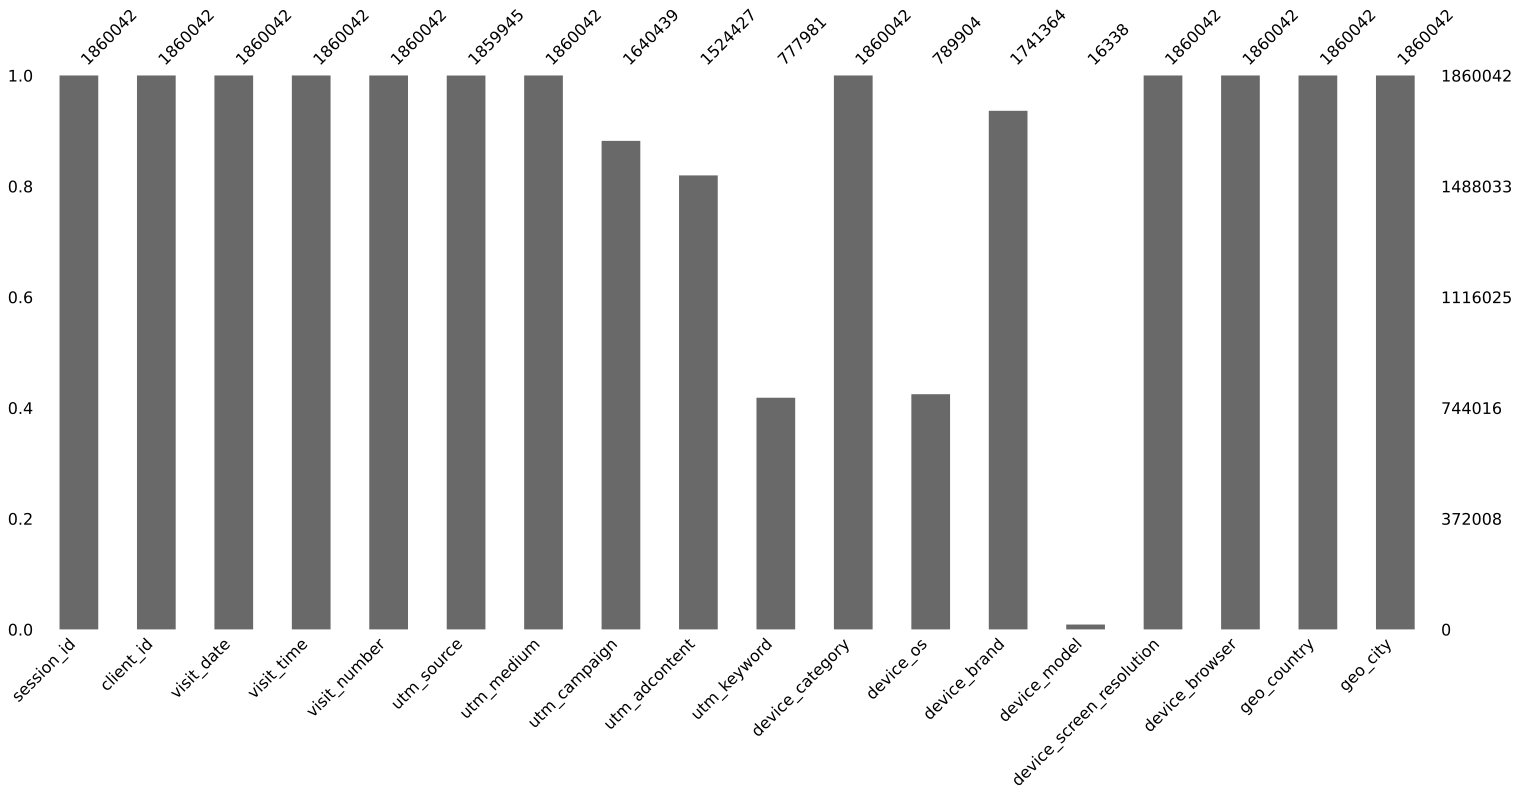

In [214]:
# без столбца с целевой переменной
plt.close('all') 
msno.bar(df_sessions.drop(columns='target_event_action'))
plt.show();

##### Матрица распределения пропусков

In [215]:
# plt.close('all')
# msno.matrix(df_sessions.drop(columns='target_event_action'))
# plt.show();

### Заполнение пропусков

#### Вывод % заполнения датасета df_sessions (ДО заполнения пропусков)

In [216]:
# Вывод списка незаполненных столбцов и % пропусков в данных
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions)

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions)

Количество полностью заполненных объектов из всей выборки: 14940
Процент полностью заполненных объектов из всей выборки:    0.8

Процент пропущенных значений:
['device_model', 'utm_keyword', 'device_os', 'utm_adcontent', 'utm_campaign', 'device_brand', 'utm_source']

device_model     99.121633
utm_keyword      58.174009
device_os        57.533002
utm_adcontent    18.043410
utm_campaign     11.806346
device_brand      6.380394
utm_source        0.005215
dtype: float64


#### Пропуски в `device_model` - 99% данных отсутствует 
- Cтолбец будет удален 

In [217]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['device_model']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['device_model']])

Количество полностью заполненных объектов из всей выборки: 16338
Процент полностью заполненных объектов из всей выборки:    0.88

Процент пропущенных значений:
['device_model']

device_model    99.121633
dtype: float64


In [218]:
# Удаление столбца device_model
df_sessions.drop(columns='device_model', inplace=True)

#### Пропуски в `utm_keyword` - замена на 'other'

In [219]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['utm_keyword']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['utm_keyword']])

Количество полностью заполненных объектов из всей выборки: 777981
Процент полностью заполненных объектов из всей выборки:    41.83

Процент пропущенных значений:
['utm_keyword']

utm_keyword    58.174009
dtype: float64


In [220]:
df_sessions['utm_keyword'].value_counts(dropna=False)

utm_keyword
NaN                     1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
hAmNSZmQkKQKAjZEGlgb      11297
UKNBOHebRIIsQRsjNKay      10946
IGUCNvHlhfHpROGclCit       7568
RkpOyeEPgcMBSDuHLQcj       6978
JajANoFxoqXfKRNBUhzx       6758
BmOOOIoWGHEfxEfoUezs       6602
ZNhSIPchlbnKwZWcsKzz       5661
pucKZkLDtpMDBTobJAJG       5391
RrhnkuoaqckNtJpAZDzH       5004
YQXPpoLsxnykCWKhGEmI       4874
DBHgBJHOdbPwsRDUbEgX       4472
tVtbIKrPSOvrXLCznVVe       3711
XEayFbemrPYbxFeNbxif       3695
MWLEpQPyjGkjHseVyeyQ       3156
fzbotReoFzSuckjwcpCs       2965
COtBsnAzfZyRVtvDlhnW       2785
tzIeQUUHahhBuEkJqDVp       2699
QYfbqJXuLdJGfOSFgZOs       2674
KCcEkEaKEtUilBVMoCAi       2637
ISrKoXQCxqqYvAZICvjs       2559
psjAUzFZVWWCuxgCrtmQ       2546
qxnAydKMtMSuafVrMzdC       2539
ObIWuFTMgFPUHNiFoOwb       2491
MBHgRPNeTcONuVFFXgmz       2476
oKjXDUsycmahkgMhGdAR       2387
qUcotcWimEOQiboVPcCx       2

In [221]:
# % пропусков высокий => Замена на 'other'
df_sessions['utm_keyword'] = df_sessions['utm_keyword'].fillna( 'other' )
print(f'Количество пропусков после операции замены = {df_sessions['utm_keyword'].isna().sum()}')

Количество пропусков после операции замены = 0


#### Пропуски в `device_brand` - замена на моду

In [222]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['device_brand']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['device_brand']])

Количество полностью заполненных объектов из всей выборки: 1741364
Процент полностью заполненных объектов из всей выборки:    93.62

Процент пропущенных значений:
['device_brand']

device_brand    6.380394
dtype: float64


In [223]:
df_sessions['device_brand'].value_counts(dropna=False)

device_brand
Apple             551088
Samsung           332194
Xiaomi            288367
                  248500
Huawei            185853
None              118678
Realme             19058
(not set)          17545
OPPO               13504
Vivo               11740
OnePlus             9965
Asus                7929
Nokia               7285
Sony                6459
ZTE                 6365
Google              5150
Meizu               3750
Lenovo              3148
Blackview           2759
Tecno               2654
LG                  2447
Motorola            2357
BQ                  1573
itel                1082
Alcatel              968
DOOGEE               876
Oukitel              826
HTC                  790
Umidigi              661
Ulefone              511
Infinix              417
Vsmart               368
LeEco                344
BlackBerry           338
Cubot                320
Philips              299
Mozilla              295
POCO                 229
Sharp                226
Vertex      

In [224]:
# % пропусков низкий => Замена на моду
df_sessions['device_brand'] = df_sessions['device_brand'].fillna( df_sessions['device_brand'].mode()[0] )
print(f'Количество пропусков после операции замены = {df_sessions['device_brand'].isna().sum()}')

Количество пропусков после операции замены = 0


#### `device_brand` - замена пустых строк '' и '(not set)' и 0 на 'other'

In [225]:
# % пустых строк высокий (+ значений (not set)) => Замена на 'other'
df_sessions.loc[ df_sessions['device_brand'].isin( ['', '(not set)', 0] ), 'device_brand'] = 'other'

df_sessions['device_brand'].value_counts(dropna=False)

device_brand
Apple             669766
Samsung           332194
Xiaomi            288367
other             266045
Huawei            185853
Realme             19058
OPPO               13504
Vivo               11740
OnePlus             9965
Asus                7929
Nokia               7285
Sony                6459
ZTE                 6365
Google              5150
Meizu               3750
Lenovo              3148
Blackview           2759
Tecno               2654
LG                  2447
Motorola            2357
BQ                  1573
itel                1082
Alcatel              968
DOOGEE               876
Oukitel              826
HTC                  790
Umidigi              661
Ulefone              511
Infinix              417
Vsmart               368
LeEco                344
BlackBerry           338
Cubot                320
Philips              299
Mozilla              295
POCO                 229
Sharp                226
Vertex               198
TP-Link              194
DEXP        

#### `device_os` - пропуски в device_os, 
- сначала замена на '(not set)',
- затем на топ 1 для каждого значения device_brand

In [226]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['device_os']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['device_os']])

Количество полностью заполненных объектов из всей выборки: 789904
Процент полностью заполненных объектов из всей выборки:    42.47

Процент пропущенных значений:
['device_os']

device_os    57.533002
dtype: float64


In [227]:
df_sessions['device_os'].value_counts(dropna=False)

device_os
None             1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: count, dtype: int64

In [228]:
# % пропусков высокий => Сначала замена на '(not set)', затем на топ 1 для каждого значения device_brand
df_sessions['device_os'] = df_sessions['device_os'].fillna( '(not set)' )
df_sessions['device_os'].isna().sum()

0

#### device_os - замена для значения '(not_set)'
-  device_os со значением (not_set) заменяю на значение device_os (Топ 1 по количеству сессий для данного device_brand)

In [229]:
df_sessions['device_brand'].value_counts(dropna=False)

device_brand
Apple             669766
Samsung           332194
Xiaomi            288367
other             266045
Huawei            185853
Realme             19058
OPPO               13504
Vivo               11740
OnePlus             9965
Asus                7929
Nokia               7285
Sony                6459
ZTE                 6365
Google              5150
Meizu               3750
Lenovo              3148
Blackview           2759
Tecno               2654
LG                  2447
Motorola            2357
BQ                  1573
itel                1082
Alcatel              968
DOOGEE               876
Oukitel              826
HTC                  790
Umidigi              661
Ulefone              511
Infinix              417
Vsmart               368
LeEco                344
BlackBerry           338
Cubot                320
Philips              299
Mozilla              295
POCO                 229
Sharp                226
Vertex               198
TP-Link              194
DEXP        

In [230]:
# создаю столбец - ключ [device_brand + (not_set)] для отбора плохих значений device_os по device_brand
df_sessions['key_device_brand_device_os'] = df_sessions['device_brand'] + '_(not set)'
# df_sessions[ ['device_brand', 'device_os', 'key_device_brand_device_os'] ].head(3)

# новый датасет device_brand + device_os + количество сессий 
df_device_os_top = df_sessions.groupby( ['device_brand', 'device_os'] )['session_id'].count().reset_index(name='cnt_sessions')

df_device_os_top.head(3).sort_values(by='cnt_sessions', ascending=False)

device_brand  device_os  cnt_sessions
2          AGM  (not set)            20
1           A1    Android             3
0           A1  (not set)             2

In [231]:
# Фильтрую строки, где есть значения device_os (device_os != '(not set)')
# Группирую этот датасет по стране device_brand и выбираю device_os (топ 1) с максимальным значением cnt_sessions
# Создаю ключ [device_brand + (not set)]
# Меняю название столбца

df_not_set = df_device_os_top.loc[ df_device_os_top['device_os'] != '(not set)', [ 'device_brand', 'device_os', 'cnt_sessions']]

df_device_os_top_1 = (
                        df_not_set
                        .sort_values('cnt_sessions', ascending=False)  # Сортирую по убыванию cnt_sessions
                        .groupby('device_brand')                       # Группирую по стране
                        .first()                                       # Беру первую запись (с максимальным cnt_sessions)
                        .reset_index()                                 # Сбрасываю индекс, чтобы device_brand стал колонкой
                    )


df_device_os_top_1['key_device_brand_device_os'] = df_device_os_top_1['device_brand'] + '_(not set)'

df_device_os_top_1.rename(columns={'device_os': 'device_os_top'}, inplace=True)
df_device_os_top_1.head(3)

device_brand device_os_top  cnt_sessions key_device_brand_device_os
0           A1       Android             3               A1_(not set)
1          AGM       Android            29              AGM_(not set)
2         Acer       Android            30             Acer_(not set)

In [232]:
# Соединяю датасеты, добавляю в df_sessions столбец device_os_top

if (not 'device_os_top' in df_sessions.columns):
    df_sessions = df_sessions.merge(
                                        df_device_os_top_1[ ['key_device_brand_device_os', 'device_os_top'] ], 
                                        on='key_device_brand_device_os', 
                                        how='left'
                                   )

# Замена device_os (not_set) на device_os топ 1 по количеству сессий для данного device_brand
# Оставшиеся нулевые значения device_os, заменяю на значение МОДУ
# Сразу удаляю вспомогательные столбцы
# освобождение памяти, удаление объектов
# Проверка на наличие (not set)
# Проверка на наличие 0

df_sessions.loc[ df_sessions['device_os'] == '(not set)', 'device_os'] = df_sessions['device_os_top']
df_sessions.loc[ (df_sessions['device_os'] == 0) | (df_sessions['device_os'].isna()), 'device_os'] = df_sessions['device_os'].mode(0)
df_sessions['device_os'] = df_sessions['device_os'].fillna( df_sessions['device_os'].mode()[0] )

df_sessions.drop( columns=['device_os_top', 'key_device_brand_device_os'], inplace=True, errors='ignore')

df_not_set, df_device_os_top_1 = None, None

print('Кол-во строк со значением device_os_top = (not set):', len(df_sessions.loc[ df_sessions['device_os'] == '(not set)', 'device_os']))
print('Кол-во строк со значением device_os_top = 0:', len(df_sessions[ df_sessions['device_os'] == 0]))

Кол-во строк со значением device_os_top = (not set): 0
Кол-во строк со значением device_os_top = 0: 0


In [233]:
df_sessions['device_os'].value_counts(dropna=False)

device_os
Android          1190222
iOS               551438
Windows            88307
Macintosh          24824
Linux               5120
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: count, dtype: int64

#### device_browser - замена для значения '(not_set)' на моду

In [310]:
# % пропусков низкий => Замена на моду
df_sessions.loc[ df_sessions['device_browser'] == '(not set)', 'device_browser'] = df_sessions['device_browser'].mode()[0] 
print('Кол-во строк со значением device_browser = (not set):', len(df_sessions.loc[ df_sessions['device_browser'] == '(not set)', 'device_browser']))

Кол-во строк со значением device_browser = (not set): 0


#### Пропуски в utm_adcontent - замена на 'other'

In [234]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['utm_adcontent']])

# Список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['utm_adcontent']])

Количество полностью заполненных объектов из всей выборки: 1524427
Процент полностью заполненных объектов из всей выборки:    81.96

Процент пропущенных значений:
['utm_adcontent']

utm_adcontent    18.04341
dtype: float64


In [235]:
df_sessions['utm_adcontent'].value_counts(dropna=False)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7319
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
XSkXBCPfnJjvxbfeewtd       4383
XKsYZiUFcdkUXQpoLKyS       4112
FkiRXDLOWtzVfvhEkhNo       2841
xnyHaukLtAvgViiZSyBC       2582
SAVVWaMghGnnvPOqMOIt       2501
guyNoEvzgofQvvwExGOq       2228
LcGIUNPUAmXtQJaDfFBR       2095
qhEmhjPXvwgEHdBikgEQ       1718
NhvfEqcSTGEZKxxvUZlj       1576
sYzBROYhjSDbFZCpzGyf       1538
DZYjhfIUfdqhfuTNUmjn       1460
EteMoEECGsaJeMnuvAZD       1412
eOWmIGTKVDPewucDtZXG       1042
twlfGCnyRPFtCeUKaust       1025
eEkLatVAYTkibdzPIyDi        992
ZKlsrASsGaoEHfwkdKjL      

In [236]:
# % пропусков высокий => Замена на 'other'
df_sessions['utm_adcontent'] = df_sessions['utm_adcontent'].fillna( 'other' )
print(f'Количество пропусков после операции замены = {df_sessions['utm_adcontent'].isna().sum()}')

Количество пропусков после операции замены = 0


#### Пропуски в `utm_campaign` - замена на 'other'

In [237]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['utm_campaign']]),

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['utm_campaign']])

Количество полностью заполненных объектов из всей выборки: 1640439
Процент полностью заполненных объектов из всей выборки:    88.19

Процент пропущенных значений:
['utm_campaign']

utm_campaign    11.806346
dtype: float64


In [238]:
df_sessions['utm_campaign'].value_counts(dropna=False)

utm_campaign
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15706
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12370
bJJuEXRheRIxXEaYIXqM     12232
YCKgTzTDywjcWyQudGch     12041
nSReTmyFtbSjlPrTKoaX     11611
QEejXfOCtOMFLZqIPApp     10172
vRLTQQKAsFQMxbcHGPhu      9461
jvsVVQVKRfBIqBDBuCkq      7950
eimRuUrNhZLAYcwRrNXu      7784
QdLfySaGXolfTBSNVfHn      7498
VBmazutCflYumtDHrQYe      7467
kVOrIKZFrEYGvixPclal      7062
MXqmDyetMTICSSitTjWV      7038
KgicpPxiEQfzPlPwQZJq      6939
PXQWdUxeUoXfoKzTBGpY      6901
JwYIveaHVpeeRZloQCfF      6548
jqlUOdZBNZYfInQVcZlS      6388
WiILFRDQbcHDHNvHzGpX      5793
IKQsApKuPmZqqmhieEgf      5607
GWZGdHKPgmZPNPwkJshU      

In [239]:
# % пропусков высокий => Замена на 'other'
df_sessions['utm_campaign'] = df_sessions['utm_campaign'].fillna( 'other' )
print(f'Количество пропусков после операции замены = {df_sessions['utm_campaign'].isna().sum()}')

Количество пропусков после операции замены = 0


#### Пропуски в `utm_source` - замена на моду

In [240]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['utm_source']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['utm_source']])

Количество полностью заполненных объектов из всей выборки: 1859945
Процент полностью заполненных объектов из всей выборки:    99.99

Процент пропущенных значений:
['utm_source']

utm_source    0.005215
dtype: float64


In [241]:
df_sessions['utm_source'].value_counts(dropna=False)

utm_source
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
geDcueAOghDzHkGMmdOq      8680
ISrKoXQCxqqYvAZICvjs      8633
nSReTmyFtbSjlPrTKoaX      7285
SzZERoLMmrEUEhDaYcyN      6828
eLzNJHzPelJpEyBwMrKo      5386
IZEXUFLARCUMynmHNBGo      4421
iNFgfQPqHPBuvGCYtrQE      3532
oZCzWSykfixnjMPDNjSU      3143
gVRrcxiDQubJiljoTbGm      2767
nmfptFmSirEqNzAzqbXA      2243
GpAkIXsclxDGyILfNlrR      2116
TxKUcPpthBDPieTGmVhx      2093
ghoaGAksqhKomdFrxgyJ      1900
KgicpPxiEQfzPlPwQZJq      1761
nrKihqcWGIzDsOqljdAv      1670
BKeImrJuRDZcHiSSTdzm      1464
DnEUulZAecfGPvdtZBYS      14

In [242]:
# % пропусков низкий => Замена на моду
df_sessions['utm_source'] = df_sessions['utm_source'].fillna( df_sessions['utm_source'].mode()[0] )
print(f'Количество пропусков после операции замены = {df_sessions['utm_source'].isna().sum()}')

Количество пропусков после операции замены = 0


#### Пропуски в `geo_city` - замена на моду
- Значение '(not_set)' будет заменено позже

In [243]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['geo_city']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['geo_city']])

Количество полностью заполненных объектов из всей выборки: 1860042
Процент полностью заполненных объектов из всей выборки:    100.0

Процент пропущенных значений:
[]

Series([], dtype: float64)


In [244]:
df_sessions['geo_city'].value_counts(dropna=False)

geo_city
Moscow                                 805329
Saint Petersburg                       296788
(not set)                               78172
Yekaterinburg                           35788
Krasnodar                               32243
Kazan                                   29531
Samara                                  24992
Nizhny Novgorod                         22227
Ufa                                     21679
Novosibirsk                             21568
Krasnoyarsk                             16346
Chelyabinsk                             15951
Tula                                    15814
Voronezh                                13908
Rostov-on-Don                           13886
Irkutsk                                 13532
Grozny                                  12742
Balashikha                              12679
Vladivostok                             12325
Yaroslavl                                9833
Sochi                                    8972
Tyumen                   

In [245]:
# % пропусков низкий => Замена на моду
df_sessions['geo_city'] = df_sessions['geo_city'].fillna( df_sessions['geo_city'].mode()[0] )
print(f'Количество пропусков после операции замены = {df_sessions['geo_city'].isna().sum()}')

Количество пропусков после операции замены = 0


#### Проверка полноты заполнения всего датасета df_sessions (ПОСЛЕ заполнения пропусков)

In [246]:
# Заполнение датасета ПОСЛЕ обработки
print_useful_rows_info(df_sessions)

# список незаполненных столбцов и % заполнения ПОСЛЕ обработки
print_list_missing_values(df_sessions)

Количество полностью заполненных объектов из всей выборки: 1860042
Процент полностью заполненных объектов из всей выборки:    100.0

Процент пропущенных значений:
[]

Series([], dtype: float64)


### Корректировка "проблемных" занчений признаков

#### Признак `utm_medium` - Замена utm_medium для значения (not_set)

In [247]:
# замена utm_medium для значений '(none) и (not set)' на страну (топ 1 по количеству сессий)
df_sessions.loc[ (df_sessions['utm_medium'] == '(none)') | (df_sessions['utm_medium'] == '(not set)'), 'utm_medium'] = 'other'

In [248]:
df_sessions['utm_medium'].value_counts(dropna=False)

utm_medium
banner               552272
cpc                  434794
other                301055
cpm                  242083
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
CPM                      40
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article                  17
nkp      

#### Признак `geo_country` - Замена страны для значения (not_set)

In [249]:
# уникальные значения geo_country
df_sessions['geo_country'].value_counts(dropna=False)

geo_country
Russia                      1800565
United States                 11784
Ukraine                        9012
Ireland                        4034
Belarus                        3636
Sweden                         2694
Kazakhstan                     2279
Germany                        2232
Turkey                         1953
Netherlands                    1549
Uzbekistan                     1523
United Kingdom                 1462
(not set)                      1146
Kyrgyzstan                      974
Georgia                         935
France                          790
Cyprus                          765
Armenia                         681
Finland                         643
Spain                           599
Poland                          556
United Arab Emirates            473
Israel                          429
Tajikistan                      400
Moldova                         385
Latvia                          357
Italy                           355
Egypt           

In [250]:
# Проверка - количество значенй (no set)
len(df_sessions.loc[ (df_sessions['geo_country'] == '(not set)')])

1146

In [251]:
# датает - страна + количество сессий (по убыванию)
df_country = df_sessions.groupby('geo_country')['session_id'].count().reset_index(name='cnt_sessions')

# страна - топ 1 по количеству сессий
df_country_top = df_country[ (df_country['geo_country'] != '(not set)')].sort_values('cnt_sessions', ascending=False).iloc[0]
country_top = df_country_top['geo_country']

# замена страны для значений '(not set)' на страну (топ 1 по количеству сессий)
df_sessions.loc[ (df_sessions['geo_country'] == '(not set)'), 'geo_country'] = country_top

# удаление объекта
df_country = None

# Проверка на наличие (no set)
len(df_sessions.loc[ (df_sessions['geo_country'] == '(not set)')])

0

#### Признак `geo_city` - Замена города для значения (not_set)

##### Замена города со значением (not_set) на город топ 1 по количеству сессий для данной страны

In [257]:
# создаю столбец - ключ [страна + (not_set)] для отбора плохих значений городов по странам
df_sessions['key_country_city'] = df_sessions['geo_country'] + '_(not set)'
df_sessions[ ['geo_country', 'geo_city', 'key_country_city'] ].head(3)

geo_country     geo_city  key_country_city
0      Russia     Zlatoust  Russia_(not set)
1      Russia       Moscow  Russia_(not set)
2      Russia  Krasnoyarsk  Russia_(not set)

In [258]:
# новый датасет страна + город + количество сессий 
df_city_top = df_sessions.groupby( ['geo_country', 'geo_city'] )['session_id'].count().reset_index(name='cnt_sessions')

df_city_top.head(3).sort_values(by='cnt_sessions', ascending=False)

geo_country   geo_city  cnt_sessions
1  Afghanistan      Kabul            31
2      Albania  (not set)            13
0  Afghanistan  (not set)             2

In [259]:
# Фильтрую строки, где есть значения городов (geo_city != '(not set)')
df_not_set = df_city_top.loc[ df_city_top['geo_city'] != '(not set)', [ 'geo_country', 'geo_city', 'cnt_sessions']]

# Группирую этот датасет по стране geo_country и выбираю город (топ 1) с максимальным значением cnt_sessions
df_city_top_1 = (
                        df_not_set
                        .sort_values('cnt_sessions', ascending=False)  # Сортирую по убыванию cnt_sessions
                        .groupby('geo_country')                        # Группирую по стране
                        .first()                                       # Беру первую запись (с максимальным cnt_sessions)
                        .reset_index()                                 # Сбрасываю индекс, чтобы geo_country стал колонкой
                    )

# Создаю ключ [страна + (not set)]
df_city_top_1['key_country_city'] = df_city_top_1['geo_country'] + '_(not set)'

# Меняю название столбца
df_city_top_1.rename(columns={'geo_city': 'geo_city_top'}, inplace=True)
df_city_top_1.head(3)

geo_country geo_city_top  cnt_sessions       key_country_city
0  Afghanistan        Kabul            31  Afghanistan_(not set)
1      Albania       Tirana            20      Albania_(not set)
2      Algeria         Oran             3      Algeria_(not set)

In [260]:
# Соединяю датасеты, добавляю в df_sessions столбец geo_city_top
df_sessions = df_sessions.merge(df_city_top_1[ ['key_country_city', 'geo_city_top'] ], 
                                on='key_country_city', 
                                how='left')

# Замена города (not_set) на город топ 1 по количеству сессий для данной страны
# Освобождение памяти
# Обновляю столбец-ключ key_country_city (geo_country + geo_city)
# Проверка на наличие (not set)

df_sessions.loc[ df_sessions['geo_city'] == '(not set)', 'geo_city'] = df_sessions['geo_city_top']
df_sessions['geo_city'] = df_sessions['geo_city'].fillna( df_sessions['geo_city'].mode()[0] )

df_sessions.drop( columns=['geo_city_top'], inplace=True, errors='ignore')

df_not_set, df_city_top_1 = None, None
df_sessions['key_country_city'] = df_sessions['geo_country'] + '_' + df_sessions['geo_city']

len(df_sessions.loc[ df_sessions['geo_city'] == '(not set)', 'geo_city'])

## Анализ данных и Конструирование новых признаков

#### Визуализация - Распределение `количества сессий` и по `типам действий` (целевое, нецелевое) 

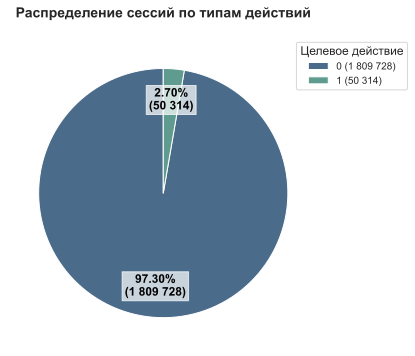

In [268]:
plot_shares_target_actions(df_sessions)

#### Визуализация - Динамика `количества сессий` и `целевых событий` (по датам)

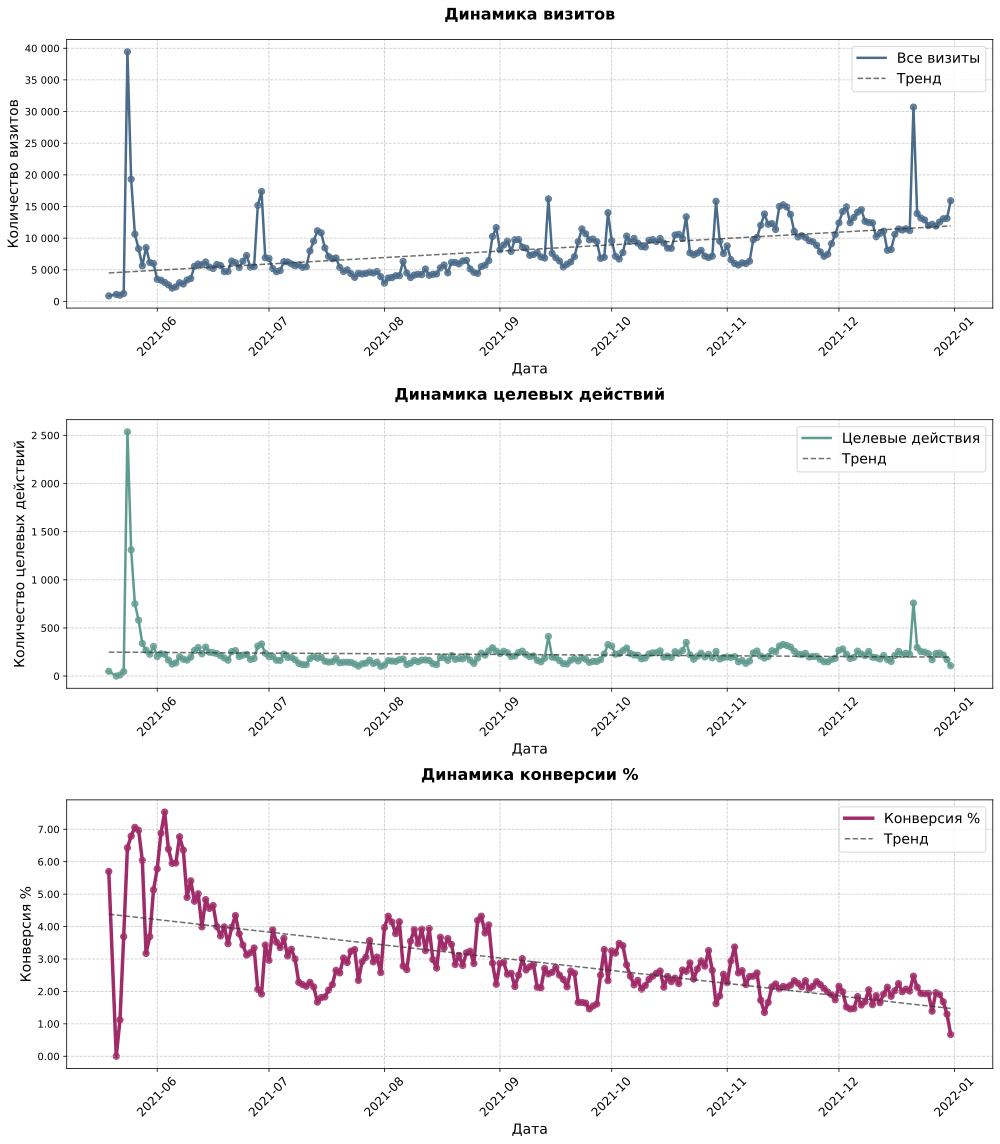

In [269]:
plot_dynamics_sessins_and_target_events(df_sessions)

### Создание новых признаков

#### Новый признак - `visit_day_of_month` - День месяца визита

In [270]:
df_sessions['visit_day_of_month'] = df_sessions['visit_date'].dt.day

# Распределение количества сессий и целевой переменной (по Дням месяца)
df_total = distribution_target_variable_for_feature( df_sessions, 'visit_day_of_month', True, True)

visit_day_of_month  total_sessions  count_target_actions  \
0                    1           52121                  1531   
1                    2           49107                  1555   
2                    3           48621                  1450   
3                    4           45360                  1279   
4                    5           51883                  1378   
5                    6           54215                  1375   
6                    7           52827                  1379   
7                    8           52214                  1372   
8                    9           51856                  1357   
9                   10           53759                  1266   
10                  11           56670                  1321   
11                  12           58739                  1414   
12                  13           59180                  1502   
13                  14           67288                  1714   
14                  15           60651                  1419   
15                  16           60122                  1529   
16                  17           59849                  1497   
17                  18           57918                  1432   
18                  19           57632                  1492   
19                  20           53857                  1360   
20                  21           79686                  2094   
21                  22           59584                  1509   
22                  23           59034                  1415   
23                  24           95389                  3879   
24                  25           74264                  2588   
25                  26           61875                  1931   
26                  27           59160                  1896   
27                  28           65109                  1781   
28                  29           81773                  1872   
29                  30           75252                  1761   
30                  31           45047                   966   

    share_sessions_%  share_target_actions_%  conversion_% is_high_conversion  
0               2.80                    3.04          2.94                     
1               2.64                    3.09          3.17                  1  
2               2.61                    2.88          2.98                     
3               2.44                    2.54          2.82                     
4               2.79                    2.74          2.66                     
5               2.91                    2.73          2.54                     
6               2.84                    2.74          2.61                     
7               2.81                    2.73          2.63                     
8               2.79                    2.70          2.62                     
9               2.89                    2.52          2.35                     
10              3.05                    2.63          2.33                     
11              3.16                    2.81          2.41                     
12              3.18                    2.99          2.54                     
13              3.62                    3.41          2.55                     
14              3.26                    2.82          2.34                     
15              3.23                    3.04          2.54                     
16              3.22                    2.98          2.50                     
17              3.11                    2.85          2.47                     
18              3.10                    2.97          2.59                     
19              2.90                    2.70          2.53                     
20              4.28                    4.16          2.63                     
21              3.20                    3.00          2.53                     
22              3.17                    2.81          2.40                     
23              5.13               

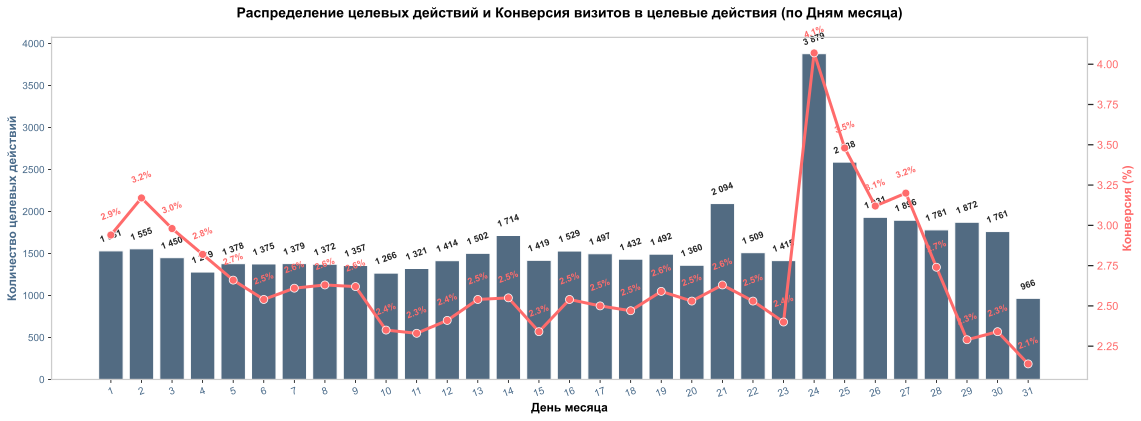

In [271]:
# Визуализация распределения количества сессий и целевой переменной (по Дням месяца)
# Установка параметры для графиков
feature_name = 'visit_day_of_month'
title1_suffix = 'по Дням месяца'
axis_label_feature = 'День месяца'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Новый признак - `visit_day_of_week` - День недели визита

In [272]:
df_sessions['visit_day_of_week'] = df_sessions['visit_date'].dt.dayofweek + 1

df_total = distribution_target_variable_for_feature( df_sessions, 'visit_day_of_week', True, True)

visit_day_of_week  total_sessions  count_target_actions  share_sessions_%  \
0                  1          300906                  9467             16.18   
1                  2          305130                  8679             16.40   
2                  3          258616                  7274             13.90   
3                  4          274462                  7232             14.76   
4                  5          268819                  6555             14.45   
5                  6          226397                  5573             12.17   
6                  7          225712                  5534             12.13   

   share_target_actions_%  conversion_% is_high_conversion  
0                   18.82          3.15                  1  
1                   17.25          2.84                     
2                   14.46          2.81                     
3                   14.37          2.63                     
4                   13.03          2.44                     
5                   11.08          2.46                     
6                   11.00          2.45

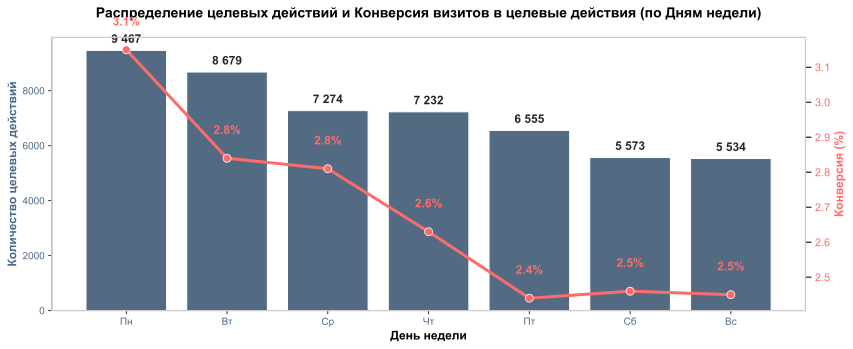

In [273]:
# Визуализация распределения количества сессий и целевой переменной (по Дням недели)
# Установка параметры для графиков
feature_name = 'visit_day_of_week'
title1_suffix = 'по Дням недели'
axis_label_feature = 'День недели'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Новый признак - `visit_hour` - час визита

In [274]:
df_sessions['visit_hour'] = df_sessions['visit_time'].dt.hour

df_total = distribution_target_variable_for_feature( df_sessions, 'visit_hour', True, True)

visit_hour  total_sessions  count_target_actions  share_sessions_%  \
0            0           66202                  1886              3.56   
1            1           40080                  1121              2.15   
2            2           27328                   644              1.47   
3            3           21036                   484              1.13   
4            4           20220                   468              1.09   
5            5           25292                   569              1.36   
6            6           36440                   721              1.96   
7            7           54894                  1194              2.95   
8            8           72015                  1699              3.87   
9            9           91860                  2317              4.94   
10          10          100849                  2857              5.42   
11          11          101266                  3083              5.44   
12          12          102071                  3039              5.49   
13          13          102477                  3230              5.51   
14          14          111487                  3285              5.99   
15          15          103854                  3080              5.58   
16          16          105241                  3188              5.66   
17          17          101086                  2959              5.43   
18          18          102701                  2806              5.52   
19          19           99184                  2483              5.33   
20          20           98731                  2396              5.31   
21          21           97612                  2388              5.25   
22          22           93473                  2372              5.03   
23          23           84643                  2045              4.55   

    share_target_actions_%  conversion_% is_high_conversion  
0                     3.75          2.85                     
1                     2.23          2.80                     
2                     1.28          2.36                     
3                     0.96          2.30                     
4                     0.93          2.31                     
5                     1.13          2.25                     
6                     1.43          1.98                     
7                     2.37          2.18                     
8                     3.38          2.36                     
9                     4.61          2.52                     
10                    5.68          2.83                     
11                    6.13          3.04                  1  
12                    6.04          2.98                  1  
13                    6.42          3.15                  1  
14                    6.53          2.95                  1  
15                    6.12          2.97                  1  
16                    6.34          3.03                  1  
17                    5.88          2.93                     
18                    5.58          2.73                     
19                    4.94          2.50                     
20                    4.76          2.43                     
21                    4.75          2.45                     
22                    4.71          2.54                     
23                    4.06          2.42

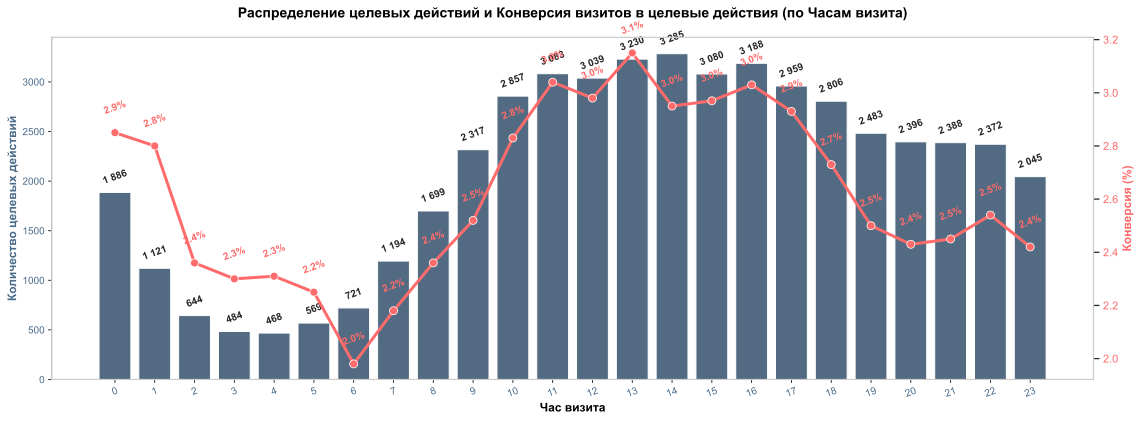

In [275]:
# Визуализация распределения количества сессий и целевой переменной (по Часам визита)

# Установка параметры для графиков
feature_name = 'visit_hour'
title1_suffix = 'по Часам визита'
axis_label_feature = 'Час визита'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Новый признак - `visit_time_of_day` -  время суток визита

In [276]:
# деление времени суток на 6 категорий
bins = [0, 5, 9, 12, 16, 20, 24]
labels = ['late_night', 'early_morning', 'morning', 'afternoon', 'evening', 'night']
df_sessions['visit_time_of_day'] = pd.cut( df_sessions['visit_hour'], bins=bins, labels=labels, right=False)

df_total = distribution_target_variable_for_feature( df_sessions, 'visit_time_of_day', True, True)

visit_time_of_day  total_sessions  count_target_actions  share_sessions_%  \
0        late_night          174866                  4603              9.40   
1     early_morning          188641                  4183             10.14   
2           morning          293975                  8257             15.80   
3         afternoon          419889                 12634             22.57   
4           evening          408212                 11436             21.95   
5             night          374459                  9201             20.13   

   share_target_actions_%  conversion_% is_high_conversion  
0                    9.15          2.63                     
1                    8.31          2.22                     
2                   16.41          2.81                     
3                   25.11          3.01                  1  
4                   22.73          2.80                     
5                   18.29          2.46

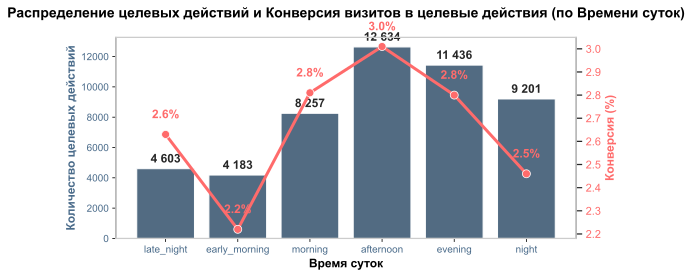

In [277]:
# Визуализация распределения количества сессий и целевой переменной (по времени суток)

# Установка параметры для графиков
feature_name = 'visit_time_of_day'
title1_suffix = 'по Времени суток'
axis_label_feature = 'Время суток'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Новый признак - `visit_is_peak_hour`- период времени визита - `Час-пик конверсии` (Горячие часы)

In [278]:
df_sessions['visit_is_peak_hour'] = df_sessions[ 'visit_hour'].isin([11, 12, 13, 14, 15, 16]).astype(int)

df_total = distribution_target_variable_for_feature( df_sessions, 'visit_is_peak_hour', True, True)

visit_is_peak_hour  total_sessions  count_target_actions  share_sessions_%  \
0                   0         1233646                 31409             66.32   
1                   1          626396                 18905             33.68   

   share_target_actions_%  conversion_% is_high_conversion  
0                   62.43          2.55                     
1                   37.57          3.02

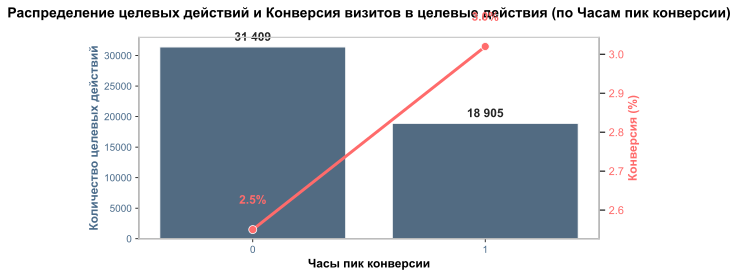

In [279]:
# Визуализация распределения количества сессий и целевой переменной (по часам пика конверсии)

# Установка параметры для графиков
feature_name = 'visit_is_peak_hour'
title1_suffix = 'по Часам пик конверсии'
axis_label_feature = 'Часы пик конверсии'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Признак `device_screen_resolution` - Замена значений '(not set)' на моду

In [280]:
# Признак device_screen_resolution - Замена значений '(not set)' на моду
mode_value = df_sessions['device_screen_resolution'].mode()[0]
df_sessions.loc[df_sessions['device_screen_resolution'] == '(not set)', 'device_screen_resolution'] = mode_value

df_sessions.device_screen_resolution.value_counts(dropna=False)

device_screen_resolution
414x896       169098
1920x1080     125768
375x812       117944
393x851       115454
375x667        93341
360x780        92182
360x800        80547
412x915        74744
360x640        70588
390x844        60827
393x873        52056
360x720        50603
360x760        50467
412x892        43944
428x926        40690
1536x864       37287
1366x768       34102
414x736        32631
1440x900       31036
412x846        25121
412x869        24855
320x568        23473
360x740        22147
1280x720       20194
385x854        18963
384x854        15573
2560x1440      13311
1600x900       12830
393x786        12752
2000x2000      11903
1680x1050      11283
320x694        11092
360x771         9023
768x1024        8218
1280x1024       8080
320x640         7823
1792x1120       7671
412x732         7422
1280x800        7274
851x393         6923
320x712         5829
1920x1200       5717
320x676         5179
393x830         4934
424x918         4836
320x569         4587
360x770  

#### Новые признаки - `device_screen_width` и `device_screen_height` - (`Ширина` и `Высота экрана` устройства)

In [281]:
# Новые признаки - device_screen_width и device_screen_height с округлением до 100 п
df_sessions[['device_screen_width', 'device_screen_height']] = (  df_sessions['device_screen_resolution']
                                                                    .str.extract(r'(\d+)x(\d+)')
                                                                    .astype(int)
                                                                ).round(-2)

In [282]:
# Распределение целевой переменной для device_screen_width
df_total = distribution_target_variable_for_feature( df_sessions, 'device_screen_width', True, True)

device_screen_width  total_sessions  count_target_actions  \
0                     0              11                     0   
1                   200              19                     0   
2                   300           78049                  1734   
3                   400         1353045                 36395   
4                   500            4384                   108   
5                   600            7633                   133   
6                   700            6961                    75   
7                   800           32931                   581   
8                   900           15107                   123   
9                  1000            7194                   151   
10                 1100            2134                    58   
11                 1200            1086                    15   
12                 1300           37755                  1306   
13                 1400           68514                  2553   
14                 1500           39601                  1295   
15                 1600           14157                   360   
16                 1700           13309                   354   
17                 1800            8039                   628   
18                 1900          132086                  3746   
19                 2000           15437                   138   
20                 2100              99                     4   
21                 2200             699                    22   
22                 2300             195                     2   
23                 2400              32                     1   
24                 2500             130                     0   
25                 2600           17249                   442   
26                 2700              12                     0   
27                 2800             241                     7   
28                 2900             131                     1   
29                 3000              89                     1   
30                 3100             120                     5   
31                 3200              69                     1   
32                 3300               9                     0   
33                 3400            2746                    53   
34                 3500               5                     1   
35                 3700               1                     0   
36                 3800             652                    21   
37                 4100              23                     0   
38                 4600               3                     0   
39                 4800               1                     0   
40                 4900               1                     0   
41                 5100              78                     0   
42                 5800               3                     0   
43                 5900               2                     0   

    share_sessions_%  share_target_actions_%  conversion_% is_high_conversion  
0               0.00                    0.00          0.00                     
1               0.00                    0.00          0.00                     
2               4.20                    3.45          2.22                     
3              72.74                   72.34          2.69                     
4               0.24                    0.21          2.46                     
5               0.41                    0.26          1.74                     
6               0.37                    0.15          1.08                     
7               1.77                    1.15          1.76                     
8               0.81                    0.24          0.81                     
9               0.39                    0.30          2.10                     
10              0.11                    0.12          2.72                     
11              0.06                    0.03          1.38                     
12              2.03                  

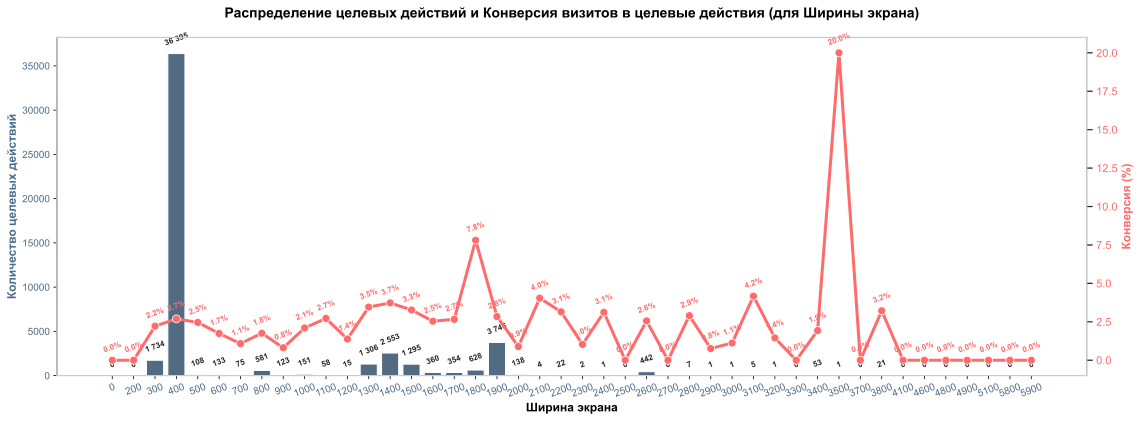

In [283]:
# Визуализация распределения количества сессий и целевой переменной (для Ширины экрана)
# Установка параметры для графиков
feature_name = 'device_screen_width'
title1_suffix = 'для Ширины экрана'
axis_label_feature = 'Ширина экрана'
#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

In [284]:
# Распределение целевой переменной для device_screen_height
df_total = distribution_target_variable_for_feature( df_sessions, 'device_screen_height', True, True)

device_screen_height  total_sessions  count_target_actions  \
0                      0              11                     0   
1                    300            2849                    16   
2                    400           35432                   267   
3                    500            3697                    52   
4                    600          114581                  2492   
5                    700          270842                  7066   
6                    800          541073                 14472   
7                    900          659809                 19508   
8                   1000           39073                   950   
9                   1100          144206                  4467   
10                  1200           13536                   399   
11                  1300            2279                    60   
12                  1400           19195                   535   
13                  1500              61                     0   
14                  1600             478                     8   
15                  1700             213                     6   
16                  1800              67                     1   
17                  1900             169                     3   
18                  2000           11925                     2   
19                  2100               3                     0   
20                  2200             406                     7   
21                  2300               5                     0   
22                  2400              17                     0   
23                  2500              13                     0   
24                  2600              48                     3   
25                  2700               8                     0   
26                  2800               1                     0   
27                  2900               2                     0   
28                  3700               1                     0   
29                  3800               3                     0   
30                  5100              10                     0   
31                 20000              29                     0   

    share_sessions_%  share_target_actions_%  conversion_% is_high_conversion  
0               0.00                    0.00          0.00                     
1               0.15                    0.03          0.56                     
2               1.90                    0.53          0.75                     
3               0.20                    0.10          1.41                     
4               6.16                    4.95          2.17                     
5              14.56                   14.04          2.61                     
6              29.09                   28.76          2.67                     
7              35.47                   38.77          2.96                  1  
8               2.10                    1.89          2.43                     
9               7.75                    8.88          3.10                  1  
10              0.73                    0.79          2.95                  1  
11              0.12                    0.12          2.63                     
12              1.03                    1.06          2.79                     
13              0.00                    0.00          0.00                     
14              0.03                    0.02          1.67                     
15              0.01                    0.01          2.82                     
16              0.00                    0.00          1.49                     
17              0.01                    0.01          1.78                     
18              0.64                    0.00          0.02                     
19              0.00                    0.00          0.00                     
20              0.02                    0.01          1.72                     
21              0.00                    0.00          0.00       

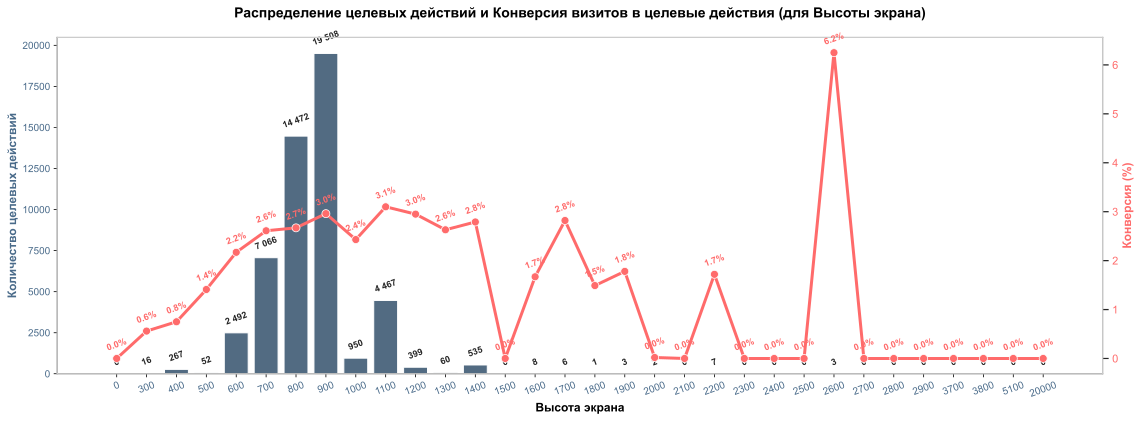

In [285]:
# Визуализация распределения количества сессий и целевой переменной (для Высоты экрана)
# Установка параметры для графиков
feature_name = 'device_screen_height'
title1_suffix = 'для Высоты экрана'
axis_label_feature = 'Высота экрана'
#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Новый признак - `device_screen_aspect_ratio` - `Коэффициент соотношения сторон экрана` устройства

In [286]:
# Коэф = Ширина / Высота, кратно (1 или 0.5), оставил 0.5
df_sessions['device_screen_aspect_ratio'] = (( df_sessions['device_screen_width'] / df_sessions['device_screen_height']) * 2 ).round() / 2

# все значения, меньше 0.5, приравниваются к 0.5)
# все значения, больше 3, приравниваются к 3)
df_sessions.loc[ df_sessions['device_screen_aspect_ratio'] < 0.5, 'device_screen_aspect_ratio'] = 0.5
# df_sessions.loc[ df_sessions['device_screen_aspect_ratio'] > 3, 'device_screen_aspect_ratio'] = 3 

df_sessions['device_screen_aspect_ratio'] = df_sessions['device_screen_aspect_ratio'].fillna( 
                                                        df_sessions['device_screen_aspect_ratio'].mode()[0] )

print(df_sessions['device_screen_aspect_ratio'].value_counts(dropna=False).sort_index())

# Распределение целевой переменной для device_screen_aspect_ratio
display(Markdown(f"#### Распределение количества сессий и целевой переменной (для Коэффициента соотношения сторон экрана устройства)"))
df_total = distribution_target_variable_for_feature( df_sessions, 'device_screen_aspect_ratio', True, True)

device_screen_aspect_ratio  total_sessions  count_target_actions  \
0                         0.5         1451087                 38678   
1                         1.0           24197                   295   
2                         1.5          254323                  8155   
3                         2.0          121683                  3062   
4                         2.5            8469                   114   
5                         3.0              61                     6   
6                         3.5             217                     4   
7                         5.5               5                     0   

   share_sessions_%  share_target_actions_%  conversion_% is_high_conversion  
0             78.01                   76.87          2.67                     
1              1.30                    0.59          1.22                     
2             13.67                   16.21          3.21                     
3              6.54                    6.09          2.52                     
4              0.46                    0.23          1.35                     
5              0.00                    0.01          9.84                  1  
6              0.01                    0.01          1.84                     
7              0.00                    0.00          0.00

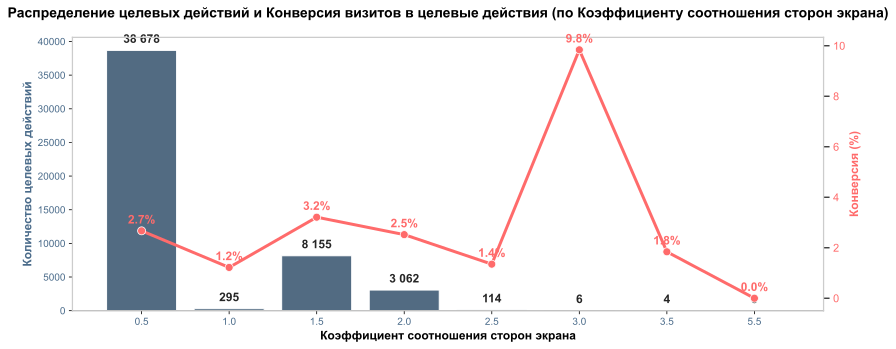

In [287]:
# Визуализация распределения количества сессий и целевой переменной (для Коэффициента соотношения сторон экрана)
# Установка параметры для графиков
feature_name = 'device_screen_aspect_ratio'
title1_suffix = 'по Коэффициенту соотношения сторон экрана'
axis_label_feature = 'Коэффициент соотношения сторон экрана'
#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,
                            is_show_labels=True
                        )

#### Новый признак - `visit_days_since_first_visit` - `Срок жизни клиента на момент визита (в днях)`

In [288]:
# дата первого визита клиента
df_client_visit_min_date = df_sessions.groupby('client_id')['visit_date'].min().reset_index(name='visit_date_min')

# переношу первую (минимальную) дату визита в основной датасет
df_sessions = df_sessions.merge(
                                df_client_visit_min_date,
                                on='client_id',
                                how='inner',
                                indicator=False
                            )
# Освобождение памяти
df_client_visit_min_date = None

# вывод записей, где дата визита и дата первого визита не совпадают
df_sessions[ df_sessions['visit_date'] != df_sessions['visit_date_min']].head(3)

session_id              client_id  \
10  9055466554104774132.1629442326.1629442326  2108390106.1624800756   
12  9055469620715506713.1633110583.1633110583  2108390820.1628883993   
13  9055469620715506713.1635878177.1635878177  2108390820.1628883993   

   visit_date          visit_time  visit_number            utm_source  \
10 2021-08-20 1900-01-01 09:00:00             2  ZpYIoDJMcFzVoPFsHGJL   
12 2021-10-01 1900-01-01 20:00:00             2  fDLlAcSmythWSCVMvqvL   
13 2021-11-02 1900-01-01 21:36:17             3  gVRrcxiDQubJiljoTbGm   

   utm_medium          utm_campaign         utm_adcontent  \
10     banner  LEoPHuyFvzoNfnzGgfcd  JNHcPlZPxEMWDnRiyoBf   
12      other  LTuZkdKfxRGVceoWkVyg  JNHcPlZPxEMWDnRiyoBf   
13   referral  LTuZkdKfxRGVceoWkVyg  JNHcPlZPxEMWDnRiyoBf   

             utm_keyword device_category device_os device_brand  \
10                 other          mobile   Android      Samsung   
12                 other          mobile   Android      Samsung   
13  puhZPIYqKXeFPaUviSjo          mobile   Android      Samsung   

   device_screen_resolution   device_browser geo_country          geo_city  \
10                  412x915           Chrome      Russia            Moscow   
12                  412x869  Android Webview      Russia  Saint Petersburg   
13                  412x869  Android Webview      Russia             Sochi   

    target_event_action         key_country_city  visit_day_of_month  \
10                    0            Russia_Moscow                  20   
12                    0  Russia_Saint Petersburg                   1   
13                    0             Russia_Sochi                   2   

    visit_day_of_week  visit_hour visit_time_of_day  visit_is_peak_hour  \
10                  5           9           morning                   0   
12                  5          20             night                   0   
13                  2          21             night                   0   

    device_screen_width  device_screen_height  device_screen_aspect_ratio  \
10                  400                   900                         0.5   
12                  400                   900                         0.5   
13                  400                   900                         0.5   

   visit_date_min  
10     2021-06-27  
12     2021-08-13  
13     2021-08-13

#### Новый признак `visit_days_since_first_visit`
#### `Срок жизни клиента (для каждого визита) со времени первого визита (в днях)`

In [289]:
df_sessions['visit_days_since_first_visit']  = (  df_sessions['visit_date'] - df_sessions['visit_date_min']).dt.days

display(Markdown(f"#### Распределение целевой переменной (для Срока жизни в Днях)"))
distribution_target_variable_for_feature( df_sessions, 'visit_days_since_first_visit')

visit_days_since_first_visit  total_sessions  count_target_actions  \
0                               0         1584952                 39515   
1                               1           62768                  2380   
2                               2           22971                   980   
3                               3           15366                   698   
4                               4           12112                   505   
5                               5            9991                   432   
6                               6            9228                   427   
7                               7            8008                   363   
8                               8            6084                   262   
9                               9            4890                   223   
10                             10            4455                   201   
11                             11            4074                   165   
12                             12            3746                   173   
13                             13            3677                   156   
14                             14            3726                   120   
15                             15            3293                   123   
16                             16            3076                   141   
17                             17            2807                   111   
18                             18            2600                    99   
19                             19            2657                    97   
20                             20            2682                    96   
21                             21            2698                    88   
22                             22            2529                    92   
23                             23            2262                   103   
24                             24            2202                    64   
25                             25            1953                    84   
26                             26            1891                    77   
27                             27            2013                    70   
28                             28            2015                    83   
29                             29            1818                    68   
30                             30            1696                    60   
31                             31            1572                    63   
32                             32            1401                    63   
33                             33            1422                    54   
34                             34            1422                    64   
35                             35            1485                    68   
36                             36            1428                    43   
37                             37            1286                    43   
38                             38            1248                    40   
39                             39            1165                    42   
40                             40            1132                    32   
41                             41            1219                    37   
42                             42            1270                    53   
43                             43            1113                    46   
44                             44             974                    28   
45                             45             933                    31   
46                             46             937                    27   
47                             47             967                    27   
48                             48             980                    33   
49                             49             949                    29   
50                             50             844                    33   
51                             51             847                    33   
52                            

#### Новый признак - `utm_is_organic_traffic` - `Органический трафик` - значения (1 или 0)

In [290]:
organic_traffic = ['(none)', 'organic', 'referral']

df_sessions['utm_is_organic_traffic'] = 0
df_sessions.loc[ df_sessions['utm_medium'].isin( organic_traffic ), 'utm_is_organic_traffic'] = 1

# Распределение целевой переменной для utm_is_organic_traffic
df_total = distribution_target_variable_for_feature( df_sessions, 'utm_is_organic_traffic', True, True)

utm_is_organic_traffic  total_sessions  count_target_actions  \
0                       0         1644958                 40033   
1                       1          215084                 10281   

   share_sessions_%  share_target_actions_%  conversion_% is_high_conversion  
0             88.44                   79.57          2.43                     
1             11.56                   20.43          4.78

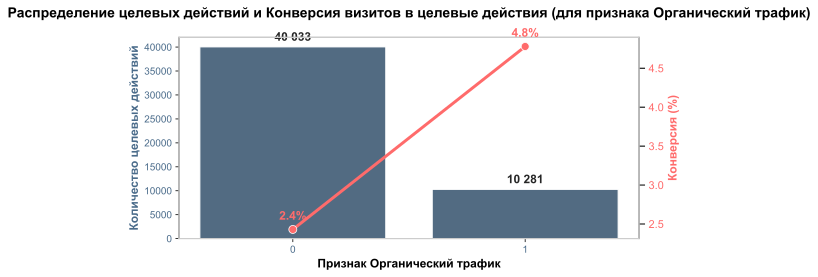

In [291]:
# Визуализация распределения количества сессий и целевой переменной (для utm_is_organic_traffic)
# Установка параметры для графиков
feature_name = 'utm_is_organic_traffic'
title1_suffix = 'для признака Органический трафик'
axis_label_feature = 'Признак Органический трафик'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,      
                            is_show_labels=True
                        )

#### Новый признак - `utm_is_advertising_in_social_networks` - `Реклама в соц сетях` - значения (1 или 0)

In [292]:
source_advertising = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
                       'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

df_sessions['utm_is_advertising_in_social_networks'] = 0
df_sessions.loc[ df_sessions['utm_source'].isin( source_advertising ), 'utm_is_advertising_in_social_networks'] = 1
# df_sessions[ df_sessions['utm_is_advertising_in_social_networks'] == 1].head(3)

# распределение целевой переменной для utm_is_advertising_in_social_networks
df_total = distribution_target_variable_for_feature( df_sessions, 'utm_is_advertising_in_social_networks', True, True)

utm_is_advertising_in_social_networks  total_sessions  \
0                                      0         1585815   
1                                      1          274227   

   count_target_actions  share_sessions_%  share_target_actions_%  \
0                 46293             85.26                   92.01   
1                  4021             14.74                    7.99   

   conversion_% is_high_conversion  
0          2.92                     
1          1.47

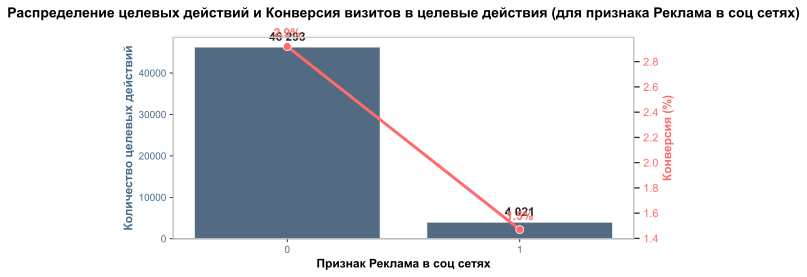

In [293]:
# Визуализация распределения количества сессий и целевой переменной (для utm_is_advertising_in_social_networks)
# Установка параметры для графиков
feature_name = 'utm_is_advertising_in_social_networks'
title1_suffix = 'для признака Реклама в соц сетях'
axis_label_feature = 'Признак Реклама в соц сетях'

#----------------------------------------------------------------------------
# Вызов функцию отрисовки
plot_metrics_distribution(
                            df=df_total,
                            feature=feature_name,
                            title1_suffix=title1_suffix,
                            axis_label_feature=axis_label_feature,      
                            is_show_labels=True
                        )

### Описательная статистика всех числовых признаков, дат и времени

In [294]:
# Описательная статистика числовых признаков
pd.reset_option('display.float_format')

with pd.option_context('display.float_format', '{:.0f}'.format):
    desc = df_sessions.describe()
    
    # форматирование
    desc['visit_date'] = pd.to_datetime( desc['visit_date'], errors='coerce').dt.strftime('%Y-%m-%d')
    desc['visit_time'] = pd.to_datetime( desc['visit_time'], errors='coerce').dt.strftime('%H:%M:%S')
    desc['visit_date_min'] = pd.to_datetime( desc['visit_date_min'], errors='coerce').dt.strftime('%Y-%m-%d')
    
    display(desc)

visit_date visit_time  visit_number  target_event_action  \
count  1970-01-01   00:00:00       1860042              1860042   
mean   2021-09-26   13:49:53             3                    0   
min    2021-05-19   00:00:00             1                    0   
25%    2021-08-02   10:00:00             1                    0   
50%    2021-10-06   14:09:06             1                    0   
75%    2021-11-23   19:00:00             2                    0   
max    2021-12-31   23:59:59           564                    1   
std           NaN        NaN            12                    0   

       visit_day_of_month  visit_day_of_week  visit_hour  visit_is_peak_hour  \
count             1860042            1860042     1860042             1860042   
mean                   17                  4          14                   0   
min                     1                  1           0                   0   
25%                    10                  2          10                   0   
50%                    17                  4          14                   0   
75%                    24                  5          19                   1   
max                    31                  7          23                   1   
std                     9                  2           6                   0   

       device_screen_width  device_screen_height  device_screen_aspect_ratio  \
count              1860042               1860042                     1860042   
mean                   664                   846                           1   
min                      0                     0                           0   
25%                    400                   800                           0   
50%                    400                   800                           0   
75%                    400                   900                           0   
max                   5900                 20000                           6   
std                    546                   195                           0   

      visit_date_min  visit_days_since_first_visit  utm_is_organic_traffic  \
count     1970-01-01                       1860042                 1860042   
mean      2021-09-23                             3                       0   
min       2021-05-19                             0                       0   
25%       2021-07-26                             0                       0   
50%       2021-10-02                             0                       0   
75%       2021-11-20                             0                       0   
max       2021-12-31                           223                       1   
std              NaN                            16                       0   

       utm_is_advertising_in_social_networks  
count                                1860042  
mean                                       0  
min                                        0  
25%                                        0  
50%                                        0  
75%                                        0  
max                                        1  
std                                        0

#### Новые признаки - Географические координаты места - `geo_latitude` (`Широта`) и `geo_longitude` (`Долгота`)
- определяются по стране и городу
- координаты были получены с помощьюю библиотеки __geopy__
- полученные координаты были сохранены в готовом виде в csv-файле __locations.csv__
- здесь по умолчанию задан режим __source_location = 'csv_file'__, т.е. координаты брать из файла (для экономии времени)

In [295]:
# датасет с уникальными парами город-страна
df_locations = df_sessions[ ['geo_country', 'geo_city'] ].drop_duplicates()

# Выбор способа получения координат
source_location = 'csv_file'
# source_location = 'geo_service'

# получение всех координат по стране и городу 
if (source_location == 'csv_file'):         # из csv-файла
    df_locations = get_coordinates_from_csv()
else:     # из гео-сервиса
    df_locations = get_coordinates_from_geo(df_locations)

df_locations.rename(columns={
                            'latitude': 'geo_latitude',
                            'longitude': 'geo_longitude' }, inplace=True)
df_locations.head(3)

geo_country     geo_city               coordinates  geo_latitude  \
0      Russia     Zlatoust  (55.0346395, 59.5292694)     55.034639   
1      Russia       Moscow   (55.625578, 37.6063916)     55.625578   
2      Russia  Krasnoyarsk   (56.0091173, 92.872586)     56.009117   

   geo_longitude  
0      59.529269  
1      37.606392  
2      92.872586

In [296]:
# Заполнение датасета ДО обработки
print_useful_rows_info(df_locations[ ['geo_latitude']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_locations[ ['geo_latitude'] ])

Количество полностью заполненных объектов из всей выборки: 2508
Процент полностью заполненных объектов из всей выборки:    96.8

Процент пропущенных значений:
['geo_latitude']

geo_latitude    3.203396
dtype: float64


#### Новый признак - `geo_distance_to_city_km` - `Расстояния до Москвы` (основного города присутствия данного сервиса)

In [297]:
# Координаты основного города присутствия (Москва)
target_city_coords = (55.7558, 37.6176)

# Расчет расстояния до Москвы
df_locations['geo_distance_to_city_km'] = df_locations[ df_locations['geo_latitude'].notna() ].apply(
                                                lambda row: geodesic( (row['geo_latitude'], row['geo_longitude']), target_city_coords).km, axis=1)
df_locations.head(3)

geo_country     geo_city               coordinates  geo_latitude  \
0      Russia     Zlatoust  (55.0346395, 59.5292694)     55.034639   
1      Russia       Moscow   (55.625578, 37.6063916)     55.625578   
2      Russia  Krasnoyarsk   (56.0091173, 92.872586)     56.009117   

   geo_longitude  geo_distance_to_city_km  
0      59.529269              1384.911913  
1      37.606392                14.515547  
2      92.872586              3364.293349

In [298]:
# Объединяю координаты с исходным датасетом
df_sessions = df_sessions.merge(
                                    df_locations[ ['geo_country', 'geo_city', 'geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ],
                                    on=['geo_country', 'geo_city'],
                                    how='left'
                                 )
# освобождаю память
df_location = None

##### Проверка заполненности геоданных

In [299]:
# Широта
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['geo_latitude']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['geo_latitude']])

Количество полностью заполненных объектов из всей выборки: 1841778
Процент полностью заполненных объектов из всей выборки:    99.02

Процент пропущенных значений:
['geo_latitude']

geo_latitude    0.981913
dtype: float64


In [300]:
# Долгота
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['geo_longitude']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['geo_longitude']])

Количество полностью заполненных объектов из всей выборки: 1841778
Процент полностью заполненных объектов из всей выборки:    99.02

Процент пропущенных значений:
['geo_longitude']

geo_longitude    0.981913
dtype: float64


In [301]:
# Рассотяние до Москвы
# Заполнение датасета ДО обработки
print_useful_rows_info(df_sessions[ ['geo_distance_to_city_km']])

# список незаполненных столбцов и % заполнения ДО обработки
print_list_missing_values(df_sessions[['geo_distance_to_city_km']])

Количество полностью заполненных объектов из всей выборки: 1841778
Процент полностью заполненных объектов из всей выборки:    99.02

Процент пропущенных значений:
['geo_distance_to_city_km']

geo_distance_to_city_km    0.981913
dtype: float64


In [302]:
# Количество уникальных значений Широты
df_sessions[ ['geo_latitude']].value_counts(dropna=False)

geo_latitude
 55.625578      876496
 59.960674      296788
 56.839104       35788
 45.035153       32243
 55.782355       29531
 53.195625       24992
 56.276929       22227
 54.726141       21679
 54.967814       21568
NaN              18264
 56.009117       16346
 55.155931       15951
 51.680008       13908
 47.261044       13886
 52.289122       13532
 43.292005       12742
 55.799766       12679
 43.115068       12325
 57.626388        9833
 43.585482        8972
 57.153534        8534
 55.891729        7385
 51.530018        7120
 58.014965        6293
 55.557150        5358
 55.678223        5314
 55.909493        5284
 56.860518        5193
 55.746459        4916
 52.693518        4531
 44.863258        4377
 54.991375        4130
 55.913376        4047
 55.436821        4038
 53.349379        4030
 51.631268        3980
 48.708191        3974
 44.299826        3805
 54.710128        3784
 44.037544        3782
 56.858675        3680
 55.430884        3621
 54.510109        350

#### Обработка пропусков в координатах geo_latitude, geo_longitude, geo_distance_to_city_km

In [303]:
# Шаг 1: Заполняю пропуски медианами широты и долготы (по странам и городам)
country_city_medians = df_sessions.groupby( ['geo_country', 'geo_city'] )[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].transform('median')
df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ] = df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].fillna(country_city_medians)

# Шаг 2: Заполняю пропуски медианами широты и долготы (по городам)
city_only_medians = df_sessions.groupby( ['geo_city'] )[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].transform('median')
df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ] = df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].fillna(city_only_medians)

# Шаг 3: Заполняю оставшиеся пропуски медианами широты и долготы (по странам)
country_only_medians = df_sessions.groupby('geo_country')[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].transform('median')
df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ] = df_sessions[['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].fillna(country_only_medians)

# Шаг 4: Заполняю оставшиеся пропуски медианами широты и долготы (по всей выборке)
total_medians = df_sessions[['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km']].median()
df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ] = df_sessions[['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].fillna(total_medians)

# Освобождение памяти
country_city_medians, city_only_medians, country_only_medians = None, None, None

# Проверяю результат
print("Количество оставшихся пропусков:")
print(df_sessions[ ['geo_latitude', 'geo_longitude', 'geo_distance_to_city_km'] ].isna().sum())

Количество оставшихся пропусков:
geo_latitude               0
geo_longitude              0
geo_distance_to_city_km    0
dtype: int64


In [304]:
# Пример вывода полученных данных, для строк, где было целевое действие
columns = ['geo_country', 'geo_city', 'key_country_city', 'geo_latitude', 'geo_longitude', 'geo_distance_to_city_km', 'target_event_action']
df_sessions[columns].query('target_event_action == 1').head(3)

geo_country    geo_city   key_country_city  geo_latitude  geo_longitude  \
71      Russia      Moscow      Russia_Moscow     55.625578      37.606392   
75      Russia      Samara      Russia_Samara     53.195625      50.101493   
78      Russia  Domodedovo  Russia_Domodedovo     55.436821      37.768069   

    geo_distance_to_city_km  target_event_action  
71                14.515547                    1  
75               856.551156                    1  
78                36.758336                    1

In [305]:
# Распределения количества сессий и целевой переменной (для geo_distance_to_city_km)
df_total = distribution_target_variable_for_feature( df_sessions, 'geo_distance_to_city_km', True, True)

geo_distance_to_city_km  total_sessions  count_target_actions  \
0                    1.751082               9                     0   
1                    2.310199               9                     0   
2                    2.462145               9                     0   
3                    2.613698               1                     0   
4                    2.807302               3                     0   
5                    3.018056              13                     0   
6                    5.318900              30                     1   
7                   10.143575               1                     0   
8                   13.448090              13                     0   
9                   14.291456               6                     0   
10                  14.515547          876638                 25021   
11                  15.018846            2375                    63   
12                  18.600030            5284                   123   
13                  18.798116            7385                   236   
14                  18.874038           19604                   555   
15                  19.382445            2497                    36   
16                  20.027779            3292                    94   
17                  20.156627             969                    28   
18                  20.654146           12679                   359   
19                  22.387585            2713                    86   
20                  22.657136            4047                   145   
21                  22.848358            5358                   144   
22                  23.607077             261                     9   
23                  23.677937            5314                   152   
24                  24.604039            4916                   103   
25                  25.204678             723                    28   
26                  26.691058            1310                    35   
27                  27.247333             743                    12   
28                  28.624583              67                     1   
29                  28.723693             114                     7   
30                  29.156080            1443                    45   
31                  29.762724            2319                    58   
32                  29.876105            1984                    68   
33                  30.576915            1010                    24   
34                  31.754843            2446                    66   
35                  33.241160            1036                    20   
36                  35.304928            1085                    32   
37                  35.585462             247                     4   
38                  36.460329            3621                    95   
39                  36.758336            4038                   263   
40                  37.550919             244                     9   
41                  38.243886              45                     0   
42                  38.543394             158                     4   
43                  39.514691             335                     7   
44                  39.747321             534                    16   
45                  41.519103             585                    22   
46                  41.798686            1058                    17   
47                  42.547705             344                    16   
48                  43.592646            1872                    56   
49                  46.272665             139                     3   
50                  47.764828             868                    29   
51                  48.145541             334                     6   
52                  50.104586             339                     9   
53                  50.681648            1238                    35   
54                  50.701235            1945                    52   
55                  52.378866 

In [306]:
# Не стал включать этот признак (Регион присутствия) в итоговый датасет

#### is_city_of_presence - Регион присутствия - новый признак значения (1 или 0)
    # - 1 - город находится в регионе присутствия сервиса
    # - 0 - не находится

# главные города присутсвия
# cities_main = ['Moscow', 'Saint Petersburg']

# # Московская область (просто перечисление городов, которые были найдены в датасете)
# cities_moscow_region = ['Balashikha', 'Dolgoprudny', 'Domodedovo', 'Dubna', 'Zhukovskiy',
#                         'Zvenigorod', 'Istra', 'Klin', 'Kolomna', 'Korolyov', 
#                         'Kotelniki', 'Krasnogorsk','Lobnya', 'Lyubertsy', 'Mytishchi', 
#                         'Odintsovo', 'Orekhovo-Zuyevo', 'Podolsk','Pushkino', 'Sergiyev', 
#                         'Serpukhov', 'Khimki', 'Chekhov', 'Shchelkovo', 'Elektrostal']

# # Ленинградская область (также перечисление городов)
# cities_leningrad_region = ['Gatchina', 'Priozersk', 'Sertolovo', 'Sosnovy Bor', 'Tikhvin', 'Vsevolozhsk', 'Vyborg']

# # общий список всех городов присутствия
# cities_presence = cities_main + cities_moscow_region + cities_leningrad_region

# # новый столбец is_cities_of_presence
# df_sessions['is_city_of_presence'] = df_sessions['geo_city'].isin(cities_presence).astype(int)

# # Распределения количества сессий и целевой переменной (Для is_city_of_presence)
# df_total = distribution_target_variable_for_feature( df_sessions, 'is_city_of_presence', True, True)

### Категориальные переменные

#### Количество уникальных значений

In [315]:
categorical_columns = df_sessions.select_dtypes(include=['object', 'category']).columns.tolist()
nunique_sorted = df_sessions[categorical_columns].nunique().sort_values(ascending=False)

print("Количество уникальных значений в столбцах (по убыванию):")
print(nunique_sorted.to_string())

Количество уникальных значений в столбцах (по убыванию):
session_id                  1860042
client_id                   1391719
device_screen_resolution       5038
key_country_city               2591
geo_city                       2547
utm_keyword                    1220
utm_campaign                    413
utm_source                      293
utm_adcontent                   287
device_brand                    205
geo_country                     165
device_browser                   56
utm_medium                       55
device_os                        12
visit_time_of_day                 6
device_category                   3


#### Проверка `редких значений категориальных признаков`, для которых целевая переменная = 0
#### и замена их на `'rare_value'`

In [316]:
%%time
list_features_utm = ['utm_source',
                    'utm_medium',
                    'utm_campaign',
                    'utm_adcontent',
                    'utm_keyword']
                     
list_features_device = ['device_category',
                        'device_os',
                        'device_brand',
                        'device_browser']
categorical_features = list_features_utm + list_features_device

for col in categorical_features:
    
    # Число уникальных значений и общее количество строк
    cnt_unique = df_sessions[col].nunique()
    
    # Порог: 1% от числа уникальных значений (минимум 1)
    threshold = max(1, int(cnt_unique * 0.01))
    
    # Частотность значений
    value_counts = df_sessions[col].value_counts()
    
    # Значения, где target всегда 0 (индексируем по значениям признака)
    zero_target_mask = df_sessions.groupby(col)['target_event_action'].sum() == 0
    
    # Совмещаю маски, учитывая индексы
    rare_values = value_counts[ value_counts.index.isin(zero_target_mask[zero_target_mask].index) & (value_counts < threshold)].index
    
    # Вывод статистики
    print(f'{col}:\t '
        f'Уникальных значений = {cnt_unique}\t'
        f'Редких значений ( < 1% от уникальных) = {len(rare_values)};\t'
        f'% проблемных = {round(len(rare_values)/cnt_unique * 100, 2)}%')

    # Замена редких значений на 
    df_sessions[col] = df_sessions[col].replace(rare_values, 'rare_value')

utm_source:	 Уникальных значений = 293	Редких значений ( < 1% от уникальных) = 80;	% проблемных = 27.3%
utm_medium:	 Уникальных значений = 55	Редких значений ( < 1% от уникальных) = 0;	% проблемных = 0.0%
utm_campaign:	 Уникальных значений = 413	Редких значений ( < 1% от уникальных) = 67;	% проблемных = 16.22%
utm_adcontent:	 Уникальных значений = 287	Редких значений ( < 1% от уникальных) = 41;	% проблемных = 14.29%
utm_keyword:	 Уникальных значений = 1220	Редких значений ( < 1% от уникальных) = 620;	% проблемных = 50.82%
device_category:	 Уникальных значений = 3	Редких значений ( < 1% от уникальных) = 0;	% проблемных = 0.0%
device_os:	 Уникальных значений = 12	Редких значений ( < 1% от уникальных) = 0;	% проблемных = 0.0%
device_brand:	 Уникальных значений = 205	Редких значений ( < 1% от уникальных) = 37;	% проблемных = 18.05%
device_browser:	 Уникальных значений = 56	Редких значений ( < 1% от уникальных) = 0;	% проблемных = 0.0%
CPU times: total: 2min 44s
Wall time: 2min 59s


### Все категориальные признаки преобразую в числовые несколькими способами:
- TargetEncoder
- Frequency encoding
- OnHotEncoder

#### Признаки с высокой кардинальностью (более 100 уникальных значений)
#### метод `TargetEncoder`
- Преобразование категориальных переменных в числовые значения на основе целевой переменной
- Каждая категория замещается средним значением целевой переменной для этой категории

In [317]:
encoder = TargetEncoder(smooth="auto")

# utm_keyword (1220), utm_campaign (413), utm_source (293), utm_adcontent (287), device_brand (205)
list_columns_many_values = ['utm_keyword', 'utm_campaign', 'utm_source', 'utm_adcontent', 'device_brand']

# Масштабирую выбранные столбцы и сохраняю с суффиксом '_encoded'
for column in list_columns_many_values:
    if column in df_sessions.columns:                  
        df_sessions[f'{column}_encoded'] = encoder.fit_transform( 
                                                                    df_sessions[ [column] ], 
                                                                    df_sessions['target_event_action'] 
                                                                )

columns_encoded = [ f'{col}_encoded' for col  in list_columns_many_values]
df_sessions[ list_columns_many_values + columns_encoded ].head(3)

utm_keyword          utm_campaign            utm_source  \
0  puhZPIYqKXeFPaUviSjo  LEoPHuyFvzoNfnzGgfcd  ZpYIoDJMcFzVoPFsHGJL   
1  IGUCNvHlhfHpROGclCit  FTjNLDyTrXaWYgZymFkV  MvfHsxITijuriZxsqZqt   
2  puhZPIYqKXeFPaUviSjo  LEoPHuyFvzoNfnzGgfcd  ZpYIoDJMcFzVoPFsHGJL   

          utm_adcontent device_brand  utm_keyword_encoded  \
0  vCIpmpaGBnIQhyYNkXqp       Huawei             0.022161   
1  xhoenQgDQsgfEPYNPwKO      Samsung             0.014596   
2  vCIpmpaGBnIQhyYNkXqp       Huawei             0.022161   

   utm_campaign_encoded  utm_source_encoded  utm_adcontent_encoded  \
0              0.028721            0.027587               0.021738   
1              0.009910            0.012037               0.011271   
2              0.029040            0.027587               0.021550   

   device_brand_encoded  
0              0.024152  
1              0.030082  
2              0.024396

#### Признаки со средней кардинальностью (10-100 уникальных значений)
#### метод `Частотное ординальное кодирование` (Frequency encoding)
- Значение каждой категории заменяется на частоту встречаемости этой категории в наборе данных

In [318]:
# Признаки со средней кардинальностью (10-100 значений)
# device_browser (57), utm_medium (56)
list_columns_medium_values = ['device_browser', 'utm_medium']

for column in list_columns_medium_values:
    freq = df_sessions[column].value_counts()
    df_sessions[f'{column}_encoded'] = df_sessions[column].map(freq)

columns_encoded = [ f'{col}_encoded' for col in list_columns_medium_values]
df_sessions[ list_columns_medium_values + columns_encoded ].head(3)

device_browser utm_medium  device_browser_encoded  utm_medium_encoded
0            Chrome     banner                 1013453              552272
1  Samsung Internet        cpm                   47309              242083
2            Chrome     banner                 1013453              552272

#### Признаки с низкой кардинальностью (< 20 значений)
- #### метод `OneHotEncoder`

##### Сначала преобразование типа признаков к типу 'category'

In [319]:
# device_os (13), visit_time_of_day (6), device_category (3)
list_columns_few_values = ['device_os', 
                           'device_category',
                           'visit_time_of_day']

df_sessions[ list_columns_few_values] = df_sessions[ list_columns_few_values].astype('category')
# df_sessions.info(verbose=True, show_counts=True)

nunique_sorted = df_sessions[ list_columns_few_values ].nunique().sort_values(ascending=False)
print("Количество уникальных значений в столбцах (по убыванию):")
print(nunique_sorted.to_string())

Количество уникальных значений в столбцах (по убыванию):
device_os            12
visit_time_of_day     6
device_category       3


##### Преобразование OneHotEncoder

In [320]:
%%time
dt_start_1 = datetime.now()
print('\n',column, dt_start_1.strftime("%Y-%m-%d %H:%M:%S"))
columns_to_encode = list_columns_few_values

# Шаг 1 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Шаг 2 
encoder.fit( df_sessions[columns_to_encode])
encoded_data = encoder.transform( df_sessions[columns_to_encode])

df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index=df_sessions.index)

# Шаг 3 
# Объединяю с исходным DataFrame
print('Размеры датасетов:', df_sessions.shape, df_encoded.shape)
df_sessions = pd.concat( [df_sessions, df_encoded], axis=1)

# Шаг 4 
# Очищаю память
encoder, encoded_data, df_encoded = None, None, None


 utm_medium 2025-07-16 00:57:22
Размеры датасетов: (1860042, 41) (1860042, 21)
CPU times: total: 6.67 s
Wall time: 7.36 s


In [321]:
# Результаты преобразования
print(df_sessions.shape)
print()
df_sessions.info(verbose=True, show_counts=True)

(1860042, 62)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 62 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   session_id                             1860042 non-null  object        
 1   client_id                              1860042 non-null  object        
 2   visit_date                             1860042 non-null  datetime64[ns]
 3   visit_time                             1860042 non-null  datetime64[ns]
 4   visit_number                           1860042 non-null  int64         
 5   utm_source                             1860042 non-null  object        
 6   utm_medium                             1860042 non-null  object        
 7   utm_campaign                           1860042 non-null  object        
 8   utm_adcontent                          1860042 non-null  object        
 9   utm_keyword         

### Числовые признаки - масштабирование
#### метод `StandardScaler`
- Стандартизирует признаки, приводя данные к стандартному нормальному распределению с центром в нуле и стандартным отклонением, равным единице

In [322]:
# список исходных числовых столбцов
list_columns_numeric = ['visit_number',
                        'visit_day_of_month',
                        'visit_day_of_week',
                        'visit_hour',
                        'visit_days_since_first_visit',
                        'device_screen_width', 
                        'device_screen_height',
                        'device_screen_aspect_ratio',
                        'geo_latitude', 
                        'geo_longitude',
                        'geo_distance_to_city_km']

scaler = StandardScaler()

# Масштабирую выбранные столбцы и сохраняю их с суффиксом '_std'
for column in list_columns_numeric:
    if column in df_sessions.columns:
        df_sessions[f'{column}_std'] = scaler.fit_transform(df_sessions[ [column] ])

# вывод новых масштабированных признаков
columns_std = [ f'{col}_std' for col  in list_columns_numeric]
df_sessions[ list_columns_numeric + columns_std].head(3)

visit_number  visit_day_of_month  visit_day_of_week  visit_hour  \
0             1                  24                  3          14   
1             1                  14                  7           8   
2             1                  28                  2           2   

   visit_days_since_first_visit  device_screen_width  device_screen_height  \
0                             0                  400                   700   
1                             0                  400                   900   
2                             0                  400                   700   

   device_screen_aspect_ratio  geo_latitude  geo_longitude  \
0                         0.5     55.034639      59.529269   
1                         0.5     55.625578      37.606392   
2                         0.5     56.009117      92.872586   

   geo_distance_to_city_km  visit_number_std  visit_day_of_month_std  \
0              1384.911913         -0.144796                0.801436   
1                14.515547         -0.144796               -0.336427   
2              3364.293349         -0.144796                1.256581   

   visit_day_of_week_std  visit_hour_std  visit_days_since_first_visit_std  \
0              -0.403088        0.062216                         -0.215497   
1               1.613486       -0.917870                         -0.215497   
2              -0.907232       -1.897956                         -0.215497   

   device_screen_width_std  device_screen_height_std  \
0                -0.483368                 -0.746246   
1                -0.483368                  0.278352   
2                -0.483368                 -0.746246   

   device_screen_aspect_ratio_std  geo_latitude_std  geo_longitude_std  \
0                       -0.508221         -0.065288           0.925924   
1                       -0.508221          0.069833          -0.150951   
2                       -0.508221          0.157532           2.563783   

   geo_distance_to_city_km_std  
0                     0.614029  
1                    -0.511600  
2                     2.239872

## Визуализация распределения признаков

### Производные от признаков visit_...

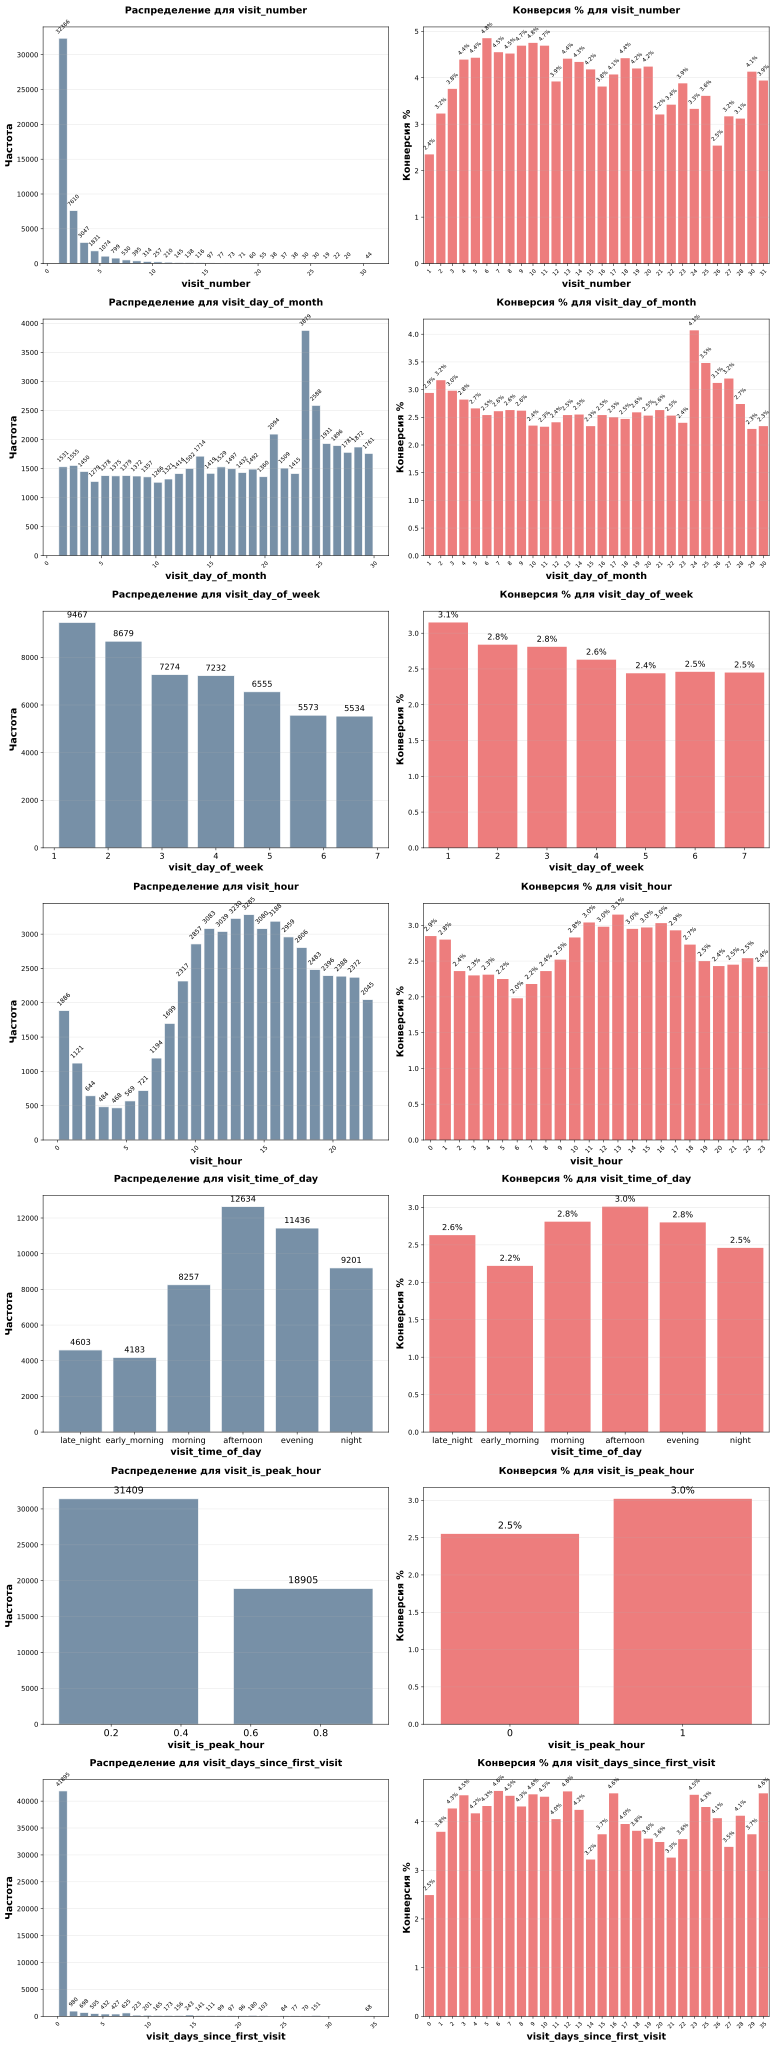

In [323]:
list_features = [
                'visit_number',
                'visit_day_of_month',
                'visit_day_of_week',
                'visit_hour',
                'visit_time_of_day',
                'visit_is_peak_hour',
                'visit_days_since_first_visit']

plot_faceted_distribution(df_sessions, list_features)

### Признаки utm-метки и их производные

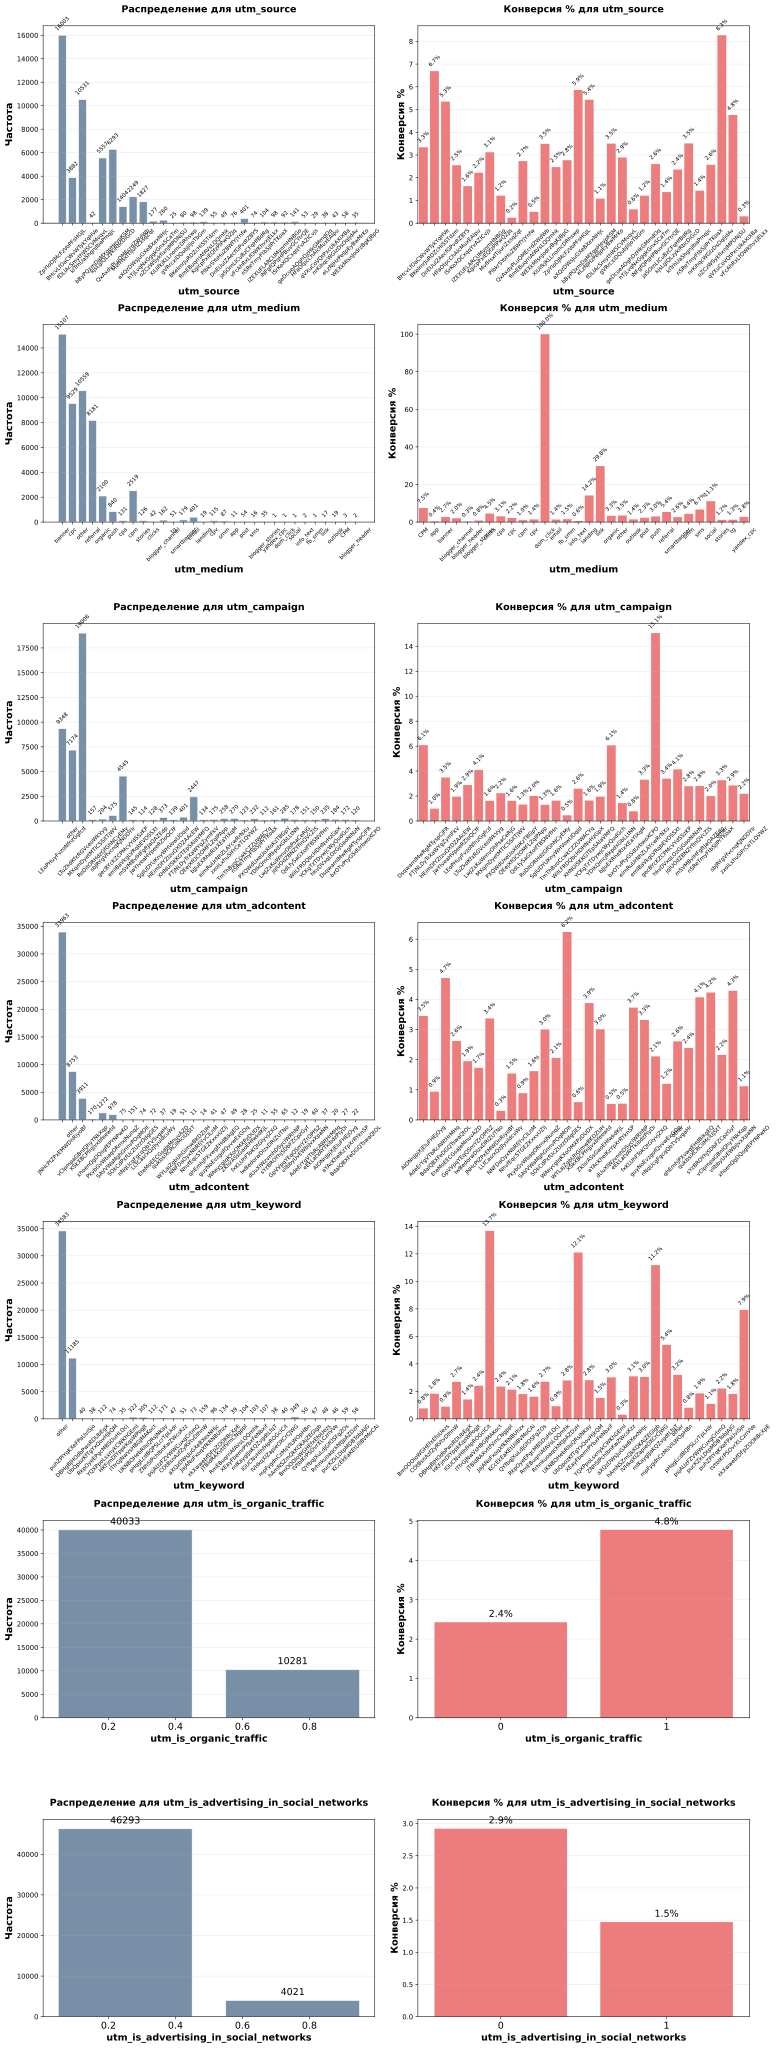

In [324]:
list_features = ['utm_source',
                'utm_medium',
                'utm_campaign',
                'utm_adcontent',
                'utm_keyword',
                
                'utm_is_organic_traffic',
                'utm_is_advertising_in_social_networks']

plot_faceted_distribution(df_sessions, list_features)

### Признаки device_... и их производные

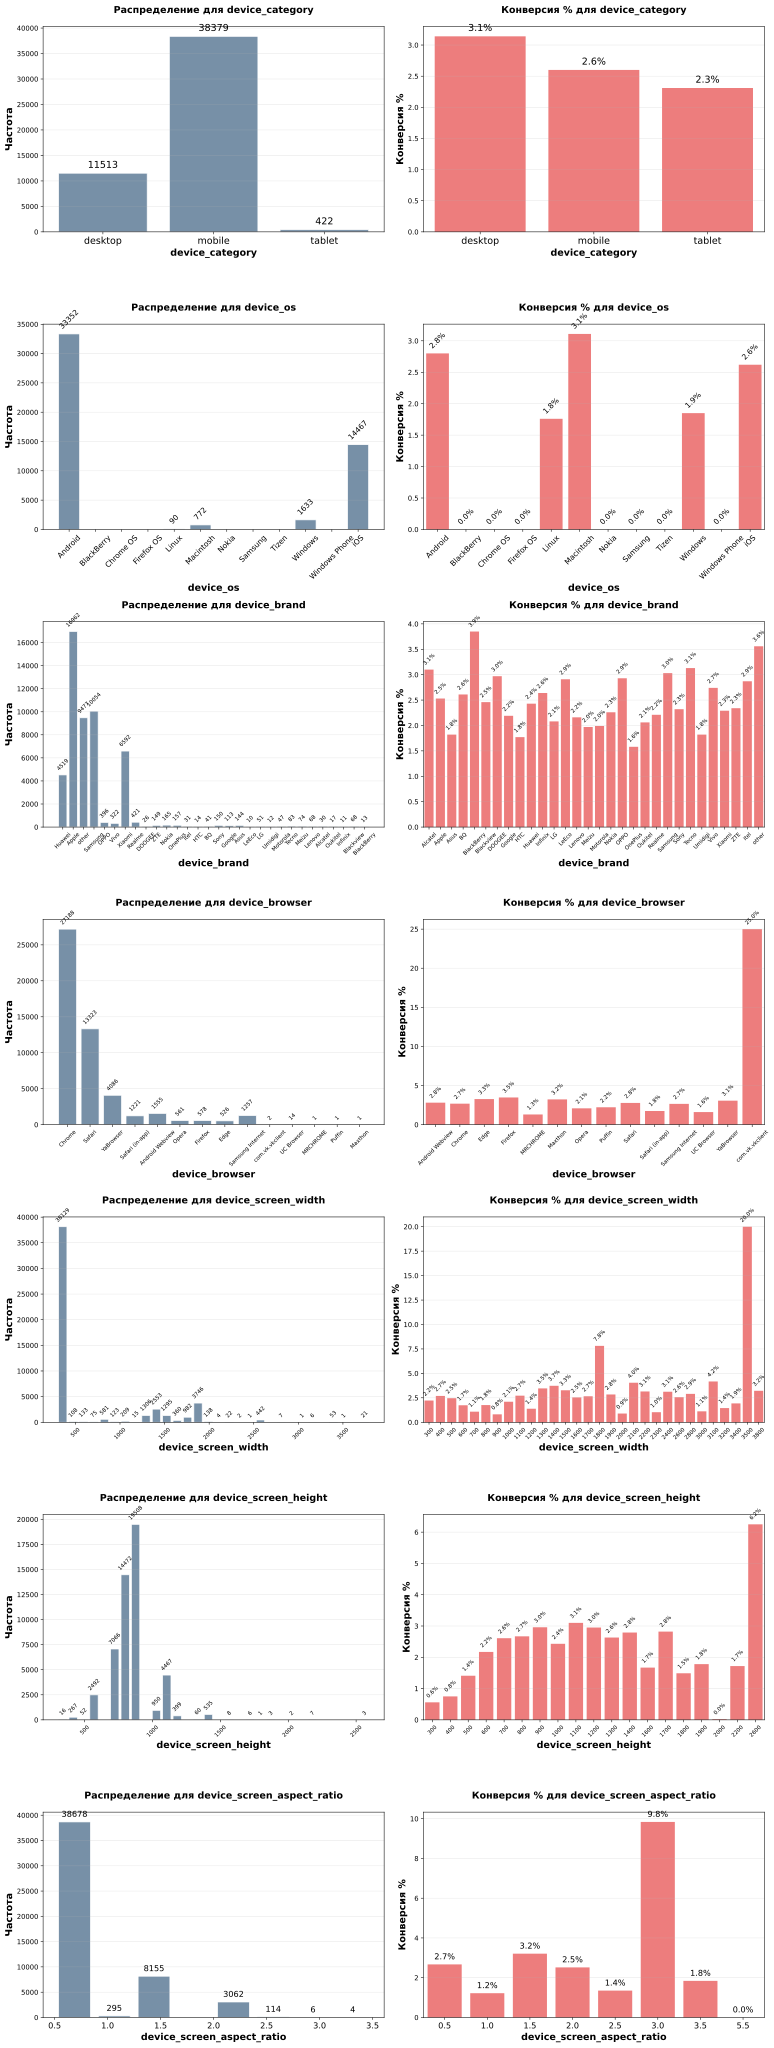

In [325]:
list_features = ['device_category',
                'device_os',
                'device_brand',
                'device_browser',
                
                'device_screen_width',
                'device_screen_height',
                'device_screen_aspect_ratio']

plot_faceted_distribution(df_sessions, list_features)

### Признаки geo... (гео данные) и их производные

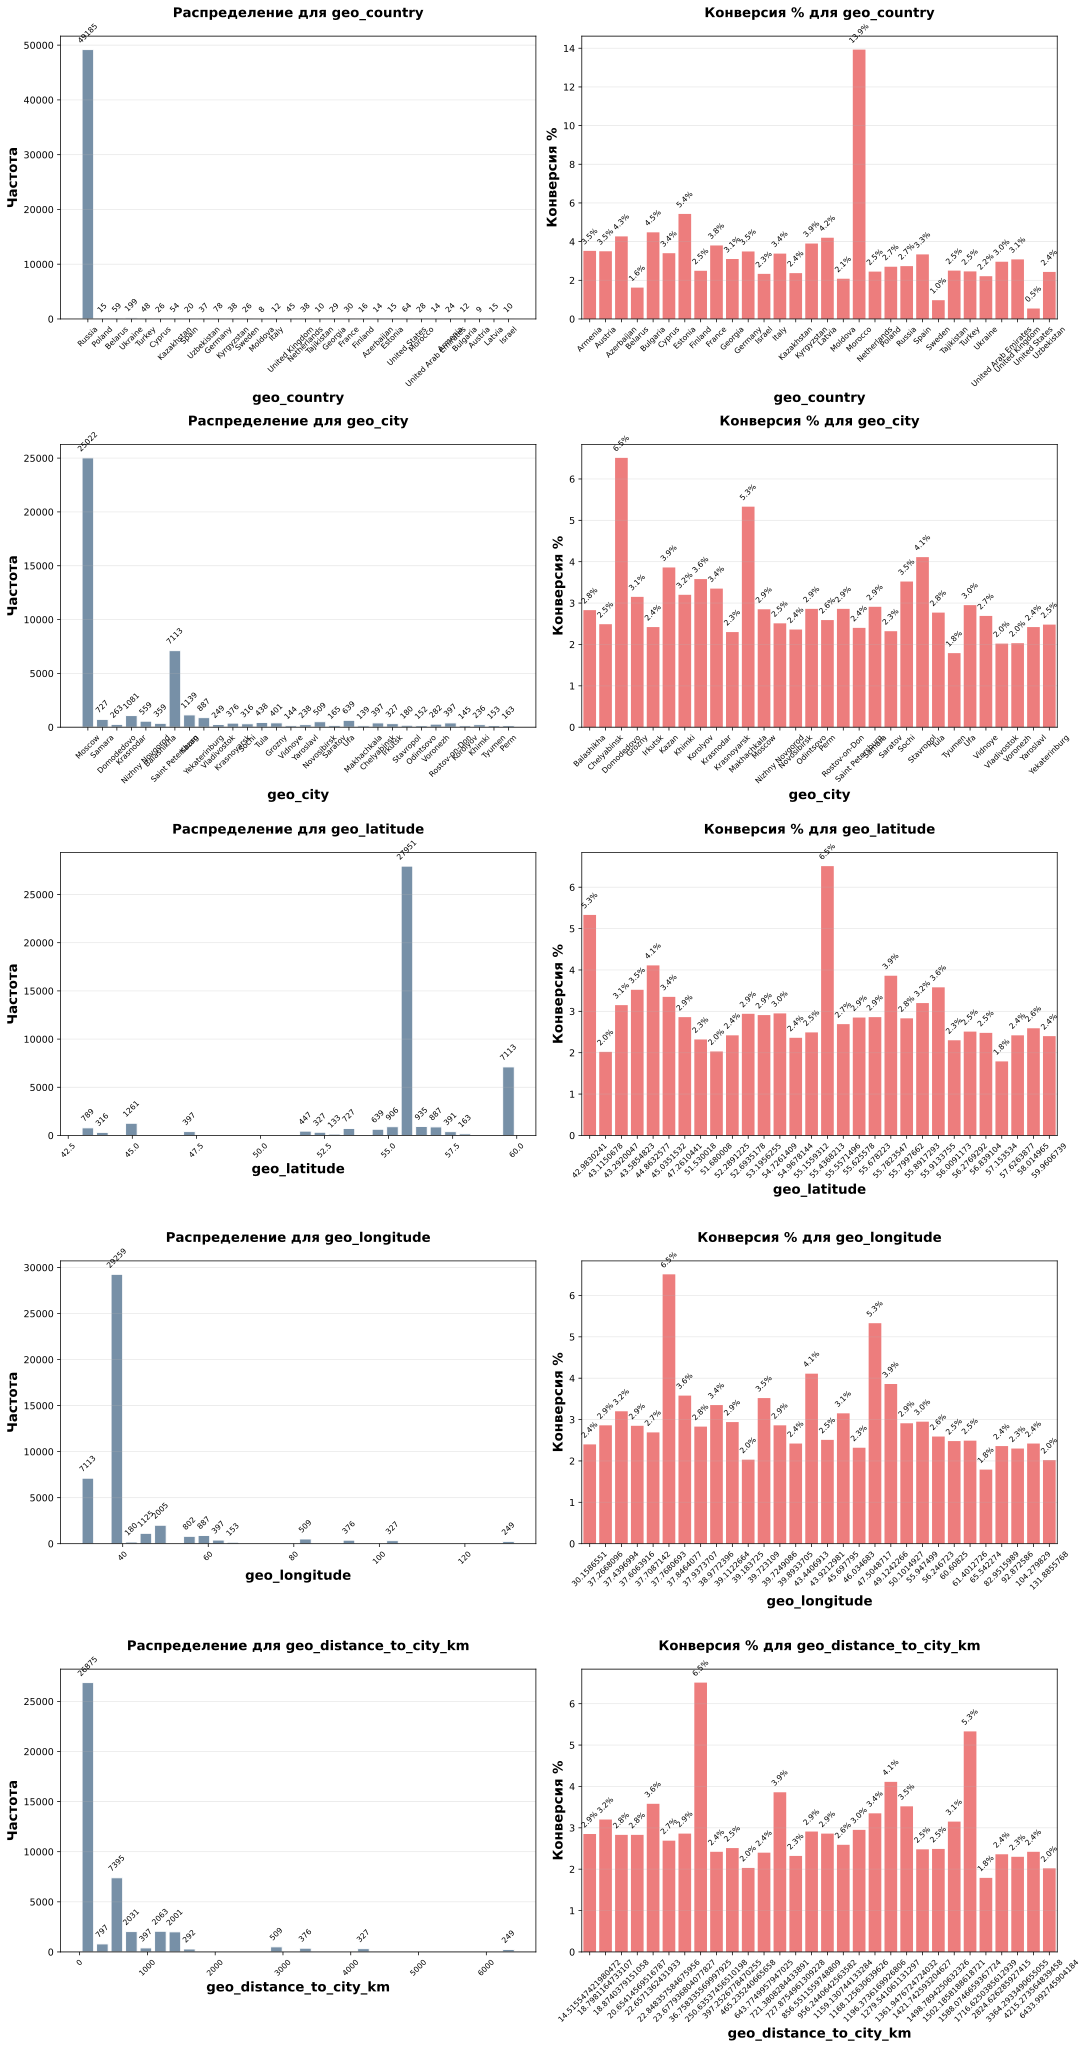

In [326]:
list_features = ['geo_country',
                'geo_city',
                'geo_latitude',
                'geo_longitude',
                'geo_distance_to_city_km']

plot_faceted_distribution(df_sessions, list_features)

<span style="color:blue"> Внимание! Замер времени, контрольная точка </span>

In [327]:
get_duration_time(dt_start)

## DEBUG - Убрать - Технические операции
##### Сохранение финального датасета в CSV-файл (до удаления оригинальных и вспомогательных столбцов)

In [328]:
## DEBUG - Убрать - Технические операции
##### Сохранение финального датасета в CSV-файл (до удаления оригинальных и вспомогательных столбцов)
save_dataset_to_file_csv(df_sessions, 'data_check/df_sessions_final_dataset.csv')
text_to_speech('Финальный датасет сохранен в файл CSV!')

## Удаление ненужных исходных и вспомогательных столбцов

In [329]:
print(f'df_sessions До удаления пр; {df_sessions.shape}\n')
print()
df_sessions.info(verbose=True, show_counts=True)

df_sessions До удаления пр; (1860042, 73)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 73 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   session_id                             1860042 non-null  object        
 1   client_id                              1860042 non-null  object        
 2   visit_date                             1860042 non-null  datetime64[ns]
 3   visit_time                             1860042 non-null  datetime64[ns]
 4   visit_number                           1860042 non-null  int64         
 5   utm_source                             1860042 non-null  object        
 6   utm_medium                             1860042 non-null  object        
 7   utm_campaign                           1860042 non-null  object        
 8   utm_adcontent                          1860042 non-null  object     

In [330]:
# удаление ненужных признаков
df_sessions = drop_unnecessary_columns(df_sessions)

print(df_sessions.shape)
print()
df_sessions.info(verbose=True, show_counts=True)

(1860042, 43)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 43 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   target_event_action                    1860042 non-null  int32  
 1   visit_is_peak_hour                     1860042 non-null  int32  
 2   utm_is_organic_traffic                 1860042 non-null  int64  
 3   utm_is_advertising_in_social_networks  1860042 non-null  int64  
 4   utm_keyword_encoded                    1860042 non-null  float64
 5   utm_campaign_encoded                   1860042 non-null  float64
 6   utm_source_encoded                     1860042 non-null  float64
 7   utm_adcontent_encoded                  1860042 non-null  float64
 8   device_brand_encoded                   1860042 non-null  float64
 9   device_browser_encoded                 1860042 non-null  int64  
 10  utm_medium_encoded         

#### DEBUG - УБРАТЬ - Сохранение финального датасета df_session в pickle-файл
- чтобы потом можно было бы быстро из него загружать данные и отлаживать работу с моделями

In [331]:
%%time
save_dataset_to_file_pkl(df_sessions, 'data/df_sessions_final_dataset.pkl')
# chime.success()
text_to_speech('Финальный датасет записан в pickle-файл')

CPU times: total: 1.64 s
Wall time: 7.77 s


## Корреляция признаков

- Сначала анализирую корреляцию по блокам данных visit_, utm_, device_, geo_
- Затем все признаки вместе**

#### Матрица корреляции - признаки visit_...

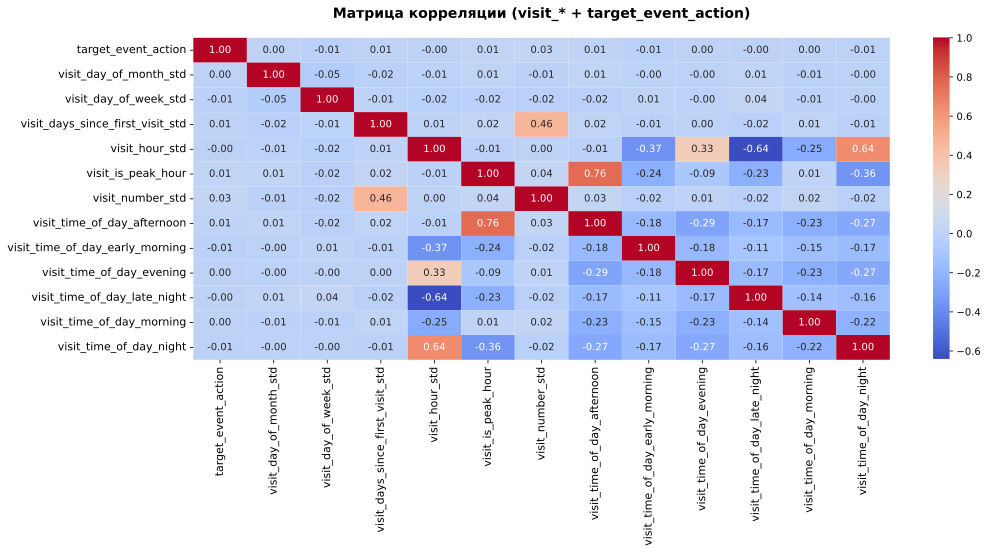

target_event_action  visit_day_of_month_std  \
target_event_action                          1.000000                0.001877   
visit_number_std                             0.025320               -0.009669   
visit_is_peak_hour                           0.013751                0.011316   
visit_time_of_day_afternoon                  0.010115                0.010856   
visit_days_since_first_visit_std             0.008814               -0.018902   
visit_time_of_day_evening                    0.003154               -0.003984   
visit_time_of_day_morning                    0.002771               -0.010213   
visit_day_of_month_std                       0.001877                1.000000   
visit_hour_std                              -0.000060               -0.006107   
visit_time_of_day_late_night                -0.001443                0.012461   
visit_time_of_day_night                     -0.007670               -0.003665   
visit_time_of_day_early_morning             -0.010097               -0.004409   
visit_day_of_week_std                       -0.014443               -0.051717   

                                  visit_day_of_week_std  \
target_event_action                           -0.014443   
visit_number_std                              -0.016539   
visit_is_peak_hour                            -0.019230   
visit_time_of_day_afternoon                   -0.016352   
visit_days_since_first_visit_std              -0.006174   
visit_time_of_day_evening                     -0.003247   
visit_time_of_day_morning                     -0.010051   
visit_day_of_month_std                        -0.051717   
visit_hour_std                                -0.022790   
visit_time_of_day_late_night                   0.035932   
visit_time_of_day_night                       -0.002653   
visit_time_of_day_early_morning                0.008029   
visit_day_of_week_std                          1.000000   

                                  visit_days_since_first_visit_std  \
target_event_action                                       0.008814   
visit_number_std                                          0.461271   
visit_is_peak_hour                                        0.021936   
visit_time_of_day_afternoon                               0.016456   
visit_days_since_first_visit_std                          1.000000   
visit_time_of_day_evening                                 0.003891   
visit_time_of_day_morning                                 0.014585   
visit_day_of_month_std                                   -0.018902   
visit_hour_std                                            0.005393   
visit_time_of_day_late_night                             -0.015826   
visit_time_of_day_night                                  -0.011663   
visit_time_of_day_early_morning                          -0.014957   
visit_day_of_week_std                                    -0.006174   

                                  visit_hour_std  visit_is_peak_hour  \
target_event_action                    -0.000060            0.013751   
visit_number_std                        0.003891            0.035578   
visit_is_peak_hour                     -0.010685            1.000000   
visit_time_of_day_afternoon            -0.008999            0.757764   
visit_days_since_first_visit_std        0.005393            0.021936   
visit_time_of_day_evening               0.334389           -0.088586   
visit_time_of_day_morning              -0.253869            0.007065   
visit_day_of_month_std                 -0.006107            0.011316   
visit_hour_std                          1.000000           -0.010685   
visit_time_of_day_late_night           -0.644790           -0.229540   
visit_time_of_day_night                 0.641229           -0.357753   
visit_time_of_day_early_morning        -0.367604           -0.239391   
visit_day_of_week_std                  -0.022790           -0.019230   

                                  visit_number_std  \
target_event_action         

In [332]:
column_prefix = 'visit_'
features_columns = df_sessions.filter(like=column_prefix).columns.tolist() + ['target_event_action']

corr_matrix, target_corr = matrix_corr(df_sessions[features_columns], column_prefix)
corr_matrix.sort_values('target_event_action', ascending=False)

#### Матрица корреляции - признаки utm_...

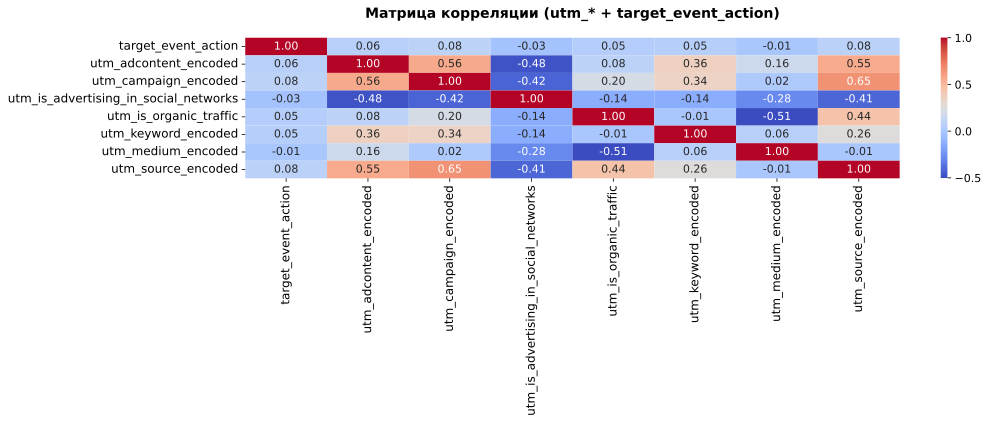

target_event_action  \
target_event_action                               1.000000   
utm_campaign_encoded                              0.081137   
utm_source_encoded                                0.075075   
utm_adcontent_encoded                             0.057665   
utm_keyword_encoded                               0.048328   
utm_is_organic_traffic                            0.046251   
utm_medium_encoded                               -0.009735   
utm_is_advertising_in_social_networks            -0.031751   

                                       utm_adcontent_encoded  \
target_event_action                                 0.057665   
utm_campaign_encoded                                0.562859   
utm_source_encoded                                  0.554518   
utm_adcontent_encoded                               1.000000   
utm_keyword_encoded                                 0.364919   
utm_is_organic_traffic                              0.081754   
utm_medium_encoded                                  0.158253   
utm_is_advertising_in_social_networks              -0.477050   

                                       utm_campaign_encoded  \
target_event_action                                0.081137   
utm_campaign_encoded                               1.000000   
utm_source_encoded                                 0.651977   
utm_adcontent_encoded                              0.562859   
utm_keyword_encoded                                0.341666   
utm_is_organic_traffic                             0.201692   
utm_medium_encoded                                 0.017742   
utm_is_advertising_in_social_networks             -0.417467   

                                       utm_is_advertising_in_social_networks  \
target_event_action                                                -0.031751   
utm_campaign_encoded                                               -0.417467   
utm_source_encoded                                                 -0.413044   
utm_adcontent_encoded                                              -0.477050   
utm_keyword_encoded                                                -0.140278   
utm_is_organic_traffic                                             -0.137247   
utm_medium_encoded                                                 -0.283314   
utm_is_advertising_in_social_networks                               1.000000   

                                       utm_is_organic_traffic  \
target_event_action                                  0.046251   
utm_campaign_encoded                                 0.201692   
utm_source_encoded                                   0.443746   
utm_adcontent_encoded                                0.081754   
utm_keyword_encoded                                 -0.007071   
utm_is_organic_traffic                               1.000000   
utm_medium_encoded                                  -0.505142   
utm_is_advertising_in_social_networks               -0.137247   

                                       utm_keyword_encoded  \
target_event_action                               0.048328   
utm_campaign_encoded                              0.341666   
utm_source_encoded                                0.257962   
utm_adcontent_encoded                             0.364919   
utm_keyword_encoded                               1.000000   
utm_is_organic_traffic                           -0.007071   
utm_medium_encoded                                0.058615   
utm_is_advertising_in_social_networks            -0.140278   

                                       utm_medium_encoded  utm_source_encoded  
target_event_action                             -0.009735            0.075075  
utm_campaign_encoded                             0.017742            0.651977  
utm_source_encoded                              -0.009563            1.000000  
utm_adcontent_encoded                            0.158253            0.554518  
utm_keyword_encoded                              0.058615            

In [333]:
column_prefix = 'utm_'
features_columns = df_sessions.filter(like=column_prefix).columns.tolist() + ['target_event_action']

corr_matrix, target_corr = matrix_corr(df_sessions[features_columns], column_prefix)
corr_matrix.sort_values('target_event_action', ascending=False)

#### Матрица корреляции - признаки device_...

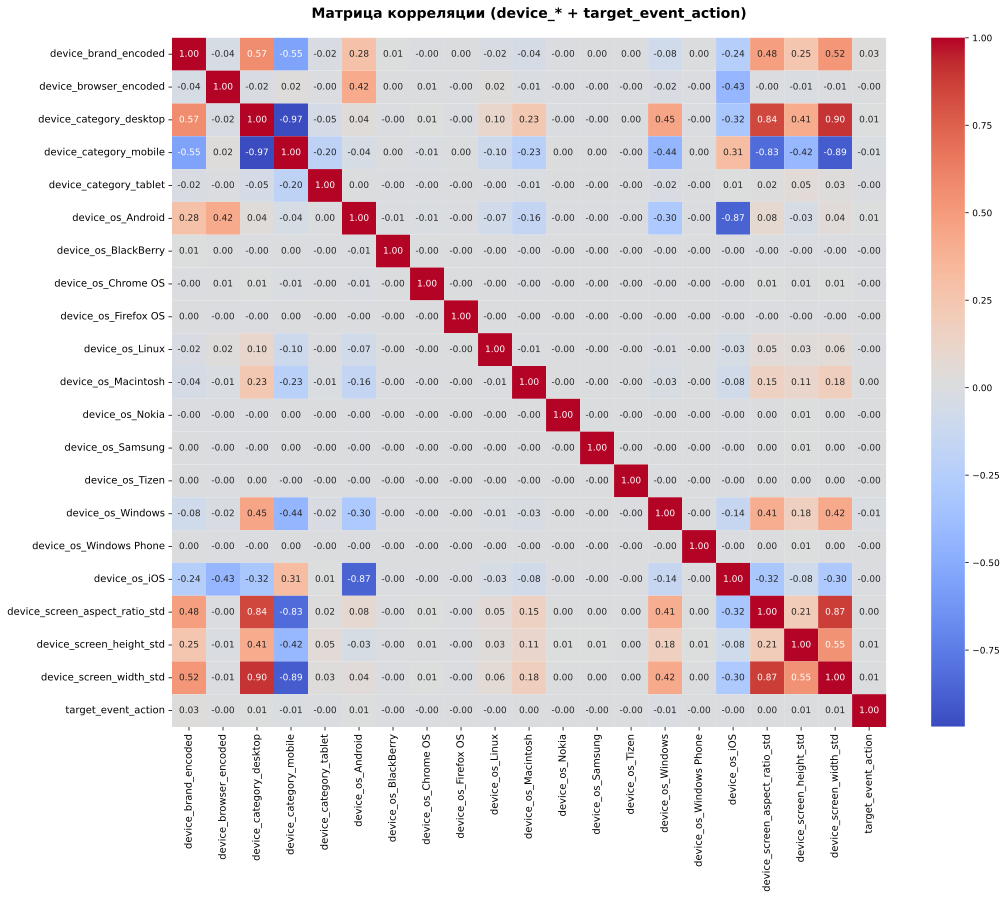

device_brand_encoded  device_browser_encoded  \
target_event_action                         0.025856               -0.000260   
device_brand_encoded                        1.000000               -0.036492   
device_category_desktop                     0.566568               -0.023157   
device_os_Android                           0.281636                0.418476   
device_screen_width_std                     0.516197               -0.006386   
device_screen_height_std                    0.250841               -0.013396   
device_screen_aspect_ratio_std              0.477258               -0.002093   
device_os_Macintosh                        -0.043700               -0.009050   
device_os_Firefox OS                        0.002106               -0.002268   
device_os_Nokia                            -0.001178               -0.001787   
device_os_Windows Phone                     0.000672               -0.001754   
device_os_Samsung                           0.001045               -0.002683   
device_browser_encoded                     -0.036492                1.000000   
device_os_Tizen                             0.003642               -0.003306   
device_os_BlackBerry                        0.009925                0.001818   
device_os_Chrome OS                        -0.002513                0.005703   
device_category_tablet                     -0.022293               -0.003276   
device_os_Linux                            -0.019713                0.024749   
device_os_iOS                              -0.243808               -0.429990   
device_os_Windows                          -0.083854               -0.022532   
device_category_mobile                     -0.550929                0.023538   

                                device_category_desktop  \
target_event_action                            0.013237   
device_brand_encoded                           0.566568   
device_category_desktop                        1.000000   
device_os_Android                              0.037863   
device_screen_width_std                        0.903865   
device_screen_height_std                       0.414914   
device_screen_aspect_ratio_std                 0.839494   
device_os_Macintosh                            0.234401   
device_os_Firefox OS                          -0.000629   
device_os_Nokia                               -0.000629   
device_os_Windows Phone                       -0.000727   
device_os_Samsung                             -0.000727   
device_browser_encoded                        -0.023157   
device_os_Tizen                                0.000431   
device_os_BlackBerry                          -0.001889   
device_os_Chrome OS                            0.013477   
device_category_tablet                        -0.049420   
device_os_Linux                                0.104523   
device_os_iOS                                 -0.320535   
device_os_Windows                              0.450302   
device_category_mobile                        -0.969943   

                                device_category_mobile  \
target_event_action                          -0.012400   
device_brand_encoded                         -0.550929   
device_category_desktop                      -0.969943   
device_os_Android                            -0.038156   
device_screen_width_std                      -0.893917   
device_screen_height_std                     -0.420293   
device_screen_aspect_ratio_std               -0.829897   
device_os_Macintosh                          -0.227469   
device_os_Firefox OS                          0.000649   
device_os_Nokia                               0.000649   
device_os_Windows Phone                       0.000749   
device_os_Samsung                             0.000749   
device_browser_encoded                        0.023538   
device_os_Tizen                              -0.000376   
device_os_BlackBerry                          0.001947   
device_os_Chrome OS                         

In [334]:
column_prefix = 'device_'
features_columns = df_sessions.filter(like=column_prefix).columns.tolist() + ['target_event_action']

corr_matrix, target_corr = matrix_corr(df_sessions[features_columns], column_prefix)
corr_matrix.sort_values('target_event_action', ascending=False)

#### Матрица корреляции - признаки geo_...

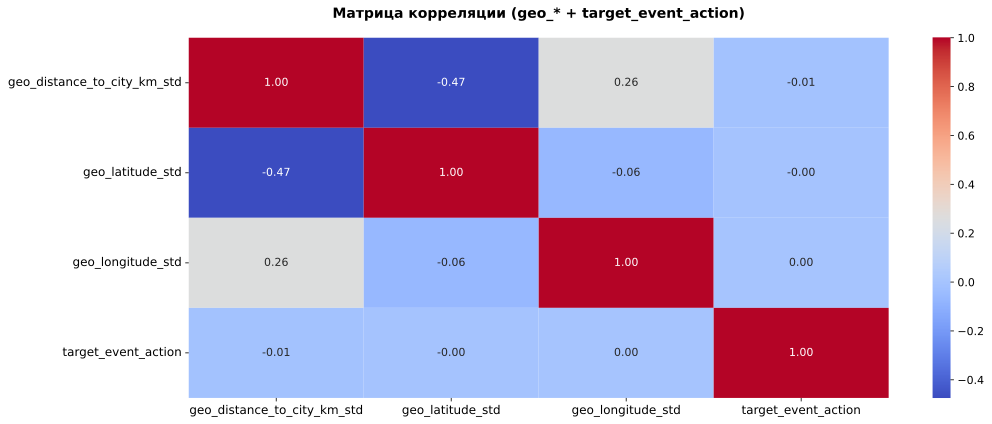

geo_distance_to_city_km_std  geo_latitude_std  \
target_event_action                            -0.012506         -0.003819   
geo_longitude_std                               0.262744         -0.064552   
geo_latitude_std                               -0.474255          1.000000   
geo_distance_to_city_km_std                     1.000000         -0.474255   

                             geo_longitude_std  target_event_action  
target_event_action                   0.002431             1.000000  
geo_longitude_std                     1.000000             0.002431  
geo_latitude_std                     -0.064552            -0.003819  
geo_distance_to_city_km_std           0.262744            -0.012506

In [335]:
column_prefix = 'geo_'
features_columns = df_sessions.filter(like=column_prefix).columns.tolist() + ['target_event_action']

corr_matrix, target_corr = matrix_corr(df_sessions[features_columns], column_prefix)
corr_matrix.sort_values('target_event_action', ascending=False)

#### Матрица корреляции - Все признаки_...

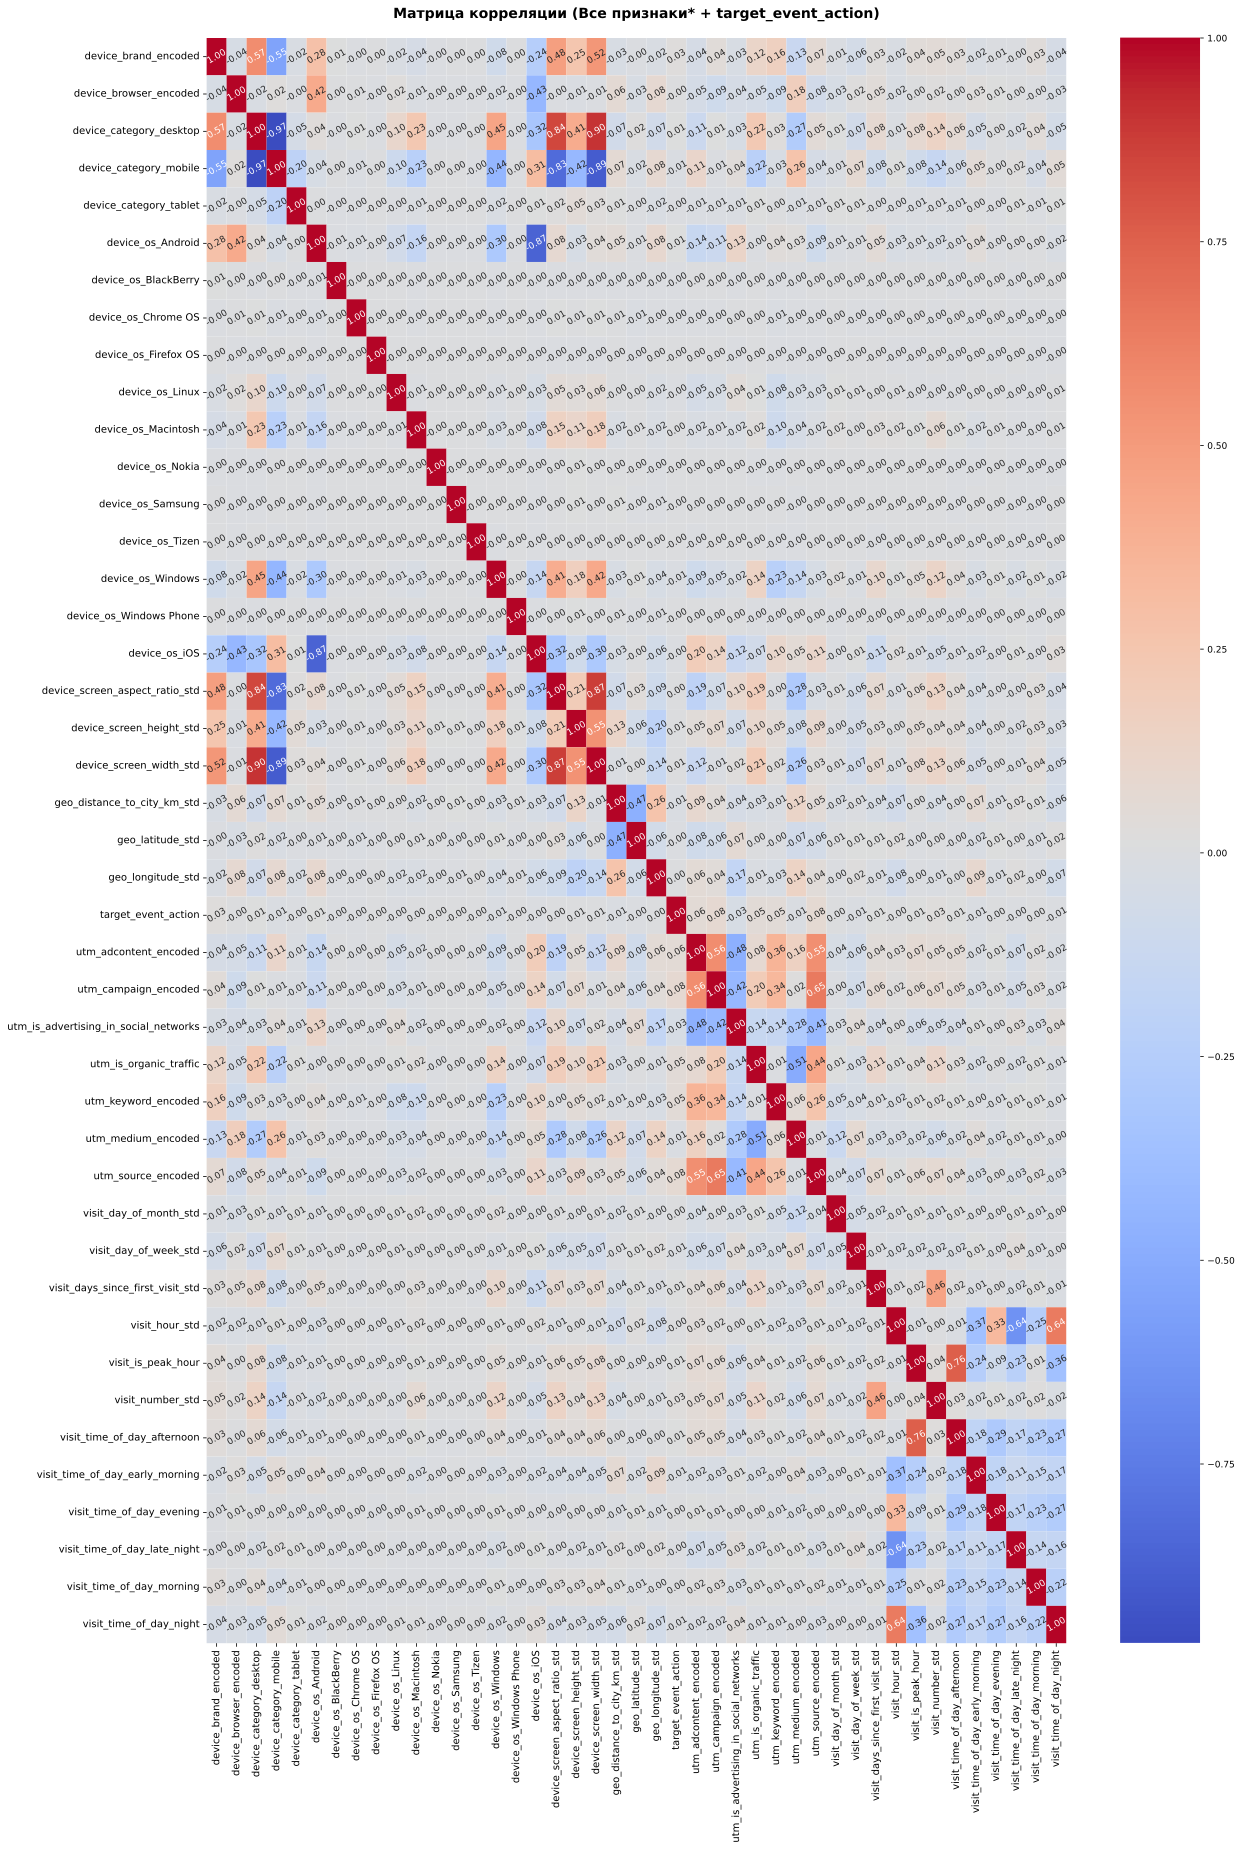

CPU times: total: 24.9 s
Wall time: 26.7 s


device_brand_encoded  \
target_event_action                                0.025856   
utm_campaign_encoded                               0.040704   
utm_source_encoded                                 0.066521   
utm_adcontent_encoded                             -0.039924   
utm_keyword_encoded                                0.162444   
utm_is_organic_traffic                             0.116587   
device_brand_encoded                               1.000000   
visit_number_std                                   0.050406   
visit_is_peak_hour                                 0.044978   
device_category_desktop                            0.566568   
visit_time_of_day_afternoon                        0.034189   
visit_days_since_first_visit_std                   0.030341   
device_os_Android                                  0.281636   
device_screen_width_std                            0.516197   
device_screen_height_std                           0.250841   
device_screen_aspect_ratio_std                     0.477258   
visit_time_of_day_evening                         -0.005400   
device_os_Macintosh                               -0.043700   
visit_time_of_day_morning                          0.031068   
geo_longitude_std                                 -0.020010   
visit_day_of_month_std                            -0.009949   
visit_hour_std                                    -0.021689   
device_os_Firefox OS                               0.002106   
device_os_Nokia                                   -0.001178   
device_os_Windows Phone                            0.000672   
device_os_Samsung                                  0.001045   
device_browser_encoded                            -0.036492   
device_os_Tizen                                    0.003642   
device_os_BlackBerry                               0.009925   
device_os_Chrome OS                               -0.002513   
visit_time_of_day_late_night                      -0.004524   
device_category_tablet                            -0.022293   
device_os_Linux                                   -0.019713   
device_os_iOS                                     -0.243808   
geo_latitude_std                                  -0.000472   
visit_time_of_day_night                           -0.040866   
utm_medium_encoded                                -0.126284   
visit_time_of_day_early_morning                   -0.018830   
device_os_Windows                                 -0.083854   
device_category_mobile                            -0.550929   
geo_distance_to_city_km_std                       -0.029217   
visit_day_of_week_std                             -0.058380   
utm_is_advertising_in_social_networks             -0.030895   

                                       device_browser_encoded  \
target_event_action                                 -0.000260   
utm_campaign_encoded                                -0.085775   
utm_source_encoded                                  -0.077208   
utm_adcontent_encoded                               -0.052118   
utm_keyword_encoded                                 -0.089193   
utm_is_organic_traffic                              -0.048349   
device_brand_encoded                                -0.036492   
visit_number_std                                     0.015194   
visit_is_peak_hour                                   0.002285   
device_category_desktop                             -0.023157   
visit_time_of_day_afternoon                          0.000958   
visit_days_since_first_visit_std                     0.045361   
device_os_Android                                    0.418476   
device_screen_width_std                             -0.006386   
device_screen_height_std                            -0.013396   
device_screen_aspect_ratio_std                      -0.002093   
visit_time_of_day_evening                            0.008770   
device_os_Macintosh                                 -0.009050   
visit_time_of_day_morning      

In [336]:
%%time
corr_matrix, target_corr = matrix_corr( df_sessions, 'Все признаки' )
corr_matrix.sort_values('target_event_action', ascending=False)

<span style="color:red"> 

#### Код ниже не используется! 

</span>

### Дополнительные преобразования признаков после 1-го анализа матрицы корреляции
#### На основании первого анализа матрицы корреляции решил:
- Удалить часть мультиколлинеарных и малозначимых признаков
- Создать несколько комбинированных (составных) признаков
- В роезультате итоговый датасет уменьшался бы с 42 до до 33-35 столбцов

#### Но по итогам последующего тестирования моделей на новом датасете, отказался от этой идеи:
* на нем метрика roc_auc теряла порядка 1-1.5%
* видимо, модели сами лучше находят эти связи и оценивают важность, чем я
* В итоге код последующих преобразований признаков оставил, но в финальной версии не использую,
обернул его в функции:    
    * preprocess_features_2_part
    * run_preprocess_features_2_part


In [ ]:
# Дополнительные преобразования признаков после 1-го анализа матриц корреляции
def preprocess_features_2_part(a_df, corr_matrix):
    #--------------------------------------------------------------------------------------------
    # 1. Удаление технических и низкозначимых признаков
        # Удаление признаков:
            #   => device_category_mobile         - высокая отрицательная корреляция -0,97 с device_category_desktop
            #   => device_screen_aspect_ratio_std - высокая корреляция 0,904 с device_screen_width_std
        # пока не стал удалять:
            #   => geo_distance_to_city_km_std    - слабая отрицательная корреляция -0.013 с target_event_action
            #   => visit_time_of_day_night 
    
    df = a_df.drop(columns=['device_category_mobile', 'device_screen_aspect_ratio_std'], errors='ignore')

    #--------------------------------------------------------------------------------------------
    # 2. Оптимизация device-атрибутов
        # Получаю список значимых OS из матрицы корреляции
        # Создаю временный столбец с названием основной OS
        # Группировка OS и создание бинарного признака
        # Преобразую в 1/0: 1 для значимых ОС, 0 для остальных
        # Удаляю старые столбцы с OS и временный столбец
    
    significant_os = corr_matrix.loc[
                                        (corr_matrix.index.str.startswith('device_os_')) & (corr_matrix['target_event_action'].abs() > 0.002),
                                        'target_event_action'
                                    ].index.str.replace('device_os_', '').tolist()
    

    os_cols = [c for c in df.columns if c.startswith('device_os_')]
    df['device_os_main_temp'] = df[os_cols].idxmax(axis=1).str.replace('device_os_', '')
    df['device_os_main']      = df['device_os_main_temp'].apply(lambda x: 1 if x in significant_os else 0)

    df = df.drop(columns=os_cols + ['device_os_main_temp']) 
    
    #--------------------------------------------------------------------------------------------
    # 3. Новый признак device_is_mobile_high_res (большое разрешение экрана (1 или 0))
    df['device_is_mobile_high_res'] = ((df['device_screen_width_std'] > 0.5) & (df['device_category_desktop'] == 0)).astype(int)

    #--------------------------------------------------------------------------------------------
    # 4. Новые признаки (времени) - Циклическое кодирование (часа визита и Дня недели визита)
        # Час визита
        # День недели виза
    df['visit_hour_time_sin'] = np.sin(2 * np.pi * df['visit_hour_std'] / 24)
    df['visit_hour_time_cos'] = np.cos(2 * np.pi * df['visit_hour_std'] / 24)

    df['visit_day_of_week_sin'] = np.sin(2 * np.pi * df['visit_day_of_week_std'] / 7)
    df['visit_day_of_week_cos'] = np.cos(2 * np.pi * df['visit_day_of_week_std'] / 7)

    #--------------------------------------------------------------------------------------------
    # 5. Создание взаимодействий признаков (сочетания разных групп признаков)
    df['combo_organic_mobile']    = df['utm_is_organic_traffic'] * (1 - df['device_category_desktop'])
    df['combo_paid_desktop_peak'] = (( 1 - df['utm_is_organic_traffic']) * df['device_category_desktop'] * df['visit_is_peak_hour'])

    #--------------------------------------------------------------------------------------------
    # 6. Фильтрация оставшихся малозначимых признаков
        # Порог важности выбрал = abs(corr) < 0.002
        # Удаляю только бесполезные признаки, но при этом не трогаю новые, только что созданные
        # Отбор малозначимых числовых признаков (abs(corr) < 0.002) (новые признаки не трогаю)
    
    numeric_cols = df.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

    list_new_features = [
                         'device_os_main',
                         'device_is_mobile_high_res',
                         'visit_hour_time_sin',
                         'visit_hour_time_cos',                    
                         'visit_day_of_week_sin',
                         'visit_day_of_week_cos',     
                         'combo_organic_mobile',
                         'combo_paid_desktop_peak']

    # матрица корреляция с целевой переменной
    target_corr  = df[ numeric_cols].corr()['target_event_action'].abs()
    
    # отбор признаков для удаления
    cols_to_drop = target_corr[ target_corr.abs() < 0.002].index.tolist()
    cols_to_drop = [f for f in cols_to_drop if f not in list_new_features]

    # Удаление малозначимых числовых признаков
    df.drop(columns=cols_to_drop, inplace=True)
    
    return df

In [ ]:
# Применение новых преобразований признаков (после 1-й итерации анализа матрицы корреляции)
def run_preprocess_features_2_part(a_df, corr_matrix):

    # ---------------------------------------------------------------------------------------------------------
    # 1. --- Вызов преобразований признаков
    df = preprocess_features_2_part(a_df.copy(), corr_matrix)

    list_new_features = ['device_os_main',
                    'device_is_mobile_high_res',
                    'visit_hour_time_sin',
                    'visit_hour_time_cos',                    
                    'visit_day_of_week_sin',
                    'visit_day_of_week_cos',     
                    'combo_organic_mobile',
                    'combo_paid_desktop_peak']

    # ---------------------------------------------------------------------------------------------------------
    # 2. --- Датасет
    print('Датасет df c новыми признаками')
    display(df.info())

    # ---------------------------------------------------------------------------------------------------------
    # 3. Описательная статистика числовых признаков
    print('Описательная статистика числовых признаков')
    pd.reset_option('display.float_format')
    
    with pd.option_context('display.float_format', '{:.5f}'.format):
        desc = df[list_new_features].describe()
        display(desc)

    # ---------------------------------------------------------------------------------------------------------
    # 4. --- Матрица корреляции - толко Новые признаки_...
    column_prefix = 'new'
    list_new_features = [
                        'device_is_mobile_high_res',
                        'visit_hour_time_sin',
                        'visit_hour_time_cos',                    
                        'visit_day_of_week_sin',
                        'visit_day_of_week_cos',     
                        'combo_organic_mobile',
                        'combo_paid_desktop_peak']
    features_columns = list_new_features + ['target_event_action']
    
    corr_matrix, target_corr = matrix_corr( df[features_columns], column_prefix)
    corr_matrix.sort_values('target_event_action', ascending=False)

    # ---------------------------------------------------------------------------------------------------------
    # 5. --- Матрица корреляции - Все признаки_...
    corr_matrix, target_corr = matrix_corr( df, 'Все признаки' )
    corr_matrix.sort_values('target_event_action', ascending=False)

    # ---------------------------------------------------------------------------------------------------------
    # Удаление признаков после 2-го анализа матрицы коррекляции
    cols_to_drop = ['visit_day_of_week_std']     # теперь вместо него есть sin и cos
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # ---------------------------------------------------------------------------------------------------------
    # 5. --- Матрица корреляции (3-я итерация) - Все признаки_...
    corr_matrix, target_corr = matrix_corr( df, 'Все признаки' )
    corr_matrix.sort_values('target_event_action', ascending=False)
    
    return df

#### Запуск преобразований признаков после (2-3 итерации анализа матрицы корреляции)

In [ ]:
# запуск преобразований признаков после (2-3 итерации анализа матрицы корреляции)
# run_preprocess_features_2_part(ds_sessions, corr_matrix)

In [ ]:
chime.success()
text_to_speech('Скрипт выполнен')

<span style="color:blue"> Внимание! Замер времени, контрольная точка </span>

In [ ]:
get_duration_time(dt_start)

## Создание файлов примеров для тестирования модели

In [47]:
import json
import os
import pandas as pd
from datetime import datetime

def save_sessions_to_json(a_df, output_dir='examples'):
    """
    Сохраняет записи из датафрейма:
    1. В отдельные JSON-файлы
    2. В один объединенный JSON-файл
    
    Параметры:
        a_df (pd.DataFrame): Исходный датафрейм
        output_dir (str): Директория для сохранения файлов
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Сортируем и фильтруем данные
    df_1 = a_df[a_df['target_event_action'] == 1].sort_values('session_id')
    df_0 = a_df[a_df['target_event_action'] == 0].sort_values('session_id')
    df_sorted = pd.concat([df_1, df_0])
    
    # Счетчики для имен файлов и список всех записей
    # counters = {1: 1, 0: 1}
    file_cnt = 0
    all_records = []
    
    for _, row in df_sorted.iterrows():
        target = row['target_event_action']
        # file_num = f"{counters[target]:02d}"
        # counters[target] += 1
        file_cnt += 1
        file_num = f"{file_cnt:03d}"
        
        # filename = f"example_{file_num}_target_{target}.json"
        filename = f"example_{file_num}_target_{target}.json"
        filepath = os.path.join(output_dir, filename)
        
        # Преобразуем запись в нужный формат
        record_dict = {}
        for col in row.index:
            value = row[col]
            
            # Обработка даты и времени
            if col == 'visit_date' and pd.notna(value):
                if isinstance(value, datetime):
                    value = value.strftime('%Y-%m-%d')
                elif isinstance(value, pd.Timestamp):
                    value = value.date().strftime('%Y-%m-%d')
                else:
                    value = str(value)
            elif col == 'visit_time' and pd.notna(value):
                if isinstance(value, datetime):
                    value = value.strftime('%H:%M:%S')
                elif hasattr(value, 'strftime'):
                    value = value.strftime('%H:%M:%S')
                else:
                    value = str(value)
            # Обработка пустых значений
            elif pd.isna(value):
                value = None
            
            record_dict[col] = value
        
        # Сохраняем отдельный файл
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(record_dict, f, ensure_ascii=False, indent=4, default=str)
        
        # Добавляем запись в общий список
        all_records.append(record_dict)
    
    # Сохраняем все записи в один файл
    combined_filename = os.path.join(output_dir, 'all_records.json')
    with open(combined_filename, 'w', encoding='utf-8') as f:
        json.dump(all_records, f, ensure_ascii=False, indent=4, default=str)
    
    print(f"Сохранено:")
    print(f"- {len(df_sorted)} отдельных файлов")
    print(f"- 1 объединенный файл (all_records.json)")
    print(f"В директорию: '{output_dir}'")

In [43]:
df_1 = df_sessions_source[ df_sessions_source[ 'target_event_action'] == 1 ].sample(50)
df_0 = df_sessions_source[ df_sessions_source[ 'target_event_action'] == 0 ].sample(50)
df_json = pd.concat( [df_0, df_1])
df_json

session_id              client_id  \
878863   4680722074539408621.1631599853.1631599853  1089815533.1631599853   
4658     9076195354776250548.1635617518.1635617518  2113216406.1635592372   
890310   4732733522901420504.1629440471.1629440471  1101925392.1629440472   
1400701  7009599431448734979.1633253329.1633253329  1632049547.1632120067   
1681538  8261238478735252426.1640940227.1640940227  1923469472.1640864714   
1591883  7859471741621808370.1637264626.1637264626  1829925864.1637264626   
1273593  6441614590953361016.1639943801.1639943801  1499805271.1639943800   
799197   4326428371159074504.1629210313.1629210313  1007325102.1629210312   
745016   4087249450691937739.1626108893.1626108893   951636920.1625769419   
1433754  7157396531776898662.1630324575.1630324575  1666461241.1630324326   
802055   4339752841471106274.1625340227.1625340227  1010427447.1625332962   
171514   1522406199701700717.1628602479.1628602479   354462815.1628602477   
1833674  8937797442476129458.1630485681.1630485681  2080993131.1630485682   
1581103  7809816452184129711.1634713775.1634713775  1818364591.1634713775   
1703667  8360321931143675190.1639579023.1639579023  1946539136.1639578934   
1827367  8909628989661808308.1632667316.1632667316  2074434652.1632667316   
1618474  7977440551763794104.1621977267.1621977267  1857392618.1621973176   
662503   3717894508200361227.1638432012.1638432012   865639771.1638432011   
629362   3567962972324135426.1629520386.1629520386   830731115.1629520386   
1226535  6233496032155156038.1634352711.1634352711  1451348893.1634352710   
1300564  6558878481008886929.1635583125.1635583125  1527107898.1635583121   
1591617  7858236594911625928.1622069087.1622069087  1829638284.1622065864   
1499316  7448296599479290514.1639352980.1639352980  1734191691.1639352978   
229727   1783945845185295573.1624093909.1624093909   415357259.1624093909   
57802    1010006370681647576.1633448411.1633448411   235160433.1633448408   
1204227  6133348316920089011.1640172015.1640172015  1428031436.1640171955   
1290048  6513135374208481856.1639594562.1639594562  1516457501.1639594560   
1692077  8307561522072042508.1624161294.1624161294  1934254896.1624161292   
52768     987521602710845787.1637529946.1637529946   229925290.1637529947   
1799583  8784121030136669820.1633003133.1633003133  2045212553.1633003132   
878378   4678317721786424491.1635687697.1635687697  1089255726.1635687595   
186712    158981205391088321.1632410328.1632410328    37015696.1632410305   
1857575  9044690451104619949.1635081645.1635081645  2105881099.1635081645   
596478   3420658659369485669.1637894612.1637894612   796434157.1637156197   
1737460  8510216105091494648.1640592125.1640592125  1981439093.1640592120   
496902   2976138980271611569.1637304809.1637304809   692936354.1632132785   
288667   2048345655441030022.1640430470.1640430470   476917637.1640430470   
795204   4309972972775363762.1640977593.1640977593  1003493781.1640977586   
1480480  7364147199328446905.1638459835.1638459835  1714599132.1638459833   
1407942  7042651919210271750.1631605772.1631605772  1639745179.1631605766   
1193406   608446041102674707.1626008338.1626008338   141664883.1626008339   
354797   2343192471645749622.1624277372.1624277372   545567011.1624277366   
206852    168054242200690950.1633719566.1633719566    39128177.1633591558   
818385    441067493382837777.1628329489.1628329489   102694028.1628329489   
1194858  6090817914366465533.1634080253.1634080322  1418129055.1634080253   
416783   2619852244554312119.1621859791.1621859791   609981884.1621846455   
643956    363391399230021890.1636409601.1636409601    84608653.1636409602   
101138   1205935348431408682.1633709523.1633709523   280778703.1633111594   
1823781  8894109095272282529.1632008636.1632008636  2070821145.1632008609   
879171   4682092993741983255.1633029656.1633029656  1090134725.1633029655   
668069    374337192097178216.1630233193.1630233193    87157169.1630233192   
815369   4397750228713951052.1633898

In [49]:
if False:
    save_sessions_to_json(df_json, output_dir='examples')

Сохранено:
- 100 отдельных файлов
- 1 объединенный файл (all_records.json)
В директорию: 'examples'
